[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1U9TYyaSjs1hsp3p-C7Y2zNUhHHHzgd4p)

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))

from tqdm import tqdm 


from attack import target_adversarial , fgsm_attack, test_fgsm_mnist , test_LBFGS_mnist, validation 
from Net import Net

%load_ext autoreload
%autoreload 2

**GOAL :**
* Vanilla Deep NN 
* Code the attack : Fast gradient signed attackFGSM
* **Objective** : add the least amount of perturbation to the input data to cause the desired misclassification

Two assumptions : 
* white box: full access to model, architecture, inputs, outputs, and weights
* black box :  attacker only has access to the inputs and outputs of the model

We will focus on attacks following the white box assumption

# Data and Model

Getting model and mnist data

In [2]:
mnist_testset = datasets.MNIST('./data_mnist', 
                   train=False,
                   download=False, 
                   transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1,shuffle=True)

In [4]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True 

In [5]:
# Init device 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Init the network
model = Net().to(device)

# Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()


CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# FGSM attack 

$ pimage= x +  \epsilon * sign(\nabla_{x} J(\theta,x,y))$

where $\epsilon$ : how much we perturbe image $x$
 


In [70]:
#%timeit 
accuracies_FGSM = []
examples_FGSM = []
epsilons =[0.1,0.3,0.5,0.7]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm_mnist(model, device, test_loader, eps)
    accuracies_FGSM.append(acc)
    examples_FGSM.append(ex)




















Iteration for epsilon = 0.1:   0%|          | 0/10000 [00:00<?, ?it/s]


















Iteration for epsilon = 0.1:   0%|          | 38/10000 [00:00<00:26, 369.54it/s]


















Iteration for epsilon = 0.1:   1%|          | 79/10000 [00:00<00:26, 378.58it/s]


















Iteration for epsilon = 0.1:   1%|          | 121/10000 [00:00<00:25, 389.48it/s]


















Iteration for epsilon = 0.1:   2%|▏         | 163/10000 [00:00<00:24, 397.64it/s]


















Iteration for epsilon = 0.1:   2%|▏         | 205/10000 [00:00<00:24, 401.49it/s]


















Iteration for epsilon = 0.1:   2%|▏         | 245/10000 [00:00<00:24, 400.15it/s]


















Iteration for epsilon = 0.1:   3%|▎         | 281/10000 [00:00<00:25, 383.63it/s]


















Iteration for epsilon = 0.1:   3%|▎         | 323/10000 [00:00<00:24, 391.31it/s]


















Iteration for epsilon = 0.1:   4%|▎         | 364/10000 [00:00<00:24, 395.36it/s]














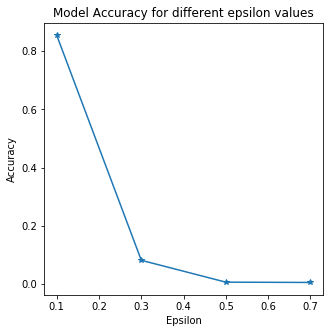

In [81]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(epsilons, accuracies_FGSM, "*-")
#ax.yticks(np.arange(0, 1.1, step=0.1))
#ax.xticks(np.arange(0, .35, step=0.05))
plt.title("Model Accuracy for different epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig('Results/Testing FGSM mnist.png')
plt.show()

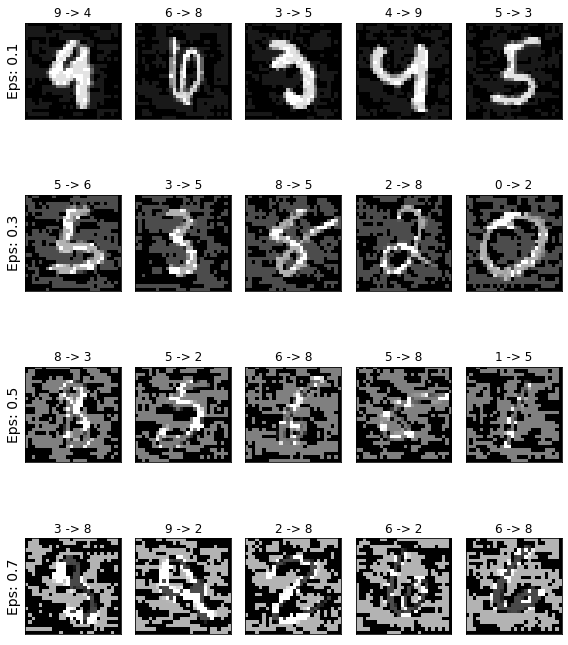

In [34]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()

plt.savefig('Results/Exemples FGSM mnist.png')
plt.show()


**Problem :** 
* Adv exemples too different from the original output
* Can't target a specific output
* Test on differents architectures  

# L-BFGS attack
- Implement non targeted attack w pytorch 
    * set goal : $y_{goal}$ : one hot vector with $j^th$ positing as 1
    * Define cost : $C = 1/2*\|y_{goal} - y(x)\|^2$
- Implement targeted attack w pytorch

## Random attack

In [12]:
def adversarial(model, device, n=2,epochs = 10,eta=0.5):
    """
    net : network object
        neural network instance to use
    n :  goal label (just an int, the function transforms it into a one-hot vector)
    
    epochs : integer
        number of steps for gradient descent
    """
    # Set the goal output
    goal = torch.tensor([n]).to(device)
    
    #
    x = torch.randn(1,1,28,28).to(device)
    x.requires_grad = True
    
    # Gradient descent on the input
    for epoch in range(epochs):
        output = model(x)
        loss = F.nll_loss(output, goal) 
        model.zero_grad()
        # Backward pass
        loss.backward()
        # Get grad
        d = x.grad.data
        # The sGD update on x
        with torch.no_grad():
            # we don't need to update model params
            x -= eta * d     
            x.grad = None
    return x

 This image is classfied as a :  8


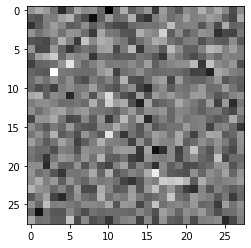

In [161]:
adv = adversarial(model,device,n=8)
label = model(adv).max(1, keepdim=True)[1]
adv = adv.squeeze().detach().cpu().numpy()
plt.imshow(adv,cmap='gray')
print(" This image is classfied as a : ", label.item())

--- 

## Targeted adversary

**Target adversarial :** Generate adversarial while trying to be close to an actual image

 $C = nullloss(y_{goal} - y(x)) +\lambda \|\vec x - \vec x_{target}\|^2_2 $

In [13]:
def target_adversarial(model,x_target, device, n=2,epochs = 200,eta=0.5, lmd=0.05):
    """
    net : network object
        neural network instance to use
    n :  goal label (just an int, the function transforms it into a one-hot vector)
    
    epochs : integer
        number of steps for gradient descent
    """
    # Set the goal output
    goal = torch.tensor([n]).to(device)
    
    #
    x = torch.randn(1,1,28,28).to(device)
    x.requires_grad = True
    
    # Gradient descent on the input
    for epoch in range(epochs):
        output = model(x)
        loss = F.nll_loss(output, goal) 
        model.zero_grad()
        # Backward pass
        loss.backward()
        # Get grad
        d = x.grad.data
        # The sGD update on x
        with torch.no_grad():
            # we don't need to update model params
            x -= eta * (d + lmd * (x - x_target)) 
            x.grad = None
    return x

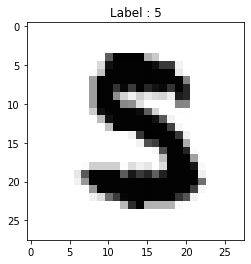

In [167]:
for d , t in test_loader : 
    data = d 
    target = t
    break
    
data_numpy = data.squeeze().detach().cpu().numpy()

fig, ax = plt.subplots()

ax.imshow(data_numpy,cmap='Greys')
ax.set_title("Label : {}".format(target.item()))
plt.show()

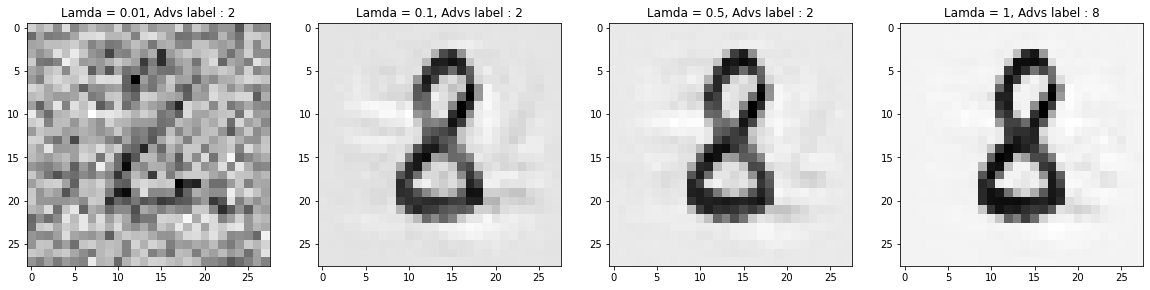

In [63]:
lmds =[0.01,0.1, 0.5,1]
fig, ax = plt.subplots(1,len(lmds),figsize=(20,10))

for i, lmd in enumerate(lmds) : 
    adv = target_adversarial(model,data,device,lmd=lmd)
    label = model(adv).max(1, keepdim=True)[1]
    adv = adv.squeeze().detach().cpu().numpy()
    ax[i].imshow(adv,cmap='Greys')
    ax[i].set_title("Lamda = {}, Advs label : {}".format(lmd,label.item()))
    

## Testing 

In [8]:
%reload_ext autoreload

In [77]:
def test_LBFGS_mnist(model,device,testloader,lmd):
    correct = 0
    adv_examples = []
    loop = tqdm(testloader,desc='Lambda = {}'.format(lmd))
    for i, (data, target) in enumerate(loop):
        if i == 1000 :
            break
        data = data.to(device)
        target = target.to(target)
        data.requires_grad = True
        
        # Get initial label
        output = model(data)          
        init_pred = output.max(1, keepdim=True)[1] #index of the max log-probability
        if init_pred.item() != target.item():
            # Skip bad exemples in testdata
            print('bad exemple')
            continue  
        n=torch.tensor(0)
        while n.item() == target.item():
            n = torch.randint(low=0,high=9,size=(1,))
        # Generate Adversarial exemple
        adv = target_adversarial(model,data,device,n,lmd=lmd)       
        output = model(adv)
        final_pred = output.max(1, keepdim=True)[1]
        # If same label changed
        if final_pred.item() == target.item(): 
             correct += 1
        else :
            if len(adv_examples) < 5:
                adversary = adv.squeeze().detach().cpu().numpy()
                original = data.squeeze().detach().cpu().numpy()
                adv_examples.append((original, adversary, init_pred , final_pred))
    final_acc = correct / 1000 # Normally float(len(testloader)) 
    return final_acc, adv_examples

In [78]:
accuracies_LBFGS = []
examples_LBFGS = []
lmds =[0.01,0.1, 0.5,1]

# Run test for each lambda
for lmd in lmds:
    acc, ex = test_LBFGS_mnist(model, device, test_loader, lmd)
    accuracies_LBFGS.append(acc)
    examples_LBFGS.append(ex)






















Lambda = 0.01:   0%|          | 0/10000 [00:00<?, ?it/s]




















Lambda = 0.01:   0%|          | 1/10000 [00:00<56:37,  2.94it/s]




















Lambda = 0.01:   0%|          | 2/10000 [00:00<56:44,  2.94it/s]




















Lambda = 0.01:   0%|          | 3/10000 [00:01<56:25,  2.95it/s]




















Lambda = 0.01:   0%|          | 4/10000 [00:01<56:32,  2.95it/s]




















Lambda = 0.01:   0%|          | 5/10000 [00:01<56:47,  2.93it/s]




















Lambda = 0.01:   0%|          | 6/10000 [00:02<56:46,  2.93it/s]




















Lambda = 0.01:   0%|          | 7/10000 [00:02<56:35,  2.94it/s]




















Lambda = 0.01:   0%|          | 8/10000 [00:02<56:32,  2.95it/s]




















Lambda = 0.01:   0%|          | 9/10000 [00:03<55:58,  2.97it/s]




















Lambda = 0.01:   0%|          | 10/10000 [00:03<55:59,  2.97it/s]




















Lambda = 0.01:   0%|          | 11/10000 [00:03<55:

bad exemple























Lambda = 0.01:   1%|          | 68/10000 [00:22<48:00,  3.45it/s]




















Lambda = 0.01:   1%|          | 69/10000 [00:23<50:29,  3.28it/s]




















Lambda = 0.01:   1%|          | 70/10000 [00:23<52:13,  3.17it/s]




















Lambda = 0.01:   1%|          | 71/10000 [00:23<52:53,  3.13it/s]




















Lambda = 0.01:   1%|          | 72/10000 [00:24<54:06,  3.06it/s]




















Lambda = 0.01:   1%|          | 73/10000 [00:24<54:55,  3.01it/s]




















Lambda = 0.01:   1%|          | 74/10000 [00:24<55:23,  2.99it/s]




















Lambda = 0.01:   1%|          | 75/10000 [00:25<55:18,  2.99it/s]




















Lambda = 0.01:   1%|          | 76/10000 [00:25<56:13,  2.94it/s]




















Lambda = 0.01:   1%|          | 77/10000 [00:25<55:51,  2.96it/s]




















Lambda = 0.01:   1%|          | 78/10000 [00:26<55:47,  2.96it/s]




















Lambda = 0.01:   1%|          | 7

bad exemple























Lambda = 0.01:   1%|▏         | 137/10000 [00:45<47:08,  3.49it/s]




















Lambda = 0.01:   1%|▏         | 138/10000 [00:46<49:57,  3.29it/s]




















Lambda = 0.01:   1%|▏         | 139/10000 [00:46<51:47,  3.17it/s]




















Lambda = 0.01:   1%|▏         | 140/10000 [00:46<52:51,  3.11it/s]




















Lambda = 0.01:   1%|▏         | 141/10000 [00:47<54:17,  3.03it/s]




















Lambda = 0.01:   1%|▏         | 142/10000 [00:47<54:08,  3.03it/s]




















Lambda = 0.01:   1%|▏         | 143/10000 [00:47<54:39,  3.01it/s]




















Lambda = 0.01:   1%|▏         | 144/10000 [00:48<55:02,  2.98it/s]




















Lambda = 0.01:   1%|▏         | 145/10000 [00:48<54:50,  2.99it/s]




















Lambda = 0.01:   1%|▏         | 146/10000 [00:48<55:07,  2.98it/s]

bad exemple























Lambda = 0.01:   1%|▏         | 148/10000 [00:49<46:42,  3.52it/s]




















Lambda = 0.01:   1%|▏         | 149/10000 [00:49<50:08,  3.27it/s]




















Lambda = 0.01:   2%|▏         | 150/10000 [00:49<51:16,  3.20it/s]




















Lambda = 0.01:   2%|▏         | 151/10000 [00:50<52:39,  3.12it/s]




















Lambda = 0.01:   2%|▏         | 152/10000 [00:50<53:28,  3.07it/s]




















Lambda = 0.01:   2%|▏         | 153/10000 [00:50<53:35,  3.06it/s]




















Lambda = 0.01:   2%|▏         | 154/10000 [00:51<54:17,  3.02it/s]




















Lambda = 0.01:   2%|▏         | 155/10000 [00:51<54:49,  2.99it/s]




















Lambda = 0.01:   2%|▏         | 156/10000 [00:51<54:56,  2.99it/s]




















Lambda = 0.01:   2%|▏         | 157/10000 [00:52<55:05,  2.98it/s]




















Lambda = 0.01:   2%|▏         | 158/10000 [00:52<55:22,  2.96it/s]




















Lambda = 0.01:   2%|▏ 

bad exemple























Lambda = 0.01:   2%|▏         | 225/10000 [01:15<46:39,  3.49it/s]




















Lambda = 0.01:   2%|▏         | 226/10000 [01:15<48:57,  3.33it/s]




















Lambda = 0.01:   2%|▏         | 227/10000 [01:15<51:05,  3.19it/s]




















Lambda = 0.01:   2%|▏         | 228/10000 [01:16<52:28,  3.10it/s]




















Lambda = 0.01:   2%|▏         | 229/10000 [01:16<53:32,  3.04it/s]




















Lambda = 0.01:   2%|▏         | 230/10000 [01:16<53:30,  3.04it/s]




















Lambda = 0.01:   2%|▏         | 231/10000 [01:17<53:53,  3.02it/s]




















Lambda = 0.01:   2%|▏         | 232/10000 [01:17<54:24,  2.99it/s]




















Lambda = 0.01:   2%|▏         | 233/10000 [01:17<54:07,  3.01it/s]




















Lambda = 0.01:   2%|▏         | 234/10000 [01:18<54:52,  2.97it/s]




















Lambda = 0.01:   2%|▏         | 235/10000 [01:18<55:15,  2.95it/s]




















Lambda = 0.01:   2%|▏ 

bad exemple























Lambda = 0.01:   3%|▎         | 282/10000 [01:34<46:33,  3.48it/s]




















Lambda = 0.01:   3%|▎         | 283/10000 [01:34<49:12,  3.29it/s]




















Lambda = 0.01:   3%|▎         | 284/10000 [01:34<51:35,  3.14it/s]




















Lambda = 0.01:   3%|▎         | 285/10000 [01:35<52:39,  3.08it/s]




















Lambda = 0.01:   3%|▎         | 286/10000 [01:35<53:41,  3.02it/s]




















Lambda = 0.01:   3%|▎         | 287/10000 [01:35<53:38,  3.02it/s]




















Lambda = 0.01:   3%|▎         | 288/10000 [01:36<53:49,  3.01it/s]




















Lambda = 0.01:   3%|▎         | 289/10000 [01:36<53:55,  3.00it/s]




















Lambda = 0.01:   3%|▎         | 290/10000 [01:36<54:51,  2.95it/s]




















Lambda = 0.01:   3%|▎         | 291/10000 [01:37<54:54,  2.95it/s]




















Lambda = 0.01:   3%|▎         | 292/10000 [01:37<54:23,  2.97it/s]




















Lambda = 0.01:   3%|▎ 

bad exemple























Lambda = 0.01:   3%|▎         | 302/10000 [01:40<46:32,  3.47it/s]




















Lambda = 0.01:   3%|▎         | 303/10000 [01:40<49:49,  3.24it/s]




















Lambda = 0.01:   3%|▎         | 304/10000 [01:41<50:41,  3.19it/s]




















Lambda = 0.01:   3%|▎         | 305/10000 [01:41<51:33,  3.13it/s]




















Lambda = 0.01:   3%|▎         | 306/10000 [01:41<52:37,  3.07it/s]




















Lambda = 0.01:   3%|▎         | 307/10000 [01:42<53:10,  3.04it/s]




















Lambda = 0.01:   3%|▎         | 308/10000 [01:42<53:33,  3.02it/s]




















Lambda = 0.01:   3%|▎         | 309/10000 [01:42<53:32,  3.02it/s]




















Lambda = 0.01:   3%|▎         | 310/10000 [01:43<54:07,  2.98it/s]




















Lambda = 0.01:   3%|▎         | 311/10000 [01:43<53:46,  3.00it/s]




















Lambda = 0.01:   3%|▎         | 312/10000 [01:43<53:43,  3.01it/s]




















Lambda = 0.01:   3%|▎ 

bad exemple























Lambda = 0.01:   5%|▌         | 516/10000 [02:52<45:14,  3.49it/s]




















Lambda = 0.01:   5%|▌         | 517/10000 [02:53<47:54,  3.30it/s]




















Lambda = 0.01:   5%|▌         | 518/10000 [02:53<49:16,  3.21it/s]




















Lambda = 0.01:   5%|▌         | 519/10000 [02:53<49:59,  3.16it/s]




















Lambda = 0.01:   5%|▌         | 520/10000 [02:54<50:54,  3.10it/s]




















Lambda = 0.01:   5%|▌         | 521/10000 [02:54<51:52,  3.05it/s]




















Lambda = 0.01:   5%|▌         | 522/10000 [02:54<52:27,  3.01it/s]




















Lambda = 0.01:   5%|▌         | 523/10000 [02:55<52:59,  2.98it/s]




















Lambda = 0.01:   5%|▌         | 524/10000 [02:55<52:50,  2.99it/s]




















Lambda = 0.01:   5%|▌         | 525/10000 [02:55<52:59,  2.98it/s]




















Lambda = 0.01:   5%|▌         | 526/10000 [02:56<52:52,  2.99it/s]




















Lambda = 0.01:   5%|▌ 

bad exemple























Lambda = 0.01:   6%|▌         | 566/10000 [03:09<44:37,  3.52it/s]




















Lambda = 0.01:   6%|▌         | 567/10000 [03:09<47:25,  3.31it/s]




















Lambda = 0.01:   6%|▌         | 568/10000 [03:09<48:38,  3.23it/s]




















Lambda = 0.01:   6%|▌         | 569/10000 [03:10<50:07,  3.14it/s]




















Lambda = 0.01:   6%|▌         | 570/10000 [03:10<50:46,  3.10it/s]




















Lambda = 0.01:   6%|▌         | 571/10000 [03:10<51:09,  3.07it/s]




















Lambda = 0.01:   6%|▌         | 572/10000 [03:11<51:46,  3.04it/s]




















Lambda = 0.01:   6%|▌         | 573/10000 [03:11<52:14,  3.01it/s]




















Lambda = 0.01:   6%|▌         | 574/10000 [03:11<52:10,  3.01it/s]




















Lambda = 0.01:   6%|▌         | 575/10000 [03:12<52:10,  3.01it/s]




















Lambda = 0.01:   6%|▌         | 576/10000 [03:12<51:55,  3.03it/s]




















Lambda = 0.01:   6%|▌ 

bad exemple























Lambda = 0.01:   6%|▌         | 602/10000 [03:20<44:37,  3.51it/s]




















Lambda = 0.01:   6%|▌         | 603/10000 [03:21<46:59,  3.33it/s]




















Lambda = 0.01:   6%|▌         | 604/10000 [03:21<48:53,  3.20it/s]




















Lambda = 0.01:   6%|▌         | 605/10000 [03:22<50:34,  3.10it/s]




















Lambda = 0.01:   6%|▌         | 606/10000 [03:22<51:25,  3.04it/s]




















Lambda = 0.01:   6%|▌         | 607/10000 [03:22<51:59,  3.01it/s]




















Lambda = 0.01:   6%|▌         | 608/10000 [03:23<51:59,  3.01it/s]




















Lambda = 0.01:   6%|▌         | 609/10000 [03:23<51:42,  3.03it/s]




















Lambda = 0.01:   6%|▌         | 610/10000 [03:23<51:58,  3.01it/s]




















Lambda = 0.01:   6%|▌         | 611/10000 [03:24<52:32,  2.98it/s]

bad exemple























Lambda = 0.01:   6%|▌         | 613/10000 [03:24<44:30,  3.52it/s]




















Lambda = 0.01:   6%|▌         | 614/10000 [03:24<46:55,  3.33it/s]




















Lambda = 0.01:   6%|▌         | 615/10000 [03:25<48:13,  3.24it/s]




















Lambda = 0.01:   6%|▌         | 616/10000 [03:25<49:27,  3.16it/s]




















Lambda = 0.01:   6%|▌         | 617/10000 [03:25<50:14,  3.11it/s]




















Lambda = 0.01:   6%|▌         | 618/10000 [03:26<50:58,  3.07it/s]




















Lambda = 0.01:   6%|▌         | 619/10000 [03:26<51:17,  3.05it/s]




















Lambda = 0.01:   6%|▌         | 620/10000 [03:26<51:12,  3.05it/s]




















Lambda = 0.01:   6%|▌         | 621/10000 [03:27<51:36,  3.03it/s]




















Lambda = 0.01:   6%|▌         | 622/10000 [03:27<51:37,  3.03it/s]




















Lambda = 0.01:   6%|▌         | 623/10000 [03:27<51:59,  3.01it/s]




















Lambda = 0.01:   6%|▌ 

bad exemple























Lambda = 0.01:   7%|▋         | 656/10000 [03:38<44:47,  3.48it/s]




















Lambda = 0.01:   7%|▋         | 657/10000 [03:38<46:44,  3.33it/s]




















Lambda = 0.01:   7%|▋         | 658/10000 [03:39<48:17,  3.22it/s]




















Lambda = 0.01:   7%|▋         | 659/10000 [03:39<49:40,  3.13it/s]




















Lambda = 0.01:   7%|▋         | 660/10000 [03:39<50:23,  3.09it/s]




















Lambda = 0.01:   7%|▋         | 661/10000 [03:40<50:38,  3.07it/s]




















Lambda = 0.01:   7%|▋         | 662/10000 [03:40<51:59,  2.99it/s]




















Lambda = 0.01:   7%|▋         | 663/10000 [03:40<51:52,  3.00it/s]




















Lambda = 0.01:   7%|▋         | 664/10000 [03:41<51:42,  3.01it/s]




















Lambda = 0.01:   7%|▋         | 665/10000 [03:41<52:07,  2.98it/s]




















Lambda = 0.01:   7%|▋         | 666/10000 [03:41<52:48,  2.95it/s]




















Lambda = 0.01:   7%|▋ 

bad exemple























Lambda = 0.01:   7%|▋         | 700/10000 [03:52<44:40,  3.47it/s]




















Lambda = 0.01:   7%|▋         | 701/10000 [03:53<46:59,  3.30it/s]




















Lambda = 0.01:   7%|▋         | 702/10000 [03:53<48:44,  3.18it/s]




















Lambda = 0.01:   7%|▋         | 703/10000 [03:54<49:51,  3.11it/s]




















Lambda = 0.01:   7%|▋         | 704/10000 [03:54<50:22,  3.08it/s]




















Lambda = 0.01:   7%|▋         | 705/10000 [03:54<51:18,  3.02it/s]




















Lambda = 0.01:   7%|▋         | 706/10000 [03:55<51:23,  3.01it/s]




















Lambda = 0.01:   7%|▋         | 707/10000 [03:55<51:21,  3.02it/s]




















Lambda = 0.01:   7%|▋         | 708/10000 [03:55<51:21,  3.02it/s]




















Lambda = 0.01:   7%|▋         | 709/10000 [03:56<51:24,  3.01it/s]




















Lambda = 0.01:   7%|▋         | 710/10000 [03:56<51:41,  3.00it/s]




















Lambda = 0.01:   7%|▋ 

bad exemple























Lambda = 0.01:   8%|▊         | 758/10000 [04:12<44:39,  3.45it/s]




















Lambda = 0.01:   8%|▊         | 759/10000 [04:12<46:32,  3.31it/s]




















Lambda = 0.01:   8%|▊         | 760/10000 [04:12<47:39,  3.23it/s]




















Lambda = 0.01:   8%|▊         | 761/10000 [04:13<49:17,  3.12it/s]




















Lambda = 0.01:   8%|▊         | 762/10000 [04:13<50:01,  3.08it/s]




















Lambda = 0.01:   8%|▊         | 763/10000 [04:13<50:07,  3.07it/s]




















Lambda = 0.01:   8%|▊         | 764/10000 [04:14<50:27,  3.05it/s]




















Lambda = 0.01:   8%|▊         | 765/10000 [04:14<50:23,  3.05it/s]




















Lambda = 0.01:   8%|▊         | 766/10000 [04:14<50:31,  3.05it/s]




















Lambda = 0.01:   8%|▊         | 767/10000 [04:15<51:37,  2.98it/s]




















Lambda = 0.01:   8%|▊         | 768/10000 [04:15<52:01,  2.96it/s]




















Lambda = 0.01:   8%|▊ 

bad exemple























Lambda = 0.01:   9%|▊         | 853/10000 [04:43<43:21,  3.52it/s]




















Lambda = 0.01:   9%|▊         | 854/10000 [04:44<46:25,  3.28it/s]




















Lambda = 0.01:   9%|▊         | 855/10000 [04:44<47:42,  3.19it/s]




















Lambda = 0.01:   9%|▊         | 856/10000 [04:45<48:34,  3.14it/s]




















Lambda = 0.01:   9%|▊         | 857/10000 [04:45<49:43,  3.06it/s]




















Lambda = 0.01:   9%|▊         | 858/10000 [04:45<49:47,  3.06it/s]




















Lambda = 0.01:   9%|▊         | 859/10000 [04:46<50:06,  3.04it/s]




















Lambda = 0.01:   9%|▊         | 860/10000 [04:46<50:39,  3.01it/s]




















Lambda = 0.01:   9%|▊         | 861/10000 [04:46<50:49,  3.00it/s]




















Lambda = 0.01:   9%|▊         | 862/10000 [04:47<50:44,  3.00it/s]




















Lambda = 0.01:   9%|▊         | 863/10000 [04:47<51:03,  2.98it/s]




















Lambda = 0.01:   9%|▊ 

bad exemple























Lambda = 0.01:   9%|▉         | 877/10000 [04:51<43:49,  3.47it/s]




















Lambda = 0.01:   9%|▉         | 878/10000 [04:52<46:20,  3.28it/s]




















Lambda = 0.01:   9%|▉         | 879/10000 [04:52<47:54,  3.17it/s]




















Lambda = 0.01:   9%|▉         | 880/10000 [04:52<48:36,  3.13it/s]




















Lambda = 0.01:   9%|▉         | 881/10000 [04:53<49:55,  3.04it/s]




















Lambda = 0.01:   9%|▉         | 882/10000 [04:53<50:25,  3.01it/s]




















Lambda = 0.01:   9%|▉         | 883/10000 [04:53<51:07,  2.97it/s]




















Lambda = 0.01:   9%|▉         | 884/10000 [04:54<50:40,  3.00it/s]




















Lambda = 0.01:   9%|▉         | 885/10000 [04:54<51:38,  2.94it/s]




















Lambda = 0.01:   9%|▉         | 886/10000 [04:54<51:58,  2.92it/s]




















Lambda = 0.01:   9%|▉         | 887/10000 [04:55<51:42,  2.94it/s]




















Lambda = 0.01:   9%|▉ 

bad exemple























Lambda = 0.01:  10%|█         | 1000/10000 [05:33<42:52,  3.50it/s]





















Lambda = 0.1:   0%|          | 0/10000 [00:00<?, ?it/s]





















Lambda = 0.1:   0%|          | 1/10000 [00:00<56:36,  2.94it/s]





















Lambda = 0.1:   0%|          | 2/10000 [00:00<56:40,  2.94it/s]





















Lambda = 0.1:   0%|          | 3/10000 [00:01<56:06,  2.97it/s]





















Lambda = 0.1:   0%|          | 4/10000 [00:01<55:52,  2.98it/s]





















Lambda = 0.1:   0%|          | 5/10000 [00:01<55:56,  2.98it/s]





















Lambda = 0.1:   0%|          | 6/10000 [00:02<56:07,  2.97it/s]





















Lambda = 0.1:   0%|          | 7/10000 [00:02<56:51,  2.93it/s]





















Lambda = 0.1:   0%|          | 8/10000 [00:02<57:05,  2.92it/s]





















Lambda = 0.1:   0%|          | 9/10000 [00:03<56:34,  2.94it/s]





















Lambda = 0.1:   0%|          | 10/10000 [00:03<5

bad exemple
























Lambda = 0.1:   1%|          | 80/10000 [00:26<46:48,  3.53it/s]





















Lambda = 0.1:   1%|          | 81/10000 [00:26<49:29,  3.34it/s]





















Lambda = 0.1:   1%|          | 82/10000 [00:27<51:45,  3.19it/s]





















Lambda = 0.1:   1%|          | 83/10000 [00:27<53:18,  3.10it/s]

bad exemple
























Lambda = 0.1:   1%|          | 85/10000 [00:27<45:45,  3.61it/s]





















Lambda = 0.1:   1%|          | 86/10000 [00:28<48:14,  3.43it/s]





















Lambda = 0.1:   1%|          | 87/10000 [00:28<50:37,  3.26it/s]





















Lambda = 0.1:   1%|          | 88/10000 [00:28<52:27,  3.15it/s]





















Lambda = 0.1:   1%|          | 89/10000 [00:29<54:04,  3.05it/s]





















Lambda = 0.1:   1%|          | 90/10000 [00:29<54:52,  3.01it/s]





















Lambda = 0.1:   1%|          | 91/10000 [00:29<54:39,  3.02it/s]





















Lambda = 0.1:   1%|          | 92/10000 [00:30<54:55,  3.01it/s]





















Lambda = 0.1:   1%|          | 93/10000 [00:30<54:50,  3.01it/s]





















Lambda = 0.1:   1%|          | 94/10000 [00:30<54:34,  3.02it/s]





















Lambda = 0.1:   1%|          | 95/10000 [00:31<55:35,  2.97it/s]





















Lambda = 0.1:   1%|          | 9

bad exemple
























Lambda = 0.1:   2%|▏         | 223/10000 [01:14<46:47,  3.48it/s]





















Lambda = 0.1:   2%|▏         | 224/10000 [01:14<49:09,  3.31it/s]





















Lambda = 0.1:   2%|▏         | 225/10000 [01:14<50:43,  3.21it/s]





















Lambda = 0.1:   2%|▏         | 226/10000 [01:15<51:45,  3.15it/s]





















Lambda = 0.1:   2%|▏         | 227/10000 [01:15<52:34,  3.10it/s]





















Lambda = 0.1:   2%|▏         | 228/10000 [01:15<53:09,  3.06it/s]





















Lambda = 0.1:   2%|▏         | 229/10000 [01:16<53:08,  3.06it/s]





















Lambda = 0.1:   2%|▏         | 230/10000 [01:16<53:56,  3.02it/s]





















Lambda = 0.1:   2%|▏         | 231/10000 [01:16<53:50,  3.02it/s]





















Lambda = 0.1:   2%|▏         | 232/10000 [01:17<54:21,  3.00it/s]





















Lambda = 0.1:   2%|▏         | 233/10000 [01:17<54:28,  2.99it/s]





















Lambda = 0.1:   2%|▏ 

bad exemple
























Lambda = 0.1:   3%|▎         | 331/10000 [01:50<46:12,  3.49it/s]





















Lambda = 0.1:   3%|▎         | 332/10000 [01:50<48:36,  3.32it/s]





















Lambda = 0.1:   3%|▎         | 333/10000 [01:50<50:52,  3.17it/s]





















Lambda = 0.1:   3%|▎         | 334/10000 [01:51<51:35,  3.12it/s]





















Lambda = 0.1:   3%|▎         | 335/10000 [01:51<52:53,  3.05it/s]





















Lambda = 0.1:   3%|▎         | 336/10000 [01:51<52:50,  3.05it/s]





















Lambda = 0.1:   3%|▎         | 337/10000 [01:52<53:13,  3.03it/s]





















Lambda = 0.1:   3%|▎         | 338/10000 [01:52<53:13,  3.03it/s]





















Lambda = 0.1:   3%|▎         | 339/10000 [01:52<53:39,  3.00it/s]





















Lambda = 0.1:   3%|▎         | 340/10000 [01:53<53:32,  3.01it/s]





















Lambda = 0.1:   3%|▎         | 341/10000 [01:53<54:17,  2.97it/s]





















Lambda = 0.1:   3%|▎ 

bad exemple
























Lambda = 0.1:   4%|▎         | 364/10000 [02:00<45:56,  3.50it/s]





















Lambda = 0.1:   4%|▎         | 365/10000 [02:01<48:33,  3.31it/s]





















Lambda = 0.1:   4%|▎         | 366/10000 [02:01<50:13,  3.20it/s]





















Lambda = 0.1:   4%|▎         | 367/10000 [02:02<52:17,  3.07it/s]





















Lambda = 0.1:   4%|▎         | 368/10000 [02:02<52:23,  3.06it/s]





















Lambda = 0.1:   4%|▎         | 369/10000 [02:02<52:48,  3.04it/s]





















Lambda = 0.1:   4%|▎         | 370/10000 [02:03<53:19,  3.01it/s]





















Lambda = 0.1:   4%|▎         | 371/10000 [02:03<53:33,  3.00it/s]





















Lambda = 0.1:   4%|▎         | 372/10000 [02:03<53:38,  2.99it/s]





















Lambda = 0.1:   4%|▎         | 373/10000 [02:04<55:24,  2.90it/s]





















Lambda = 0.1:   4%|▎         | 374/10000 [02:04<55:00,  2.92it/s]





















Lambda = 0.1:   4%|▍ 

bad exemple
























Lambda = 0.1:   4%|▍         | 380/10000 [02:06<45:48,  3.50it/s]





















Lambda = 0.1:   4%|▍         | 381/10000 [02:06<47:47,  3.35it/s]





















Lambda = 0.1:   4%|▍         | 382/10000 [02:06<49:30,  3.24it/s]





















Lambda = 0.1:   4%|▍         | 383/10000 [02:07<50:52,  3.15it/s]





















Lambda = 0.1:   4%|▍         | 384/10000 [02:07<51:20,  3.12it/s]





















Lambda = 0.1:   4%|▍         | 385/10000 [02:07<52:25,  3.06it/s]





















Lambda = 0.1:   4%|▍         | 386/10000 [02:08<52:54,  3.03it/s]





















Lambda = 0.1:   4%|▍         | 387/10000 [02:08<53:20,  3.00it/s]





















Lambda = 0.1:   4%|▍         | 388/10000 [02:08<53:34,  2.99it/s]





















Lambda = 0.1:   4%|▍         | 389/10000 [02:09<53:11,  3.01it/s]





















Lambda = 0.1:   4%|▍         | 390/10000 [02:09<53:25,  3.00it/s]





















Lambda = 0.1:   4%|▍ 

bad exemple
























Lambda = 0.1:   4%|▍         | 402/10000 [02:13<45:49,  3.49it/s]





















Lambda = 0.1:   4%|▍         | 403/10000 [02:13<48:09,  3.32it/s]





















Lambda = 0.1:   4%|▍         | 404/10000 [02:13<50:07,  3.19it/s]





















Lambda = 0.1:   4%|▍         | 405/10000 [02:14<50:48,  3.15it/s]





















Lambda = 0.1:   4%|▍         | 406/10000 [02:14<51:50,  3.08it/s]





















Lambda = 0.1:   4%|▍         | 407/10000 [02:14<52:21,  3.05it/s]





















Lambda = 0.1:   4%|▍         | 408/10000 [02:15<52:39,  3.04it/s]





















Lambda = 0.1:   4%|▍         | 409/10000 [02:15<52:45,  3.03it/s]

bad exemple
























Lambda = 0.1:   4%|▍         | 411/10000 [02:15<44:50,  3.56it/s]





















Lambda = 0.1:   4%|▍         | 412/10000 [02:16<48:02,  3.33it/s]





















Lambda = 0.1:   4%|▍         | 413/10000 [02:16<50:54,  3.14it/s]





















Lambda = 0.1:   4%|▍         | 414/10000 [02:16<51:20,  3.11it/s]





















Lambda = 0.1:   4%|▍         | 415/10000 [02:17<52:18,  3.05it/s]





















Lambda = 0.1:   4%|▍         | 416/10000 [02:17<52:14,  3.06it/s]





















Lambda = 0.1:   4%|▍         | 417/10000 [02:17<52:31,  3.04it/s]





















Lambda = 0.1:   4%|▍         | 418/10000 [02:18<52:44,  3.03it/s]





















Lambda = 0.1:   4%|▍         | 419/10000 [02:18<53:38,  2.98it/s]





















Lambda = 0.1:   4%|▍         | 420/10000 [02:18<53:50,  2.97it/s]





















Lambda = 0.1:   4%|▍         | 421/10000 [02:19<53:57,  2.96it/s]





















Lambda = 0.1:   4%|▍ 

bad exemple
























Lambda = 0.1:   4%|▍         | 437/10000 [02:24<52:24,  3.04it/s]  





















Lambda = 0.1:   4%|▍         | 438/10000 [02:24<52:49,  3.02it/s]





















Lambda = 0.1:   4%|▍         | 439/10000 [02:25<52:38,  3.03it/s]





















Lambda = 0.1:   4%|▍         | 440/10000 [02:25<53:05,  3.00it/s]





















Lambda = 0.1:   4%|▍         | 441/10000 [02:25<53:37,  2.97it/s]





















Lambda = 0.1:   4%|▍         | 442/10000 [02:26<53:25,  2.98it/s]





















Lambda = 0.1:   4%|▍         | 443/10000 [02:26<54:11,  2.94it/s]





















Lambda = 0.1:   4%|▍         | 444/10000 [02:26<53:49,  2.96it/s]





















Lambda = 0.1:   4%|▍         | 445/10000 [02:27<53:47,  2.96it/s]





















Lambda = 0.1:   4%|▍         | 446/10000 [02:27<54:06,  2.94it/s]





















Lambda = 0.1:   4%|▍         | 447/10000 [02:28<53:36,  2.97it/s]





















Lambda = 0.1:   4%|

bad exemple
























Lambda = 0.1:   5%|▍         | 471/10000 [02:35<45:40,  3.48it/s]





















Lambda = 0.1:   5%|▍         | 472/10000 [02:36<47:54,  3.31it/s]





















Lambda = 0.1:   5%|▍         | 473/10000 [02:36<49:21,  3.22it/s]





















Lambda = 0.1:   5%|▍         | 474/10000 [02:36<50:31,  3.14it/s]





















Lambda = 0.1:   5%|▍         | 475/10000 [02:37<51:40,  3.07it/s]





















Lambda = 0.1:   5%|▍         | 476/10000 [02:37<52:34,  3.02it/s]





















Lambda = 0.1:   5%|▍         | 477/10000 [02:37<52:44,  3.01it/s]





















Lambda = 0.1:   5%|▍         | 478/10000 [02:38<52:28,  3.02it/s]





















Lambda = 0.1:   5%|▍         | 479/10000 [02:38<52:54,  3.00it/s]





















Lambda = 0.1:   5%|▍         | 480/10000 [02:38<52:41,  3.01it/s]





















Lambda = 0.1:   5%|▍         | 481/10000 [02:39<53:27,  2.97it/s]





















Lambda = 0.1:   5%|▍ 

bad exemple
























Lambda = 0.1:   6%|▌         | 571/10000 [03:09<45:09,  3.48it/s]

bad exemple
























Lambda = 0.1:   6%|▌         | 573/10000 [03:09<39:32,  3.97it/s]





















Lambda = 0.1:   6%|▌         | 574/10000 [03:09<44:00,  3.57it/s]





















Lambda = 0.1:   6%|▌         | 575/10000 [03:10<46:44,  3.36it/s]





















Lambda = 0.1:   6%|▌         | 576/10000 [03:10<48:21,  3.25it/s]





















Lambda = 0.1:   6%|▌         | 577/10000 [03:10<49:19,  3.18it/s]





















Lambda = 0.1:   6%|▌         | 578/10000 [03:11<50:10,  3.13it/s]





















Lambda = 0.1:   6%|▌         | 579/10000 [03:11<50:39,  3.10it/s]





















Lambda = 0.1:   6%|▌         | 580/10000 [03:11<51:39,  3.04it/s]





















Lambda = 0.1:   6%|▌         | 581/10000 [03:12<51:51,  3.03it/s]





















Lambda = 0.1:   6%|▌         | 582/10000 [03:12<51:52,  3.03it/s]





















Lambda = 0.1:   6%|▌         | 583/10000 [03:12<51:59,  3.02it/s]





















Lambda = 0.1:   6%|▌ 

bad exemple
























Lambda = 0.1:   7%|▋         | 675/10000 [03:43<44:39,  3.48it/s]





















Lambda = 0.1:   7%|▋         | 676/10000 [03:43<46:31,  3.34it/s]





















Lambda = 0.1:   7%|▋         | 677/10000 [03:44<48:40,  3.19it/s]





















Lambda = 0.1:   7%|▋         | 678/10000 [03:44<50:06,  3.10it/s]





















Lambda = 0.1:   7%|▋         | 679/10000 [03:44<51:29,  3.02it/s]





















Lambda = 0.1:   7%|▋         | 680/10000 [03:45<51:29,  3.02it/s]





















Lambda = 0.1:   7%|▋         | 681/10000 [03:45<51:17,  3.03it/s]





















Lambda = 0.1:   7%|▋         | 682/10000 [03:45<51:42,  3.00it/s]





















Lambda = 0.1:   7%|▋         | 683/10000 [03:46<52:26,  2.96it/s]





















Lambda = 0.1:   7%|▋         | 684/10000 [03:46<51:55,  2.99it/s]





















Lambda = 0.1:   7%|▋         | 685/10000 [03:46<52:32,  2.96it/s]





















Lambda = 0.1:   7%|▋ 

bad exemple
























Lambda = 0.1:   7%|▋         | 726/10000 [04:00<44:01,  3.51it/s]





















Lambda = 0.1:   7%|▋         | 727/10000 [04:00<46:16,  3.34it/s]





















Lambda = 0.1:   7%|▋         | 728/10000 [04:01<47:33,  3.25it/s]





















Lambda = 0.1:   7%|▋         | 729/10000 [04:01<49:17,  3.13it/s]





















Lambda = 0.1:   7%|▋         | 730/10000 [04:01<49:42,  3.11it/s]





















Lambda = 0.1:   7%|▋         | 731/10000 [04:02<50:20,  3.07it/s]





















Lambda = 0.1:   7%|▋         | 732/10000 [04:02<51:03,  3.03it/s]





















Lambda = 0.1:   7%|▋         | 733/10000 [04:02<51:05,  3.02it/s]





















Lambda = 0.1:   7%|▋         | 734/10000 [04:03<51:41,  2.99it/s]





















Lambda = 0.1:   7%|▋         | 735/10000 [04:03<52:11,  2.96it/s]





















Lambda = 0.1:   7%|▋         | 736/10000 [04:03<52:09,  2.96it/s]





















Lambda = 0.1:   7%|▋ 

bad exemple
























Lambda = 0.1:   7%|▋         | 743/10000 [04:05<44:18,  3.48it/s]





















Lambda = 0.1:   7%|▋         | 744/10000 [04:06<46:07,  3.34it/s]





















Lambda = 0.1:   7%|▋         | 745/10000 [04:06<47:49,  3.22it/s]





















Lambda = 0.1:   7%|▋         | 746/10000 [04:06<48:37,  3.17it/s]





















Lambda = 0.1:   7%|▋         | 747/10000 [04:07<49:35,  3.11it/s]





















Lambda = 0.1:   7%|▋         | 748/10000 [04:07<50:49,  3.03it/s]





















Lambda = 0.1:   7%|▋         | 749/10000 [04:07<50:54,  3.03it/s]





















Lambda = 0.1:   8%|▊         | 750/10000 [04:08<51:05,  3.02it/s]





















Lambda = 0.1:   8%|▊         | 751/10000 [04:08<51:02,  3.02it/s]





















Lambda = 0.1:   8%|▊         | 752/10000 [04:08<51:01,  3.02it/s]





















Lambda = 0.1:   8%|▊         | 753/10000 [04:09<51:15,  3.01it/s]





















Lambda = 0.1:   8%|▊ 

bad exemple
























Lambda = 0.1:   8%|▊         | 797/10000 [04:23<43:44,  3.51it/s]





















Lambda = 0.1:   8%|▊         | 798/10000 [04:23<45:47,  3.35it/s]





















Lambda = 0.1:   8%|▊         | 799/10000 [04:24<48:07,  3.19it/s]





















Lambda = 0.1:   8%|▊         | 800/10000 [04:24<49:22,  3.11it/s]





















Lambda = 0.1:   8%|▊         | 801/10000 [04:24<49:48,  3.08it/s]





















Lambda = 0.1:   8%|▊         | 802/10000 [04:25<50:20,  3.04it/s]





















Lambda = 0.1:   8%|▊         | 803/10000 [04:25<50:56,  3.01it/s]





















Lambda = 0.1:   8%|▊         | 804/10000 [04:25<51:02,  3.00it/s]





















Lambda = 0.1:   8%|▊         | 805/10000 [04:26<51:08,  3.00it/s]





















Lambda = 0.1:   8%|▊         | 806/10000 [04:26<51:26,  2.98it/s]





















Lambda = 0.1:   8%|▊         | 807/10000 [04:26<51:34,  2.97it/s]





















Lambda = 0.1:   8%|▊ 

bad exemple
























Lambda = 0.1:   9%|▊         | 855/10000 [04:42<43:34,  3.50it/s]





















Lambda = 0.1:   9%|▊         | 856/10000 [04:43<45:52,  3.32it/s]





















Lambda = 0.1:   9%|▊         | 857/10000 [04:43<47:02,  3.24it/s]





















Lambda = 0.1:   9%|▊         | 858/10000 [04:43<48:01,  3.17it/s]





















Lambda = 0.1:   9%|▊         | 859/10000 [04:44<49:14,  3.09it/s]





















Lambda = 0.1:   9%|▊         | 860/10000 [04:44<49:59,  3.05it/s]





















Lambda = 0.1:   9%|▊         | 861/10000 [04:44<50:39,  3.01it/s]





















Lambda = 0.1:   9%|▊         | 862/10000 [04:45<50:26,  3.02it/s]





















Lambda = 0.1:   9%|▊         | 863/10000 [04:45<50:49,  3.00it/s]





















Lambda = 0.1:   9%|▊         | 864/10000 [04:45<51:34,  2.95it/s]





















Lambda = 0.1:   9%|▊         | 865/10000 [04:46<51:04,  2.98it/s]





















Lambda = 0.1:   9%|▊ 

bad exemple
























Lambda = 0.1:   9%|▉         | 931/10000 [05:08<43:35,  3.47it/s]





















Lambda = 0.1:   9%|▉         | 932/10000 [05:08<45:24,  3.33it/s]





















Lambda = 0.1:   9%|▉         | 933/10000 [05:08<47:12,  3.20it/s]





















Lambda = 0.1:   9%|▉         | 934/10000 [05:09<49:09,  3.07it/s]





















Lambda = 0.1:   9%|▉         | 935/10000 [05:09<49:56,  3.03it/s]





















Lambda = 0.1:   9%|▉         | 936/10000 [05:09<50:29,  2.99it/s]





















Lambda = 0.1:   9%|▉         | 937/10000 [05:10<50:11,  3.01it/s]





















Lambda = 0.1:   9%|▉         | 938/10000 [05:10<50:38,  2.98it/s]





















Lambda = 0.1:   9%|▉         | 939/10000 [05:10<50:44,  2.98it/s]





















Lambda = 0.1:   9%|▉         | 940/10000 [05:11<51:02,  2.96it/s]





















Lambda = 0.1:   9%|▉         | 941/10000 [05:11<51:35,  2.93it/s]





















Lambda = 0.1:   9%|▉ 

bad exemple
























Lambda = 0.1:  10%|▉         | 975/10000 [05:22<44:36,  3.37it/s]





















Lambda = 0.1:  10%|▉         | 976/10000 [05:23<50:06,  3.00it/s]





















Lambda = 0.1:  10%|▉         | 977/10000 [05:23<55:04,  2.73it/s]





















Lambda = 0.1:  10%|▉         | 978/10000 [05:24<56:05,  2.68it/s]





















Lambda = 0.1:  10%|▉         | 979/10000 [05:24<56:58,  2.64it/s]





















Lambda = 0.1:  10%|▉         | 980/10000 [05:24<54:41,  2.75it/s]





















Lambda = 0.1:  10%|▉         | 981/10000 [05:25<53:50,  2.79it/s]





















Lambda = 0.1:  10%|▉         | 982/10000 [05:25<53:11,  2.83it/s]





















Lambda = 0.1:  10%|▉         | 983/10000 [05:25<52:38,  2.85it/s]





















Lambda = 0.1:  10%|▉         | 984/10000 [05:26<52:38,  2.85it/s]





















Lambda = 0.1:  10%|▉         | 985/10000 [05:26<51:45,  2.90it/s]





















Lambda = 0.1:  10%|▉ 

bad exemple
























Lambda = 0.1:  10%|▉         | 988/10000 [05:27<44:07,  3.40it/s]





















Lambda = 0.1:  10%|▉         | 989/10000 [05:27<45:36,  3.29it/s]





















Lambda = 0.1:  10%|▉         | 990/10000 [05:27<47:42,  3.15it/s]





















Lambda = 0.1:  10%|▉         | 991/10000 [05:28<48:35,  3.09it/s]





















Lambda = 0.1:  10%|▉         | 992/10000 [05:28<49:18,  3.04it/s]





















Lambda = 0.1:  10%|▉         | 993/10000 [05:28<50:12,  2.99it/s]





















Lambda = 0.1:  10%|▉         | 994/10000 [05:29<49:53,  3.01it/s]





















Lambda = 0.1:  10%|▉         | 995/10000 [05:29<49:49,  3.01it/s]





















Lambda = 0.1:  10%|▉         | 996/10000 [05:29<50:35,  2.97it/s]





















Lambda = 0.1:  10%|▉         | 997/10000 [05:30<50:09,  2.99it/s]





















Lambda = 0.1:  10%|▉         | 998/10000 [05:30<50:04,  3.00it/s]





















Lambda = 0.1:  10%|▉ 

bad exemple

























Lambda = 0.5:   0%|          | 5/10000 [00:01<47:26,  3.51it/s]






















Lambda = 0.5:   0%|          | 6/10000 [00:01<49:58,  3.33it/s]






















Lambda = 0.5:   0%|          | 7/10000 [00:02<51:49,  3.21it/s]






















Lambda = 0.5:   0%|          | 8/10000 [00:02<52:36,  3.17it/s]






















Lambda = 0.5:   0%|          | 9/10000 [00:02<53:46,  3.10it/s]






















Lambda = 0.5:   0%|          | 10/10000 [00:03<56:13,  2.96it/s]






















Lambda = 0.5:   0%|          | 11/10000 [00:03<55:53,  2.98it/s]






















Lambda = 0.5:   0%|          | 12/10000 [00:03<55:38,  2.99it/s]






















Lambda = 0.5:   0%|          | 13/10000 [00:04<55:17,  3.01it/s]






















Lambda = 0.5:   0%|          | 14/10000 [00:04<55:17,  3.01it/s]






















Lambda = 0.5:   0%|          | 15/10000 [00:04<55:01,  3.02it/s]






















Lambda = 0.5:   0%|      

bad exemple

























Lambda = 0.5:   0%|          | 18/10000 [00:05<47:45,  3.48it/s]






















Lambda = 0.5:   0%|          | 19/10000 [00:05<49:41,  3.35it/s]






















Lambda = 0.5:   0%|          | 20/10000 [00:06<51:31,  3.23it/s]






















Lambda = 0.5:   0%|          | 21/10000 [00:06<52:23,  3.17it/s]






















Lambda = 0.5:   0%|          | 22/10000 [00:06<53:25,  3.11it/s]






















Lambda = 0.5:   0%|          | 23/10000 [00:07<54:40,  3.04it/s]






















Lambda = 0.5:   0%|          | 24/10000 [00:07<55:14,  3.01it/s]






















Lambda = 0.5:   0%|          | 25/10000 [00:07<55:41,  2.99it/s]






















Lambda = 0.5:   0%|          | 26/10000 [00:08<55:24,  3.00it/s]






















Lambda = 0.5:   0%|          | 27/10000 [00:08<55:23,  3.00it/s]






















Lambda = 0.5:   0%|          | 28/10000 [00:08<55:30,  2.99it/s]






















Lambda = 0.5:   0%| 

bad exemple

























Lambda = 0.5:   1%|          | 57/10000 [00:18<47:28,  3.49it/s]






















Lambda = 0.5:   1%|          | 58/10000 [00:18<49:53,  3.32it/s]






















Lambda = 0.5:   1%|          | 59/10000 [00:18<52:03,  3.18it/s]






















Lambda = 0.5:   1%|          | 60/10000 [00:19<53:41,  3.09it/s]






















Lambda = 0.5:   1%|          | 61/10000 [00:19<53:59,  3.07it/s]






















Lambda = 0.5:   1%|          | 62/10000 [00:19<54:14,  3.05it/s]






















Lambda = 0.5:   1%|          | 63/10000 [00:20<54:18,  3.05it/s]






















Lambda = 0.5:   1%|          | 64/10000 [00:20<54:40,  3.03it/s]






















Lambda = 0.5:   1%|          | 65/10000 [00:20<54:32,  3.04it/s]






















Lambda = 0.5:   1%|          | 66/10000 [00:21<54:42,  3.03it/s]






















Lambda = 0.5:   1%|          | 67/10000 [00:21<55:37,  2.98it/s]






















Lambda = 0.5:   1%| 

bad exemple

























Lambda = 0.5:   1%|          | 95/10000 [00:30<47:27,  3.48it/s]






















Lambda = 0.5:   1%|          | 96/10000 [00:31<49:42,  3.32it/s]






















Lambda = 0.5:   1%|          | 97/10000 [00:31<51:38,  3.20it/s]






















Lambda = 0.5:   1%|          | 98/10000 [00:31<53:40,  3.07it/s]






















Lambda = 0.5:   1%|          | 99/10000 [00:32<53:45,  3.07it/s]






















Lambda = 0.5:   1%|          | 100/10000 [00:32<54:30,  3.03it/s]






















Lambda = 0.5:   1%|          | 101/10000 [00:32<54:53,  3.01it/s]






















Lambda = 0.5:   1%|          | 102/10000 [00:33<54:35,  3.02it/s]






















Lambda = 0.5:   1%|          | 103/10000 [00:33<54:57,  3.00it/s]






















Lambda = 0.5:   1%|          | 104/10000 [00:33<55:19,  2.98it/s]






















Lambda = 0.5:   1%|          | 105/10000 [00:34<55:21,  2.98it/s]






















Lambda = 0.5: 

bad exemple

























Lambda = 0.5:   2%|▏         | 170/10000 [00:55<46:46,  3.50it/s]






















Lambda = 0.5:   2%|▏         | 171/10000 [00:55<49:30,  3.31it/s]






















Lambda = 0.5:   2%|▏         | 172/10000 [00:56<52:18,  3.13it/s]






















Lambda = 0.5:   2%|▏         | 173/10000 [00:56<53:12,  3.08it/s]






















Lambda = 0.5:   2%|▏         | 174/10000 [00:57<53:19,  3.07it/s]






















Lambda = 0.5:   2%|▏         | 175/10000 [00:57<53:51,  3.04it/s]






















Lambda = 0.5:   2%|▏         | 176/10000 [00:57<54:03,  3.03it/s]






















Lambda = 0.5:   2%|▏         | 177/10000 [00:58<54:55,  2.98it/s]






















Lambda = 0.5:   2%|▏         | 178/10000 [00:58<56:01,  2.92it/s]






















Lambda = 0.5:   2%|▏         | 179/10000 [00:58<55:56,  2.93it/s]






















Lambda = 0.5:   2%|▏         | 180/10000 [00:59<56:17,  2.91it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   3%|▎         | 272/10000 [01:29<46:32,  3.48it/s]






















Lambda = 0.5:   3%|▎         | 273/10000 [01:30<48:44,  3.33it/s]






















Lambda = 0.5:   3%|▎         | 274/10000 [01:30<50:15,  3.23it/s]






















Lambda = 0.5:   3%|▎         | 275/10000 [01:30<51:38,  3.14it/s]

bad exemple

























Lambda = 0.5:   3%|▎         | 277/10000 [01:31<44:37,  3.63it/s]






















Lambda = 0.5:   3%|▎         | 278/10000 [01:31<48:13,  3.36it/s]






















Lambda = 0.5:   3%|▎         | 279/10000 [01:31<50:14,  3.22it/s]






















Lambda = 0.5:   3%|▎         | 280/10000 [01:32<51:02,  3.17it/s]

bad exemple

























Lambda = 0.5:   3%|▎         | 282/10000 [01:32<43:52,  3.69it/s]






















Lambda = 0.5:   3%|▎         | 283/10000 [01:32<46:55,  3.45it/s]






















Lambda = 0.5:   3%|▎         | 284/10000 [01:33<49:21,  3.28it/s]






















Lambda = 0.5:   3%|▎         | 285/10000 [01:33<51:41,  3.13it/s]






















Lambda = 0.5:   3%|▎         | 286/10000 [01:33<52:19,  3.09it/s]






















Lambda = 0.5:   3%|▎         | 287/10000 [01:34<53:11,  3.04it/s]






















Lambda = 0.5:   3%|▎         | 288/10000 [01:34<53:48,  3.01it/s]






















Lambda = 0.5:   3%|▎         | 289/10000 [01:34<53:32,  3.02it/s]






















Lambda = 0.5:   3%|▎         | 290/10000 [01:35<53:42,  3.01it/s]






















Lambda = 0.5:   3%|▎         | 291/10000 [01:35<54:02,  2.99it/s]






















Lambda = 0.5:   3%|▎         | 292/10000 [01:35<53:50,  3.00it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   3%|▎         | 334/10000 [01:49<46:01,  3.50it/s]






















Lambda = 0.5:   3%|▎         | 335/10000 [01:50<49:15,  3.27it/s]






















Lambda = 0.5:   3%|▎         | 336/10000 [01:50<50:57,  3.16it/s]






















Lambda = 0.5:   3%|▎         | 337/10000 [01:50<52:32,  3.06it/s]






















Lambda = 0.5:   3%|▎         | 338/10000 [01:51<52:36,  3.06it/s]






















Lambda = 0.5:   3%|▎         | 339/10000 [01:51<53:07,  3.03it/s]






















Lambda = 0.5:   3%|▎         | 340/10000 [01:51<53:11,  3.03it/s]






















Lambda = 0.5:   3%|▎         | 341/10000 [01:52<53:46,  2.99it/s]






















Lambda = 0.5:   3%|▎         | 342/10000 [01:52<53:52,  2.99it/s]






















Lambda = 0.5:   3%|▎         | 343/10000 [01:52<54:07,  2.97it/s]






















Lambda = 0.5:   3%|▎         | 344/10000 [01:53<54:12,  2.97it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   3%|▎         | 349/10000 [01:54<46:46,  3.44it/s]






















Lambda = 0.5:   4%|▎         | 350/10000 [01:54<48:51,  3.29it/s]






















Lambda = 0.5:   4%|▎         | 351/10000 [01:55<51:04,  3.15it/s]






















Lambda = 0.5:   4%|▎         | 352/10000 [01:55<52:08,  3.08it/s]






















Lambda = 0.5:   4%|▎         | 353/10000 [01:55<52:58,  3.03it/s]






















Lambda = 0.5:   4%|▎         | 354/10000 [01:56<53:58,  2.98it/s]






















Lambda = 0.5:   4%|▎         | 355/10000 [01:56<54:10,  2.97it/s]






















Lambda = 0.5:   4%|▎         | 356/10000 [01:56<53:54,  2.98it/s]






















Lambda = 0.5:   4%|▎         | 357/10000 [01:57<53:26,  3.01it/s]






















Lambda = 0.5:   4%|▎         | 358/10000 [01:57<53:25,  3.01it/s]






















Lambda = 0.5:   4%|▎         | 359/10000 [01:57<53:13,  3.02it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   4%|▍         | 427/10000 [02:20<45:20,  3.52it/s]






















Lambda = 0.5:   4%|▍         | 428/10000 [02:20<48:13,  3.31it/s]






















Lambda = 0.5:   4%|▍         | 429/10000 [02:21<49:22,  3.23it/s]






















Lambda = 0.5:   4%|▍         | 430/10000 [02:21<50:40,  3.15it/s]






















Lambda = 0.5:   4%|▍         | 431/10000 [02:21<51:08,  3.12it/s]






















Lambda = 0.5:   4%|▍         | 432/10000 [02:22<52:03,  3.06it/s]






















Lambda = 0.5:   4%|▍         | 433/10000 [02:22<52:19,  3.05it/s]






















Lambda = 0.5:   4%|▍         | 434/10000 [02:22<53:36,  2.97it/s]






















Lambda = 0.5:   4%|▍         | 435/10000 [02:23<53:39,  2.97it/s]






















Lambda = 0.5:   4%|▍         | 436/10000 [02:23<53:18,  2.99it/s]






















Lambda = 0.5:   4%|▍         | 437/10000 [02:23<53:37,  2.97it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   5%|▌         | 511/10000 [02:48<45:40,  3.46it/s]






















Lambda = 0.5:   5%|▌         | 512/10000 [02:48<47:58,  3.30it/s]






















Lambda = 0.5:   5%|▌         | 513/10000 [02:49<49:44,  3.18it/s]






















Lambda = 0.5:   5%|▌         | 514/10000 [02:49<50:23,  3.14it/s]






















Lambda = 0.5:   5%|▌         | 515/10000 [02:49<51:31,  3.07it/s]






















Lambda = 0.5:   5%|▌         | 516/10000 [02:50<51:56,  3.04it/s]






















Lambda = 0.5:   5%|▌         | 517/10000 [02:50<52:29,  3.01it/s]






















Lambda = 0.5:   5%|▌         | 518/10000 [02:50<52:32,  3.01it/s]






















Lambda = 0.5:   5%|▌         | 519/10000 [02:51<52:43,  3.00it/s]






















Lambda = 0.5:   5%|▌         | 520/10000 [02:51<55:18,  2.86it/s]






















Lambda = 0.5:   5%|▌         | 521/10000 [02:52<58:33,  2.70it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   5%|▌         | 543/10000 [02:59<44:32,  3.54it/s]






















Lambda = 0.5:   5%|▌         | 544/10000 [02:59<47:13,  3.34it/s]






















Lambda = 0.5:   5%|▌         | 545/10000 [02:59<48:58,  3.22it/s]






















Lambda = 0.5:   5%|▌         | 546/10000 [03:00<50:04,  3.15it/s]






















Lambda = 0.5:   5%|▌         | 547/10000 [03:00<51:26,  3.06it/s]






















Lambda = 0.5:   5%|▌         | 548/10000 [03:00<52:25,  3.01it/s]






















Lambda = 0.5:   5%|▌         | 549/10000 [03:01<52:21,  3.01it/s]






















Lambda = 0.5:   6%|▌         | 550/10000 [03:01<52:36,  2.99it/s]






















Lambda = 0.5:   6%|▌         | 551/10000 [03:01<52:22,  3.01it/s]






















Lambda = 0.5:   6%|▌         | 552/10000 [03:02<53:15,  2.96it/s]






















Lambda = 0.5:   6%|▌         | 553/10000 [03:02<52:51,  2.98it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   6%|▌         | 581/10000 [03:11<44:32,  3.52it/s]






















Lambda = 0.5:   6%|▌         | 582/10000 [03:11<46:33,  3.37it/s]






















Lambda = 0.5:   6%|▌         | 583/10000 [03:12<48:51,  3.21it/s]






















Lambda = 0.5:   6%|▌         | 584/10000 [03:12<50:13,  3.12it/s]






















Lambda = 0.5:   6%|▌         | 585/10000 [03:12<50:33,  3.10it/s]






















Lambda = 0.5:   6%|▌         | 586/10000 [03:13<51:23,  3.05it/s]






















Lambda = 0.5:   6%|▌         | 587/10000 [03:13<51:24,  3.05it/s]






















Lambda = 0.5:   6%|▌         | 588/10000 [03:13<51:45,  3.03it/s]






















Lambda = 0.5:   6%|▌         | 589/10000 [03:14<52:55,  2.96it/s]






















Lambda = 0.5:   6%|▌         | 590/10000 [03:14<52:26,  2.99it/s]






















Lambda = 0.5:   6%|▌         | 591/10000 [03:15<52:35,  2.98it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   6%|▌         | 624/10000 [03:25<44:59,  3.47it/s]






















Lambda = 0.5:   6%|▋         | 625/10000 [03:26<47:02,  3.32it/s]






















Lambda = 0.5:   6%|▋         | 626/10000 [03:26<49:22,  3.16it/s]






















Lambda = 0.5:   6%|▋         | 627/10000 [03:26<50:13,  3.11it/s]






















Lambda = 0.5:   6%|▋         | 628/10000 [03:27<50:50,  3.07it/s]






















Lambda = 0.5:   6%|▋         | 629/10000 [03:27<50:57,  3.06it/s]






















Lambda = 0.5:   6%|▋         | 630/10000 [03:27<51:37,  3.02it/s]






















Lambda = 0.5:   6%|▋         | 631/10000 [03:28<51:41,  3.02it/s]

bad exemple

























Lambda = 0.5:   6%|▋         | 633/10000 [03:28<43:53,  3.56it/s]






















Lambda = 0.5:   6%|▋         | 634/10000 [03:28<46:56,  3.33it/s]






















Lambda = 0.5:   6%|▋         | 635/10000 [03:29<48:48,  3.20it/s]






















Lambda = 0.5:   6%|▋         | 636/10000 [03:29<49:39,  3.14it/s]






















Lambda = 0.5:   6%|▋         | 637/10000 [03:29<50:30,  3.09it/s]






















Lambda = 0.5:   6%|▋         | 638/10000 [03:30<51:11,  3.05it/s]






















Lambda = 0.5:   6%|▋         | 639/10000 [03:30<51:42,  3.02it/s]






















Lambda = 0.5:   6%|▋         | 640/10000 [03:30<52:09,  2.99it/s]






















Lambda = 0.5:   6%|▋         | 641/10000 [03:31<51:59,  3.00it/s]






















Lambda = 0.5:   6%|▋         | 642/10000 [03:31<52:11,  2.99it/s]






















Lambda = 0.5:   6%|▋         | 643/10000 [03:31<52:28,  2.97it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   8%|▊         | 789/10000 [04:20<43:40,  3.51it/s]






















Lambda = 0.5:   8%|▊         | 790/10000 [04:21<45:54,  3.34it/s]






















Lambda = 0.5:   8%|▊         | 791/10000 [04:21<47:49,  3.21it/s]






















Lambda = 0.5:   8%|▊         | 792/10000 [04:21<49:05,  3.13it/s]

bad exemple

























Lambda = 0.5:   8%|▊         | 794/10000 [04:22<42:07,  3.64it/s]






















Lambda = 0.5:   8%|▊         | 795/10000 [04:22<45:29,  3.37it/s]






















Lambda = 0.5:   8%|▊         | 796/10000 [04:22<47:26,  3.23it/s]






















Lambda = 0.5:   8%|▊         | 797/10000 [04:23<48:31,  3.16it/s]

bad exemple

























Lambda = 0.5:   8%|▊         | 799/10000 [04:23<41:38,  3.68it/s]






















Lambda = 0.5:   8%|▊         | 800/10000 [04:23<44:16,  3.46it/s]






















Lambda = 0.5:   8%|▊         | 801/10000 [04:24<46:06,  3.32it/s]






















Lambda = 0.5:   8%|▊         | 802/10000 [04:24<48:30,  3.16it/s]






















Lambda = 0.5:   8%|▊         | 803/10000 [04:24<49:34,  3.09it/s]






















Lambda = 0.5:   8%|▊         | 804/10000 [04:25<49:57,  3.07it/s]






















Lambda = 0.5:   8%|▊         | 805/10000 [04:25<50:04,  3.06it/s]






















Lambda = 0.5:   8%|▊         | 806/10000 [04:25<50:09,  3.05it/s]






















Lambda = 0.5:   8%|▊         | 807/10000 [04:26<50:28,  3.04it/s]






















Lambda = 0.5:   8%|▊         | 808/10000 [04:26<51:09,  3.00it/s]






















Lambda = 0.5:   8%|▊         | 809/10000 [04:26<51:45,  2.96it/s]






















Lambda = 

bad exemple

























Lambda = 0.5:   9%|▉         | 931/10000 [05:07<43:33,  3.47it/s]






















Lambda = 0.5:   9%|▉         | 932/10000 [05:08<45:45,  3.30it/s]






















Lambda = 0.5:   9%|▉         | 933/10000 [05:08<47:14,  3.20it/s]






















Lambda = 0.5:   9%|▉         | 934/10000 [05:08<48:28,  3.12it/s]






















Lambda = 0.5:   9%|▉         | 935/10000 [05:09<49:31,  3.05it/s]






















Lambda = 0.5:   9%|▉         | 936/10000 [05:09<50:02,  3.02it/s]






















Lambda = 0.5:   9%|▉         | 937/10000 [05:09<50:52,  2.97it/s]






















Lambda = 0.5:   9%|▉         | 938/10000 [05:10<50:49,  2.97it/s]






















Lambda = 0.5:   9%|▉         | 939/10000 [05:10<50:24,  3.00it/s]






















Lambda = 0.5:   9%|▉         | 940/10000 [05:10<50:25,  2.99it/s]






















Lambda = 0.5:   9%|▉         | 941/10000 [05:11<50:25,  2.99it/s]






















Lambda = 

bad exemple


























Lambda = 1:   1%|          | 65/10000 [00:21<54:45,  3.02it/s]  























Lambda = 1:   1%|          | 66/10000 [00:22<54:54,  3.02it/s]























Lambda = 1:   1%|          | 67/10000 [00:22<55:34,  2.98it/s]























Lambda = 1:   1%|          | 68/10000 [00:22<55:10,  3.00it/s]























Lambda = 1:   1%|          | 69/10000 [00:23<55:19,  2.99it/s]























Lambda = 1:   1%|          | 70/10000 [00:23<55:33,  2.98it/s]























Lambda = 1:   1%|          | 71/10000 [00:24<55:56,  2.96it/s]























Lambda = 1:   1%|          | 72/10000 [00:24<55:56,  2.96it/s]























Lambda = 1:   1%|          | 73/10000 [00:24<55:37,  2.97it/s]























Lambda = 1:   1%|          | 74/10000 [00:25<55:51,  2.96it/s]























Lambda = 1:   1%|          | 75/10000 [00:25<55:35,  2.98it/s]























Lambda = 1:   1%|          |

bad exemple


























Lambda = 1:   1%|          | 103/10000 [00:34<48:16,  3.42it/s]























Lambda = 1:   1%|          | 104/10000 [00:34<50:36,  3.26it/s]























Lambda = 1:   1%|          | 105/10000 [00:35<51:35,  3.20it/s]























Lambda = 1:   1%|          | 106/10000 [00:35<52:42,  3.13it/s]























Lambda = 1:   1%|          | 107/10000 [00:35<53:45,  3.07it/s]























Lambda = 1:   1%|          | 108/10000 [00:36<54:53,  3.00it/s]























Lambda = 1:   1%|          | 109/10000 [00:36<55:07,  2.99it/s]























Lambda = 1:   1%|          | 110/10000 [00:36<55:00,  3.00it/s]























Lambda = 1:   1%|          | 111/10000 [00:37<55:26,  2.97it/s]























Lambda = 1:   1%|          | 112/10000 [00:37<55:13,  2.98it/s]























Lambda = 1:   1%|          | 113/10000 [00:37<54:55,  3.00it/s]























Lambda = 1:   1%|  

bad exemple


























Lambda = 1:   2%|▏         | 172/10000 [00:57<47:32,  3.45it/s]























Lambda = 1:   2%|▏         | 173/10000 [00:57<49:53,  3.28it/s]























Lambda = 1:   2%|▏         | 174/10000 [00:58<51:26,  3.18it/s]























Lambda = 1:   2%|▏         | 175/10000 [00:58<52:46,  3.10it/s]























Lambda = 1:   2%|▏         | 176/10000 [00:58<54:11,  3.02it/s]























Lambda = 1:   2%|▏         | 177/10000 [00:59<54:02,  3.03it/s]























Lambda = 1:   2%|▏         | 178/10000 [00:59<54:11,  3.02it/s]























Lambda = 1:   2%|▏         | 179/10000 [00:59<54:22,  3.01it/s]























Lambda = 1:   2%|▏         | 180/10000 [01:00<54:20,  3.01it/s]























Lambda = 1:   2%|▏         | 181/10000 [01:00<54:20,  3.01it/s]























Lambda = 1:   2%|▏         | 182/10000 [01:00<54:27,  3.00it/s]























Lambda = 1:   2%|▏ 

bad exemple


























Lambda = 1:   2%|▏         | 192/10000 [01:03<46:55,  3.48it/s]























Lambda = 1:   2%|▏         | 193/10000 [01:04<48:53,  3.34it/s]























Lambda = 1:   2%|▏         | 194/10000 [01:04<51:04,  3.20it/s]























Lambda = 1:   2%|▏         | 195/10000 [01:04<52:21,  3.12it/s]























Lambda = 1:   2%|▏         | 196/10000 [01:05<53:28,  3.06it/s]























Lambda = 1:   2%|▏         | 197/10000 [01:05<54:18,  3.01it/s]























Lambda = 1:   2%|▏         | 198/10000 [01:05<54:41,  2.99it/s]























Lambda = 1:   2%|▏         | 199/10000 [01:06<54:56,  2.97it/s]























Lambda = 1:   2%|▏         | 200/10000 [01:06<54:53,  2.98it/s]























Lambda = 1:   2%|▏         | 201/10000 [01:06<55:08,  2.96it/s]























Lambda = 1:   2%|▏         | 202/10000 [01:07<55:29,  2.94it/s]























Lambda = 1:   2%|▏ 

bad exemple


























Lambda = 1:   2%|▏         | 234/10000 [01:17<47:06,  3.46it/s]























Lambda = 1:   2%|▏         | 235/10000 [01:18<48:55,  3.33it/s]























Lambda = 1:   2%|▏         | 236/10000 [01:18<50:38,  3.21it/s]























Lambda = 1:   2%|▏         | 237/10000 [01:18<51:31,  3.16it/s]























Lambda = 1:   2%|▏         | 238/10000 [01:19<52:24,  3.10it/s]























Lambda = 1:   2%|▏         | 239/10000 [01:19<53:48,  3.02it/s]























Lambda = 1:   2%|▏         | 240/10000 [01:19<54:09,  3.00it/s]























Lambda = 1:   2%|▏         | 241/10000 [01:20<54:40,  2.98it/s]























Lambda = 1:   2%|▏         | 242/10000 [01:20<55:11,  2.95it/s]























Lambda = 1:   2%|▏         | 243/10000 [01:20<54:53,  2.96it/s]























Lambda = 1:   2%|▏         | 244/10000 [01:21<55:06,  2.95it/s]























Lambda = 1:   2%|▏ 

bad exemple


























Lambda = 1:   2%|▏         | 249/10000 [01:22<46:54,  3.46it/s]























Lambda = 1:   2%|▎         | 250/10000 [01:22<49:25,  3.29it/s]























Lambda = 1:   3%|▎         | 251/10000 [01:23<50:29,  3.22it/s]























Lambda = 1:   3%|▎         | 252/10000 [01:23<52:20,  3.10it/s]























Lambda = 1:   3%|▎         | 253/10000 [01:23<53:15,  3.05it/s]























Lambda = 1:   3%|▎         | 254/10000 [01:24<53:52,  3.01it/s]























Lambda = 1:   3%|▎         | 255/10000 [01:24<54:29,  2.98it/s]























Lambda = 1:   3%|▎         | 256/10000 [01:24<54:39,  2.97it/s]























Lambda = 1:   3%|▎         | 257/10000 [01:25<55:05,  2.95it/s]























Lambda = 1:   3%|▎         | 258/10000 [01:25<54:53,  2.96it/s]























Lambda = 1:   3%|▎         | 259/10000 [01:25<54:36,  2.97it/s]























Lambda = 1:   3%|▎ 

bad exemple


























Lambda = 1:   3%|▎         | 292/10000 [01:36<46:48,  3.46it/s]























Lambda = 1:   3%|▎         | 293/10000 [01:37<48:40,  3.32it/s]























Lambda = 1:   3%|▎         | 294/10000 [01:37<50:34,  3.20it/s]























Lambda = 1:   3%|▎         | 295/10000 [01:37<51:28,  3.14it/s]























Lambda = 1:   3%|▎         | 296/10000 [01:38<52:57,  3.05it/s]























Lambda = 1:   3%|▎         | 297/10000 [01:38<53:46,  3.01it/s]























Lambda = 1:   3%|▎         | 298/10000 [01:38<53:33,  3.02it/s]























Lambda = 1:   3%|▎         | 299/10000 [01:39<54:01,  2.99it/s]























Lambda = 1:   3%|▎         | 300/10000 [01:39<54:03,  2.99it/s]























Lambda = 1:   3%|▎         | 301/10000 [01:39<53:55,  3.00it/s]























Lambda = 1:   3%|▎         | 302/10000 [01:40<54:36,  2.96it/s]























Lambda = 1:   3%|▎ 

bad exemple


























Lambda = 1:   3%|▎         | 318/10000 [01:45<46:21,  3.48it/s]























Lambda = 1:   3%|▎         | 319/10000 [01:45<48:43,  3.31it/s]























Lambda = 1:   3%|▎         | 320/10000 [01:45<50:45,  3.18it/s]























Lambda = 1:   3%|▎         | 321/10000 [01:46<52:17,  3.08it/s]























Lambda = 1:   3%|▎         | 322/10000 [01:46<53:22,  3.02it/s]























Lambda = 1:   3%|▎         | 323/10000 [01:46<56:02,  2.88it/s]























Lambda = 1:   3%|▎         | 324/10000 [01:47<55:42,  2.89it/s]























Lambda = 1:   3%|▎         | 325/10000 [01:47<54:49,  2.94it/s]























Lambda = 1:   3%|▎         | 326/10000 [01:47<54:37,  2.95it/s]























Lambda = 1:   3%|▎         | 327/10000 [01:48<55:37,  2.90it/s]























Lambda = 1:   3%|▎         | 328/10000 [01:48<55:02,  2.93it/s]























Lambda = 1:   3%|▎ 

bad exemple


























Lambda = 1:   3%|▎         | 341/10000 [01:52<46:12,  3.48it/s]























Lambda = 1:   3%|▎         | 342/10000 [01:53<48:28,  3.32it/s]























Lambda = 1:   3%|▎         | 343/10000 [01:53<50:26,  3.19it/s]























Lambda = 1:   3%|▎         | 344/10000 [01:53<51:34,  3.12it/s]























Lambda = 1:   3%|▎         | 345/10000 [01:54<52:45,  3.05it/s]























Lambda = 1:   3%|▎         | 346/10000 [01:54<53:17,  3.02it/s]























Lambda = 1:   3%|▎         | 347/10000 [01:54<54:02,  2.98it/s]























Lambda = 1:   3%|▎         | 348/10000 [01:55<54:15,  2.96it/s]























Lambda = 1:   3%|▎         | 349/10000 [01:55<53:48,  2.99it/s]























Lambda = 1:   4%|▎         | 350/10000 [01:55<54:13,  2.97it/s]























Lambda = 1:   4%|▎         | 351/10000 [01:56<54:28,  2.95it/s]























Lambda = 1:   4%|▎ 

bad exemple


























Lambda = 1:   4%|▍         | 412/10000 [02:16<45:36,  3.50it/s]























Lambda = 1:   4%|▍         | 413/10000 [02:16<48:07,  3.32it/s]























Lambda = 1:   4%|▍         | 414/10000 [02:17<49:55,  3.20it/s]























Lambda = 1:   4%|▍         | 415/10000 [02:17<51:32,  3.10it/s]























Lambda = 1:   4%|▍         | 416/10000 [02:17<51:43,  3.09it/s]























Lambda = 1:   4%|▍         | 417/10000 [02:18<52:18,  3.05it/s]























Lambda = 1:   4%|▍         | 418/10000 [02:18<53:01,  3.01it/s]























Lambda = 1:   4%|▍         | 419/10000 [02:18<53:39,  2.98it/s]























Lambda = 1:   4%|▍         | 420/10000 [02:19<53:34,  2.98it/s]























Lambda = 1:   4%|▍         | 421/10000 [02:19<54:03,  2.95it/s]























Lambda = 1:   4%|▍         | 422/10000 [02:19<54:02,  2.95it/s]























Lambda = 1:   4%|▍ 

bad exemple


























Lambda = 1:   5%|▌         | 524/10000 [02:53<45:40,  3.46it/s]























Lambda = 1:   5%|▌         | 525/10000 [02:54<48:38,  3.25it/s]























Lambda = 1:   5%|▌         | 526/10000 [02:54<50:23,  3.13it/s]























Lambda = 1:   5%|▌         | 527/10000 [02:54<51:00,  3.09it/s]























Lambda = 1:   5%|▌         | 528/10000 [02:55<51:25,  3.07it/s]























Lambda = 1:   5%|▌         | 529/10000 [02:55<51:40,  3.05it/s]























Lambda = 1:   5%|▌         | 530/10000 [02:55<52:08,  3.03it/s]























Lambda = 1:   5%|▌         | 531/10000 [02:56<51:59,  3.04it/s]























Lambda = 1:   5%|▌         | 532/10000 [02:56<53:28,  2.95it/s]























Lambda = 1:   5%|▌         | 533/10000 [02:56<53:23,  2.96it/s]























Lambda = 1:   5%|▌         | 534/10000 [02:57<52:55,  2.98it/s]























Lambda = 1:   5%|▌ 

bad exemple


























Lambda = 1:   6%|▌         | 569/10000 [03:08<45:33,  3.45it/s]























Lambda = 1:   6%|▌         | 570/10000 [03:09<47:59,  3.27it/s]























Lambda = 1:   6%|▌         | 571/10000 [03:09<49:22,  3.18it/s]























Lambda = 1:   6%|▌         | 572/10000 [03:09<51:04,  3.08it/s]























Lambda = 1:   6%|▌         | 573/10000 [03:10<51:14,  3.07it/s]

bad exemple


























Lambda = 1:   6%|▌         | 575/10000 [03:10<43:52,  3.58it/s]























Lambda = 1:   6%|▌         | 576/10000 [03:10<47:12,  3.33it/s]























Lambda = 1:   6%|▌         | 577/10000 [03:11<48:29,  3.24it/s]























Lambda = 1:   6%|▌         | 578/10000 [03:11<49:43,  3.16it/s]























Lambda = 1:   6%|▌         | 579/10000 [03:11<50:50,  3.09it/s]























Lambda = 1:   6%|▌         | 580/10000 [03:12<51:23,  3.06it/s]























Lambda = 1:   6%|▌         | 581/10000 [03:12<52:03,  3.02it/s]























Lambda = 1:   6%|▌         | 582/10000 [03:12<52:20,  3.00it/s]























Lambda = 1:   6%|▌         | 583/10000 [03:13<52:15,  3.00it/s]























Lambda = 1:   6%|▌         | 584/10000 [03:13<52:01,  3.02it/s]























Lambda = 1:   6%|▌         | 585/10000 [03:13<52:27,  2.99it/s]























Lambda = 1:   6%|▌ 

bad exemple


























Lambda = 1:   6%|▋         | 636/10000 [03:30<44:33,  3.50it/s]























Lambda = 1:   6%|▋         | 637/10000 [03:31<46:31,  3.35it/s]

bad exemple


























Lambda = 1:   6%|▋         | 639/10000 [03:31<40:44,  3.83it/s]























Lambda = 1:   6%|▋         | 640/10000 [03:31<44:05,  3.54it/s]























Lambda = 1:   6%|▋         | 641/10000 [03:32<46:43,  3.34it/s]























Lambda = 1:   6%|▋         | 642/10000 [03:32<48:31,  3.21it/s]























Lambda = 1:   6%|▋         | 643/10000 [03:32<49:17,  3.16it/s]























Lambda = 1:   6%|▋         | 644/10000 [03:33<50:15,  3.10it/s]























Lambda = 1:   6%|▋         | 645/10000 [03:33<51:02,  3.05it/s]























Lambda = 1:   6%|▋         | 646/10000 [03:33<51:32,  3.02it/s]























Lambda = 1:   6%|▋         | 647/10000 [03:34<51:48,  3.01it/s]























Lambda = 1:   6%|▋         | 648/10000 [03:34<51:41,  3.02it/s]























Lambda = 1:   6%|▋         | 649/10000 [03:34<51:58,  3.00it/s]























Lambda = 1:   6%|▋ 

bad exemple


























Lambda = 1:   7%|▋         | 715/10000 [03:57<44:03,  3.51it/s]























Lambda = 1:   7%|▋         | 716/10000 [03:57<46:23,  3.34it/s]























Lambda = 1:   7%|▋         | 717/10000 [03:57<48:02,  3.22it/s]























Lambda = 1:   7%|▋         | 718/10000 [03:58<49:00,  3.16it/s]























Lambda = 1:   7%|▋         | 719/10000 [03:58<50:18,  3.07it/s]























Lambda = 1:   7%|▋         | 720/10000 [03:58<50:36,  3.06it/s]























Lambda = 1:   7%|▋         | 721/10000 [03:59<50:53,  3.04it/s]























Lambda = 1:   7%|▋         | 722/10000 [03:59<51:17,  3.01it/s]























Lambda = 1:   7%|▋         | 723/10000 [03:59<51:05,  3.03it/s]























Lambda = 1:   7%|▋         | 724/10000 [04:00<51:39,  2.99it/s]























Lambda = 1:   7%|▋         | 725/10000 [04:00<51:56,  2.98it/s]























Lambda = 1:   7%|▋ 

bad exemple


























Lambda = 1:   8%|▊         | 754/10000 [04:09<44:14,  3.48it/s]























Lambda = 1:   8%|▊         | 755/10000 [04:10<46:37,  3.30it/s]























Lambda = 1:   8%|▊         | 756/10000 [04:10<49:10,  3.13it/s]























Lambda = 1:   8%|▊         | 757/10000 [04:10<49:34,  3.11it/s]























Lambda = 1:   8%|▊         | 758/10000 [04:11<50:04,  3.08it/s]























Lambda = 1:   8%|▊         | 759/10000 [04:11<50:32,  3.05it/s]























Lambda = 1:   8%|▊         | 760/10000 [04:11<50:59,  3.02it/s]























Lambda = 1:   8%|▊         | 761/10000 [04:12<51:45,  2.97it/s]























Lambda = 1:   8%|▊         | 762/10000 [04:12<52:07,  2.95it/s]























Lambda = 1:   8%|▊         | 763/10000 [04:12<51:57,  2.96it/s]























Lambda = 1:   8%|▊         | 764/10000 [04:13<52:12,  2.95it/s]























Lambda = 1:   8%|▊ 

bad exemple


























Lambda = 1:   8%|▊         | 819/10000 [04:31<43:44,  3.50it/s]























Lambda = 1:   8%|▊         | 820/10000 [04:31<46:08,  3.32it/s]























Lambda = 1:   8%|▊         | 821/10000 [04:32<47:55,  3.19it/s]























Lambda = 1:   8%|▊         | 822/10000 [04:32<49:34,  3.09it/s]























Lambda = 1:   8%|▊         | 823/10000 [04:32<50:48,  3.01it/s]























Lambda = 1:   8%|▊         | 824/10000 [04:33<51:32,  2.97it/s]























Lambda = 1:   8%|▊         | 825/10000 [04:33<51:38,  2.96it/s]























Lambda = 1:   8%|▊         | 826/10000 [04:33<51:07,  2.99it/s]























Lambda = 1:   8%|▊         | 827/10000 [04:34<51:11,  2.99it/s]























Lambda = 1:   8%|▊         | 828/10000 [04:34<51:08,  2.99it/s]























Lambda = 1:   8%|▊         | 829/10000 [04:34<51:22,  2.97it/s]























Lambda = 1:   8%|▊ 

bad exemple


























Lambda = 1:  10%|▉         | 993/10000 [05:29<43:01,  3.49it/s]























Lambda = 1:  10%|▉         | 994/10000 [05:30<45:00,  3.34it/s]























Lambda = 1:  10%|▉         | 995/10000 [05:30<46:43,  3.21it/s]























Lambda = 1:  10%|▉         | 996/10000 [05:30<49:00,  3.06it/s]























Lambda = 1:  10%|▉         | 997/10000 [05:31<49:03,  3.06it/s]























Lambda = 1:  10%|▉         | 998/10000 [05:31<49:29,  3.03it/s]























Lambda = 1:  10%|▉         | 999/10000 [05:31<49:56,  3.00it/s]























Lambda = 1:  10%|█         | 1000/10000 [05:32<49:54,  3.01it/s]

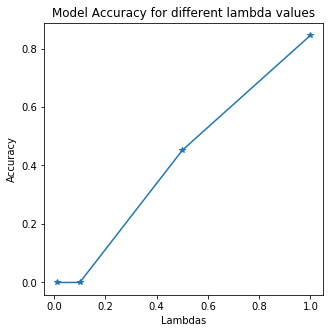

In [83]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(lmds, accuracies_LBFGS, "*-")
plt.title("Model Accuracy for different lambda values")
plt.xlabel("Lambdas")
plt.ylabel("Accuracy")
plt.savefig('Results/Testing L-BFGS mnist.png')
plt.show()

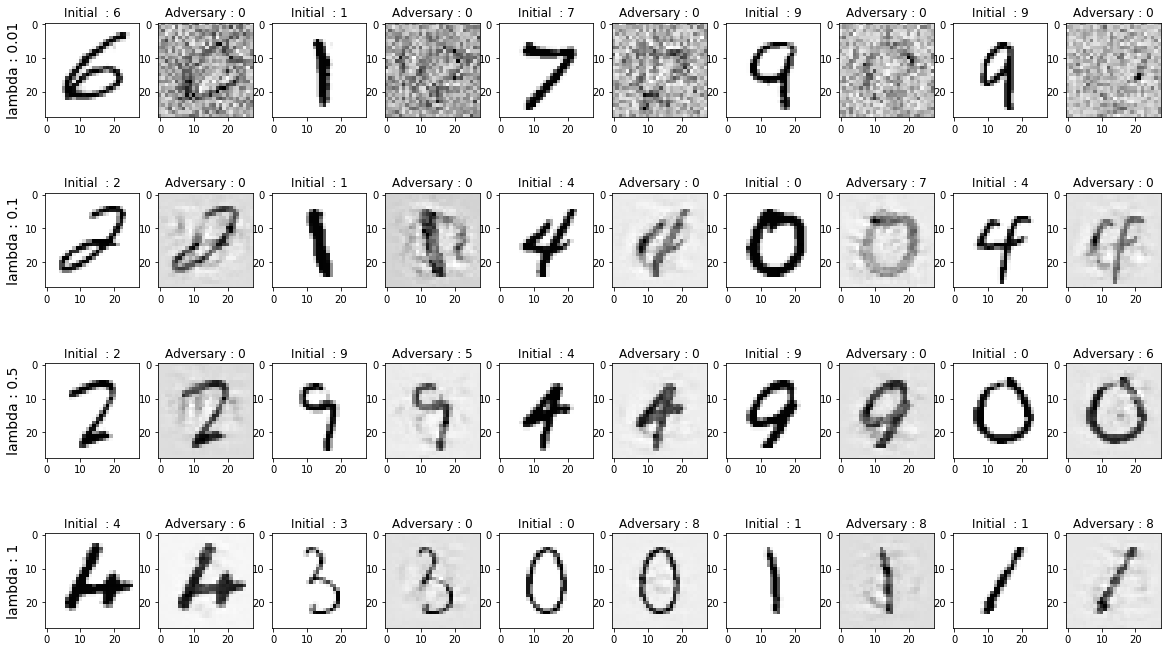

In [80]:
fig , axs = plt.subplots(nrows=len(lmds), ncols=len(examples_LBFGS[0])*2,figsize=(20,12))

for i , lmd in enumerate(lmds):
    for j in range(0,len(examples_LBFGS[0])):
        original, adversary, init_pred , final_pred = examples_LBFGS[i][j]
        axs[i, 2*j].imshow(original,cmap='Greys')
        axs[i,0].set_ylabel("lambda : {}".format(lmd), fontsize=14)
        axs[i, 2*j].set_title('Initial  : {}'.format(init_pred.item()))
        axs[i, 2*j+1].imshow(adversary,cmap='Greys')
        axs[i, 2*j+1].set_title('Adversary : {}'.format(final_pred.item()))
        
plt.savefig('Results/Exemples LBFGS mnist.png')

In [46]:
# Write explanation

# Defense

## Binary threshold

The main idea is to get rid of the noise in the image before infering the class. This would take care of the adversarial exemple.

In [28]:
accuracies_LBFGS_binary = []
examples_LBFGS_binary = []
lmds =[0.01,0.1, 0.5,1]

# Run test for each lambda
for lmd in lmds:
    acc, ex = test_LBFGS_binary_mnist(model, device, test_loader, lmd)
    accuracies_LBFGS_binary.append(acc)
    examples_LBFGS_binary.append(ex)






Lambda = 0.01:   0%|          | 0/10000 [00:00<?, ?it/s]




Lambda = 0.01:   0%|          | 1/10000 [00:00<53:15,  3.13it/s]




Lambda = 0.01:   0%|          | 2/10000 [00:00<53:14,  3.13it/s]




Lambda = 0.01:   0%|          | 3/10000 [00:00<53:12,  3.13it/s]




Lambda = 0.01:   0%|          | 4/10000 [00:01<53:08,  3.13it/s]




Lambda = 0.01:   0%|          | 5/10000 [00:01<53:04,  3.14it/s]




Lambda = 0.01:   0%|          | 6/10000 [00:01<53:30,  3.11it/s]




Lambda = 0.01:   0%|          | 7/10000 [00:02<53:22,  3.12it/s]




Lambda = 0.01:   0%|          | 8/10000 [00:02<53:13,  3.13it/s]




Lambda = 0.01:   0%|          | 9/10000 [00:02<53:06,  3.14it/s]




Lambda = 0.01:   0%|          | 10/10000 [00:03<53:00,  3.14it/s]




Lambda = 0.01:   0%|          | 11/10000 [00:03<52:56,  3.14it/s]




Lambda = 0.01:   0%|          | 12/10000 [00:03<53:36,  3.10it/s]




Lambda = 0.01:   0%|          | 13/10000 [00:04<54:07,  3.08it/s]




Lambda = 0.01:   0%|          | 1

Bad exemple







Lambda = 0.01:   1%|          | 110/10000 [00:35<46:00,  3.58it/s]




Lambda = 0.01:   1%|          | 111/10000 [00:35<47:59,  3.43it/s]




Lambda = 0.01:   1%|          | 112/10000 [00:35<49:32,  3.33it/s]




Lambda = 0.01:   1%|          | 113/10000 [00:36<51:15,  3.21it/s]




Lambda = 0.01:   1%|          | 114/10000 [00:36<51:42,  3.19it/s]




Lambda = 0.01:   1%|          | 115/10000 [00:36<53:04,  3.10it/s]




Lambda = 0.01:   1%|          | 116/10000 [00:37<52:55,  3.11it/s]




Lambda = 0.01:   1%|          | 117/10000 [00:37<53:28,  3.08it/s]




Lambda = 0.01:   1%|          | 118/10000 [00:37<53:29,  3.08it/s]




Lambda = 0.01:   1%|          | 119/10000 [00:38<53:09,  3.10it/s]




Lambda = 0.01:   1%|          | 120/10000 [00:38<53:22,  3.08it/s]




Lambda = 0.01:   1%|          | 121/10000 [00:38<54:18,  3.03it/s]




Lambda = 0.01:   1%|          | 122/10000 [00:39<54:23,  3.03it/s]

Bad exemple







Lambda = 0.01:   1%|          | 124/10000 [00:39<46:11,  3.56it/s]




Lambda = 0.01:   1%|▏         | 125/10000 [00:39<48:03,  3.42it/s]




Lambda = 0.01:   1%|▏         | 126/10000 [00:40<49:21,  3.33it/s]




Lambda = 0.01:   1%|▏         | 127/10000 [00:40<50:15,  3.27it/s]




Lambda = 0.01:   1%|▏         | 128/10000 [00:40<51:14,  3.21it/s]




Lambda = 0.01:   1%|▏         | 129/10000 [00:41<52:23,  3.14it/s]




Lambda = 0.01:   1%|▏         | 130/10000 [00:41<52:41,  3.12it/s]




Lambda = 0.01:   1%|▏         | 131/10000 [00:41<52:45,  3.12it/s]




Lambda = 0.01:   1%|▏         | 132/10000 [00:42<52:41,  3.12it/s]




Lambda = 0.01:   1%|▏         | 133/10000 [00:42<52:41,  3.12it/s]




Lambda = 0.01:   1%|▏         | 134/10000 [00:42<52:42,  3.12it/s]




Lambda = 0.01:   1%|▏         | 135/10000 [00:43<53:17,  3.08it/s]




Lambda = 0.01:   1%|▏         | 136/10000 [00:43<53:37,  3.07it/s]




Lambda = 0.01:   1%|▏         | 137/10000 [00:43<53:16,  3.09it/s]




L

Bad exemple







Lambda = 0.01:   1%|▏         | 140/10000 [00:44<44:58,  3.65it/s]




Lambda = 0.01:   1%|▏         | 141/10000 [00:44<47:40,  3.45it/s]




Lambda = 0.01:   1%|▏         | 142/10000 [00:45<50:21,  3.26it/s]




Lambda = 0.01:   1%|▏         | 143/10000 [00:45<51:35,  3.18it/s]




Lambda = 0.01:   1%|▏         | 144/10000 [00:45<52:21,  3.14it/s]

Bad exemple







Lambda = 0.01:   1%|▏         | 146/10000 [00:46<44:33,  3.69it/s]




Lambda = 0.01:   1%|▏         | 147/10000 [00:46<47:30,  3.46it/s]




Lambda = 0.01:   1%|▏         | 148/10000 [00:46<48:57,  3.35it/s]




Lambda = 0.01:   1%|▏         | 149/10000 [00:47<50:34,  3.25it/s]




Lambda = 0.01:   2%|▏         | 150/10000 [00:47<51:49,  3.17it/s]




Lambda = 0.01:   2%|▏         | 151/10000 [00:47<52:14,  3.14it/s]




Lambda = 0.01:   2%|▏         | 152/10000 [00:48<52:52,  3.10it/s]




Lambda = 0.01:   2%|▏         | 153/10000 [00:48<53:15,  3.08it/s]




Lambda = 0.01:   2%|▏         | 154/10000 [00:48<52:56,  3.10it/s]




Lambda = 0.01:   2%|▏         | 155/10000 [00:49<52:58,  3.10it/s]




Lambda = 0.01:   2%|▏         | 156/10000 [00:49<53:31,  3.07it/s]




Lambda = 0.01:   2%|▏         | 157/10000 [00:49<53:12,  3.08it/s]




Lambda = 0.01:   2%|▏         | 158/10000 [00:49<52:50,  3.10it/s]




Lambda = 0.01:   2%|▏         | 159/10000 [00:50<52:40,  3.11it/s]




L

Bad exemple







Lambda = 0.01:   3%|▎         | 253/10000 [01:20<44:31,  3.65it/s]




Lambda = 0.01:   3%|▎         | 254/10000 [01:21<46:41,  3.48it/s]




Lambda = 0.01:   3%|▎         | 255/10000 [01:21<48:12,  3.37it/s]




Lambda = 0.01:   3%|▎         | 256/10000 [01:21<49:13,  3.30it/s]




Lambda = 0.01:   3%|▎         | 257/10000 [01:22<50:12,  3.23it/s]




Lambda = 0.01:   3%|▎         | 258/10000 [01:22<50:42,  3.20it/s]




Lambda = 0.01:   3%|▎         | 259/10000 [01:22<50:59,  3.18it/s]




Lambda = 0.01:   3%|▎         | 260/10000 [01:23<51:10,  3.17it/s]




Lambda = 0.01:   3%|▎         | 261/10000 [01:23<51:39,  3.14it/s]




Lambda = 0.01:   3%|▎         | 262/10000 [01:23<52:15,  3.11it/s]




Lambda = 0.01:   3%|▎         | 263/10000 [01:24<52:33,  3.09it/s]




Lambda = 0.01:   3%|▎         | 264/10000 [01:24<52:49,  3.07it/s]




Lambda = 0.01:   3%|▎         | 265/10000 [01:24<52:27,  3.09it/s]




Lambda = 0.01:   3%|▎         | 266/10000 [01:25<52:50,  3.07it/s]




L

Bad exemple
Bad exemple







Lambda = 0.01:   3%|▎         | 307/10000 [01:37<41:56,  3.85it/s]




Lambda = 0.01:   3%|▎         | 308/10000 [01:38<45:25,  3.56it/s]




Lambda = 0.01:   3%|▎         | 309/10000 [01:38<47:35,  3.39it/s]




Lambda = 0.01:   3%|▎         | 310/10000 [01:38<49:55,  3.23it/s]




Lambda = 0.01:   3%|▎         | 311/10000 [01:39<50:35,  3.19it/s]




Lambda = 0.01:   3%|▎         | 312/10000 [01:39<50:51,  3.17it/s]




Lambda = 0.01:   3%|▎         | 313/10000 [01:39<51:02,  3.16it/s]




Lambda = 0.01:   3%|▎         | 314/10000 [01:40<51:07,  3.16it/s]




Lambda = 0.01:   3%|▎         | 315/10000 [01:40<51:23,  3.14it/s]




Lambda = 0.01:   3%|▎         | 316/10000 [01:40<51:21,  3.14it/s]




Lambda = 0.01:   3%|▎         | 317/10000 [01:41<52:23,  3.08it/s]




Lambda = 0.01:   3%|▎         | 318/10000 [01:41<52:45,  3.06it/s]




Lambda = 0.01:   3%|▎         | 319/10000 [01:41<53:00,  3.04it/s]




Lambda = 0.01:   3%|▎         | 320/10000 [01:42<53:11,  3.03it/s]




L

Bad exemple







Lambda = 0.01:   4%|▍         | 390/10000 [02:04<43:56,  3.65it/s]




Lambda = 0.01:   4%|▍         | 391/10000 [02:04<46:20,  3.46it/s]




Lambda = 0.01:   4%|▍         | 392/10000 [02:04<47:45,  3.35it/s]




Lambda = 0.01:   4%|▍         | 393/10000 [02:05<49:00,  3.27it/s]




Lambda = 0.01:   4%|▍         | 394/10000 [02:05<50:44,  3.16it/s]




Lambda = 0.01:   4%|▍         | 395/10000 [02:05<51:12,  3.13it/s]




Lambda = 0.01:   4%|▍         | 396/10000 [02:06<51:45,  3.09it/s]




Lambda = 0.01:   4%|▍         | 397/10000 [02:06<52:08,  3.07it/s]




Lambda = 0.01:   4%|▍         | 398/10000 [02:06<52:24,  3.05it/s]




Lambda = 0.01:   4%|▍         | 399/10000 [02:07<52:37,  3.04it/s]




Lambda = 0.01:   4%|▍         | 400/10000 [02:07<52:48,  3.03it/s]




Lambda = 0.01:   4%|▍         | 401/10000 [02:07<52:38,  3.04it/s]




Lambda = 0.01:   4%|▍         | 402/10000 [02:08<52:23,  3.05it/s]




Lambda = 0.01:   4%|▍         | 403/10000 [02:08<51:57,  3.08it/s]




L

Bad exemple







Lambda = 0.01:   4%|▍         | 428/10000 [02:16<44:05,  3.62it/s]




Lambda = 0.01:   4%|▍         | 429/10000 [02:16<46:06,  3.46it/s]




Lambda = 0.01:   4%|▍         | 430/10000 [02:17<47:32,  3.35it/s]




Lambda = 0.01:   4%|▍         | 431/10000 [02:17<48:30,  3.29it/s]




Lambda = 0.01:   4%|▍         | 432/10000 [02:17<49:10,  3.24it/s]




Lambda = 0.01:   4%|▍         | 433/10000 [02:17<50:15,  3.17it/s]




Lambda = 0.01:   4%|▍         | 434/10000 [02:18<51:08,  3.12it/s]




Lambda = 0.01:   4%|▍         | 435/10000 [02:18<50:58,  3.13it/s]




Lambda = 0.01:   4%|▍         | 436/10000 [02:18<50:56,  3.13it/s]




Lambda = 0.01:   4%|▍         | 437/10000 [02:19<50:52,  3.13it/s]




Lambda = 0.01:   4%|▍         | 438/10000 [02:19<50:46,  3.14it/s]




Lambda = 0.01:   4%|▍         | 439/10000 [02:19<51:14,  3.11it/s]




Lambda = 0.01:   4%|▍         | 440/10000 [02:20<51:13,  3.11it/s]




Lambda = 0.01:   4%|▍         | 441/10000 [02:20<51:02,  3.12it/s]




L

Bad exemple







Lambda = 0.01:   4%|▍         | 449/10000 [02:22<43:50,  3.63it/s]




Lambda = 0.01:   4%|▍         | 450/10000 [02:23<45:52,  3.47it/s]




Lambda = 0.01:   5%|▍         | 451/10000 [02:23<47:18,  3.36it/s]




Lambda = 0.01:   5%|▍         | 452/10000 [02:23<48:16,  3.30it/s]




Lambda = 0.01:   5%|▍         | 453/10000 [02:24<49:25,  3.22it/s]




Lambda = 0.01:   5%|▍         | 454/10000 [02:24<50:25,  3.16it/s]




Lambda = 0.01:   5%|▍         | 455/10000 [02:24<50:44,  3.13it/s]




Lambda = 0.01:   5%|▍         | 456/10000 [02:25<50:39,  3.14it/s]




Lambda = 0.01:   5%|▍         | 457/10000 [02:25<50:38,  3.14it/s]




Lambda = 0.01:   5%|▍         | 458/10000 [02:25<51:02,  3.12it/s]




Lambda = 0.01:   5%|▍         | 459/10000 [02:26<50:55,  3.12it/s]




Lambda = 0.01:   5%|▍         | 460/10000 [02:26<51:41,  3.08it/s]




Lambda = 0.01:   5%|▍         | 461/10000 [02:26<51:58,  3.06it/s]




Lambda = 0.01:   5%|▍         | 462/10000 [02:27<51:39,  3.08it/s]




L

Bad exemple







Lambda = 0.01:   5%|▍         | 482/10000 [02:33<43:31,  3.65it/s]




Lambda = 0.01:   5%|▍         | 483/10000 [02:33<45:36,  3.48it/s]




Lambda = 0.01:   5%|▍         | 484/10000 [02:33<47:04,  3.37it/s]




Lambda = 0.01:   5%|▍         | 485/10000 [02:34<48:05,  3.30it/s]




Lambda = 0.01:   5%|▍         | 486/10000 [02:34<49:23,  3.21it/s]




Lambda = 0.01:   5%|▍         | 487/10000 [02:34<50:20,  3.15it/s]




Lambda = 0.01:   5%|▍         | 488/10000 [02:35<50:20,  3.15it/s]




Lambda = 0.01:   5%|▍         | 489/10000 [02:35<50:20,  3.15it/s]




Lambda = 0.01:   5%|▍         | 490/10000 [02:35<50:19,  3.15it/s]




Lambda = 0.01:   5%|▍         | 491/10000 [02:36<50:18,  3.15it/s]




Lambda = 0.01:   5%|▍         | 492/10000 [02:36<50:19,  3.15it/s]




Lambda = 0.01:   5%|▍         | 493/10000 [02:36<51:30,  3.08it/s]




Lambda = 0.01:   5%|▍         | 494/10000 [02:37<51:13,  3.09it/s]




Lambda = 0.01:   5%|▍         | 495/10000 [02:37<51:13,  3.09it/s]




L

Bad exemple







Lambda = 0.01:   6%|▌         | 551/10000 [02:55<43:50,  3.59it/s]




Lambda = 0.01:   6%|▌         | 552/10000 [02:55<46:20,  3.40it/s]




Lambda = 0.01:   6%|▌         | 553/10000 [02:55<48:09,  3.27it/s]




Lambda = 0.01:   6%|▌         | 554/10000 [02:56<49:22,  3.19it/s]




Lambda = 0.01:   6%|▌         | 555/10000 [02:56<49:40,  3.17it/s]




Lambda = 0.01:   6%|▌         | 556/10000 [02:56<50:16,  3.13it/s]




Lambda = 0.01:   6%|▌         | 557/10000 [02:57<50:57,  3.09it/s]




Lambda = 0.01:   6%|▌         | 558/10000 [02:57<50:42,  3.10it/s]




Lambda = 0.01:   6%|▌         | 559/10000 [02:57<50:31,  3.11it/s]




Lambda = 0.01:   6%|▌         | 560/10000 [02:58<50:38,  3.11it/s]




Lambda = 0.01:   6%|▌         | 561/10000 [02:58<50:49,  3.10it/s]




Lambda = 0.01:   6%|▌         | 562/10000 [02:58<51:13,  3.07it/s]




Lambda = 0.01:   6%|▌         | 563/10000 [02:59<50:53,  3.09it/s]




Lambda = 0.01:   6%|▌         | 564/10000 [02:59<51:12,  3.07it/s]




L

Bad exemple
Bad exemple







Lambda = 0.01:   6%|▌         | 605/10000 [03:12<40:35,  3.86it/s]

Bad exemple







Lambda = 0.01:   6%|▌         | 607/10000 [03:12<35:56,  4.36it/s]




Lambda = 0.01:   6%|▌         | 608/10000 [03:12<40:04,  3.91it/s]




Lambda = 0.01:   6%|▌         | 609/10000 [03:12<42:59,  3.64it/s]




Lambda = 0.01:   6%|▌         | 610/10000 [03:13<45:03,  3.47it/s]




Lambda = 0.01:   6%|▌         | 611/10000 [03:13<47:02,  3.33it/s]




Lambda = 0.01:   6%|▌         | 612/10000 [03:13<47:50,  3.27it/s]




Lambda = 0.01:   6%|▌         | 613/10000 [03:14<48:23,  3.23it/s]




Lambda = 0.01:   6%|▌         | 614/10000 [03:14<48:45,  3.21it/s]




Lambda = 0.01:   6%|▌         | 615/10000 [03:14<49:03,  3.19it/s]




Lambda = 0.01:   6%|▌         | 616/10000 [03:15<49:17,  3.17it/s]




Lambda = 0.01:   6%|▌         | 617/10000 [03:15<49:21,  3.17it/s]




Lambda = 0.01:   6%|▌         | 618/10000 [03:15<50:05,  3.12it/s]




Lambda = 0.01:   6%|▌         | 619/10000 [03:16<49:56,  3.13it/s]




Lambda = 0.01:   6%|▌         | 620/10000 [03:16<50:10,  3.12it/s]




L

Bad exemple







Lambda = 0.01:   6%|▋         | 646/10000 [03:24<43:49,  3.56it/s]




Lambda = 0.01:   6%|▋         | 647/10000 [03:24<46:14,  3.37it/s]




Lambda = 0.01:   6%|▋         | 648/10000 [03:25<47:55,  3.25it/s]




Lambda = 0.01:   6%|▋         | 649/10000 [03:25<49:22,  3.16it/s]

Bad exemple







Lambda = 0.01:   7%|▋         | 651/10000 [03:25<42:36,  3.66it/s]




Lambda = 0.01:   7%|▋         | 652/10000 [03:26<44:47,  3.48it/s]




Lambda = 0.01:   7%|▋         | 653/10000 [03:26<46:52,  3.32it/s]




Lambda = 0.01:   7%|▋         | 654/10000 [03:26<47:39,  3.27it/s]




Lambda = 0.01:   7%|▋         | 655/10000 [03:27<48:13,  3.23it/s]




Lambda = 0.01:   7%|▋         | 656/10000 [03:27<48:33,  3.21it/s]




Lambda = 0.01:   7%|▋         | 657/10000 [03:27<49:31,  3.14it/s]




Lambda = 0.01:   7%|▋         | 658/10000 [03:28<50:01,  3.11it/s]




Lambda = 0.01:   7%|▋         | 659/10000 [03:28<49:55,  3.12it/s]




Lambda = 0.01:   7%|▋         | 660/10000 [03:28<49:49,  3.12it/s]




Lambda = 0.01:   7%|▋         | 661/10000 [03:29<50:19,  3.09it/s]




Lambda = 0.01:   7%|▋         | 662/10000 [03:29<50:28,  3.08it/s]




Lambda = 0.01:   7%|▋         | 663/10000 [03:29<50:08,  3.10it/s]




Lambda = 0.01:   7%|▋         | 664/10000 [03:30<50:32,  3.08it/s]




L

Bad exemple







Lambda = 0.01:   7%|▋         | 738/10000 [03:53<42:45,  3.61it/s]




Lambda = 0.01:   7%|▋         | 739/10000 [03:54<44:38,  3.46it/s]




Lambda = 0.01:   7%|▋         | 740/10000 [03:54<46:00,  3.35it/s]




Lambda = 0.01:   7%|▋         | 741/10000 [03:54<47:57,  3.22it/s]




Lambda = 0.01:   7%|▋         | 742/10000 [03:55<48:18,  3.19it/s]




Lambda = 0.01:   7%|▋         | 743/10000 [03:55<48:33,  3.18it/s]




Lambda = 0.01:   7%|▋         | 744/10000 [03:55<48:47,  3.16it/s]




Lambda = 0.01:   7%|▋         | 745/10000 [03:56<48:56,  3.15it/s]

Bad exemple







Lambda = 0.01:   7%|▋         | 747/10000 [03:56<41:55,  3.68it/s]




Lambda = 0.01:   7%|▋         | 748/10000 [03:56<44:45,  3.45it/s]




Lambda = 0.01:   7%|▋         | 749/10000 [03:57<46:34,  3.31it/s]




Lambda = 0.01:   8%|▊         | 750/10000 [03:57<47:17,  3.26it/s]




Lambda = 0.01:   8%|▊         | 751/10000 [03:57<47:47,  3.23it/s]




Lambda = 0.01:   8%|▊         | 752/10000 [03:58<48:12,  3.20it/s]




Lambda = 0.01:   8%|▊         | 753/10000 [03:58<48:54,  3.15it/s]




Lambda = 0.01:   8%|▊         | 754/10000 [03:58<48:57,  3.15it/s]




Lambda = 0.01:   8%|▊         | 755/10000 [03:59<49:26,  3.12it/s]




Lambda = 0.01:   8%|▊         | 756/10000 [03:59<49:18,  3.12it/s]




Lambda = 0.01:   8%|▊         | 757/10000 [03:59<49:14,  3.13it/s]




Lambda = 0.01:   8%|▊         | 758/10000 [04:00<49:10,  3.13it/s]




Lambda = 0.01:   8%|▊         | 759/10000 [04:00<49:06,  3.14it/s]




Lambda = 0.01:   8%|▊         | 760/10000 [04:00<49:04,  3.14it/s]




L

Bad exemple







Lambda = 0.01:   9%|▊         | 852/10000 [04:30<41:54,  3.64it/s]




Lambda = 0.01:   9%|▊         | 853/10000 [04:30<44:12,  3.45it/s]




Lambda = 0.01:   9%|▊         | 854/10000 [04:31<45:29,  3.35it/s]




Lambda = 0.01:   9%|▊         | 855/10000 [04:31<46:35,  3.27it/s]




Lambda = 0.01:   9%|▊         | 856/10000 [04:31<47:48,  3.19it/s]




Lambda = 0.01:   9%|▊         | 857/10000 [04:32<49:07,  3.10it/s]




Lambda = 0.01:   9%|▊         | 858/10000 [04:32<49:14,  3.09it/s]




Lambda = 0.01:   9%|▊         | 859/10000 [04:32<49:38,  3.07it/s]




Lambda = 0.01:   9%|▊         | 860/10000 [04:33<49:43,  3.06it/s]




Lambda = 0.01:   9%|▊         | 861/10000 [04:33<49:57,  3.05it/s]




Lambda = 0.01:   9%|▊         | 862/10000 [04:33<50:06,  3.04it/s]




Lambda = 0.01:   9%|▊         | 863/10000 [04:33<49:44,  3.06it/s]




Lambda = 0.01:   9%|▊         | 864/10000 [04:34<50:22,  3.02it/s]




Lambda = 0.01:   9%|▊         | 865/10000 [04:34<49:46,  3.06it/s]




L

Bad exemple







Lambda = 0.01:   9%|▉         | 902/10000 [04:46<41:39,  3.64it/s]




Lambda = 0.01:   9%|▉         | 903/10000 [04:46<44:05,  3.44it/s]




Lambda = 0.01:   9%|▉         | 904/10000 [04:46<45:59,  3.30it/s]




Lambda = 0.01:   9%|▉         | 905/10000 [04:47<47:18,  3.20it/s]




Lambda = 0.01:   9%|▉         | 906/10000 [04:47<48:12,  3.14it/s]




Lambda = 0.01:   9%|▉         | 907/10000 [04:47<48:51,  3.10it/s]




Lambda = 0.01:   9%|▉         | 908/10000 [04:48<48:48,  3.10it/s]




Lambda = 0.01:   9%|▉         | 909/10000 [04:48<49:38,  3.05it/s]




Lambda = 0.01:   9%|▉         | 910/10000 [04:48<49:52,  3.04it/s]




Lambda = 0.01:   9%|▉         | 911/10000 [04:49<50:00,  3.03it/s]




Lambda = 0.01:   9%|▉         | 912/10000 [04:49<50:06,  3.02it/s]




Lambda = 0.01:   9%|▉         | 913/10000 [04:49<50:10,  3.02it/s]




Lambda = 0.01:   9%|▉         | 914/10000 [04:50<50:13,  3.01it/s]




Lambda = 0.01:   9%|▉         | 915/10000 [04:50<50:17,  3.01it/s]




L

Bad exemple








Lambda = 0.1:   1%|          | 51/10000 [00:16<46:04,  3.60it/s]





Lambda = 0.1:   1%|          | 52/10000 [00:16<48:05,  3.45it/s]





Lambda = 0.1:   1%|          | 53/10000 [00:16<49:28,  3.35it/s]





Lambda = 0.1:   1%|          | 54/10000 [00:17<50:31,  3.28it/s]





Lambda = 0.1:   1%|          | 55/10000 [00:17<51:53,  3.19it/s]





Lambda = 0.1:   1%|          | 56/10000 [00:17<53:07,  3.12it/s]





Lambda = 0.1:   1%|          | 57/10000 [00:18<53:03,  3.12it/s]





Lambda = 0.1:   1%|          | 58/10000 [00:18<53:42,  3.09it/s]





Lambda = 0.1:   1%|          | 59/10000 [00:18<53:27,  3.10it/s]





Lambda = 0.1:   1%|          | 60/10000 [00:19<53:17,  3.11it/s]





Lambda = 0.1:   1%|          | 61/10000 [00:19<53:10,  3.11it/s]





Lambda = 0.1:   1%|          | 62/10000 [00:19<53:20,  3.11it/s]





Lambda = 0.1:   1%|          | 63/10000 [00:20<53:29,  3.10it/s]





Lambda = 0.1:   1%|          | 64/10000 [00:20<53:17,  3.11it/s]





Lambda = 0.1: 

Bad exemple








Lambda = 0.1:   1%|          | 109/10000 [00:34<45:23,  3.63it/s]





Lambda = 0.1:   1%|          | 110/10000 [00:35<47:36,  3.46it/s]





Lambda = 0.1:   1%|          | 111/10000 [00:35<49:04,  3.36it/s]





Lambda = 0.1:   1%|          | 112/10000 [00:35<50:20,  3.27it/s]





Lambda = 0.1:   1%|          | 113/10000 [00:36<50:59,  3.23it/s]





Lambda = 0.1:   1%|          | 114/10000 [00:36<52:30,  3.14it/s]





Lambda = 0.1:   1%|          | 115/10000 [00:36<52:31,  3.14it/s]





Lambda = 0.1:   1%|          | 116/10000 [00:37<52:30,  3.14it/s]





Lambda = 0.1:   1%|          | 117/10000 [00:37<52:38,  3.13it/s]





Lambda = 0.1:   1%|          | 118/10000 [00:37<53:14,  3.09it/s]





Lambda = 0.1:   1%|          | 119/10000 [00:37<53:00,  3.11it/s]





Lambda = 0.1:   1%|          | 120/10000 [00:38<53:16,  3.09it/s]





Lambda = 0.1:   1%|          | 121/10000 [00:38<54:00,  3.05it/s]





Lambda = 0.1:   1%|          | 122/10000 [00:38<53:53,  3.06it/s]







Bad exemple








Lambda = 0.1:   1%|▏         | 143/10000 [00:45<45:21,  3.62it/s]





Lambda = 0.1:   1%|▏         | 144/10000 [00:45<47:25,  3.46it/s]





Lambda = 0.1:   1%|▏         | 145/10000 [00:46<48:52,  3.36it/s]





Lambda = 0.1:   1%|▏         | 146/10000 [00:46<50:34,  3.25it/s]





Lambda = 0.1:   1%|▏         | 147/10000 [00:46<52:01,  3.16it/s]





Lambda = 0.1:   1%|▏         | 148/10000 [00:47<52:22,  3.14it/s]





Lambda = 0.1:   1%|▏         | 149/10000 [00:47<53:01,  3.10it/s]





Lambda = 0.1:   2%|▏         | 150/10000 [00:47<53:19,  3.08it/s]





Lambda = 0.1:   2%|▏         | 151/10000 [00:48<52:57,  3.10it/s]





Lambda = 0.1:   2%|▏         | 152/10000 [00:48<52:43,  3.11it/s]





Lambda = 0.1:   2%|▏         | 153/10000 [00:48<53:20,  3.08it/s]





Lambda = 0.1:   2%|▏         | 154/10000 [00:49<53:00,  3.10it/s]





Lambda = 0.1:   2%|▏         | 155/10000 [00:49<53:28,  3.07it/s]





Lambda = 0.1:   2%|▏         | 156/10000 [00:49<53:07,  3.09it/s]







Bad exemple








Lambda = 0.1:   2%|▏         | 173/10000 [00:54<44:27,  3.68it/s]





Lambda = 0.1:   2%|▏         | 174/10000 [00:55<47:37,  3.44it/s]





Lambda = 0.1:   2%|▏         | 175/10000 [00:55<48:58,  3.34it/s]





Lambda = 0.1:   2%|▏         | 176/10000 [00:55<49:54,  3.28it/s]





Lambda = 0.1:   2%|▏         | 177/10000 [00:56<51:04,  3.21it/s]





Lambda = 0.1:   2%|▏         | 178/10000 [00:56<52:01,  3.15it/s]





Lambda = 0.1:   2%|▏         | 179/10000 [00:56<52:42,  3.11it/s]





Lambda = 0.1:   2%|▏         | 180/10000 [00:57<53:21,  3.07it/s]





Lambda = 0.1:   2%|▏         | 181/10000 [00:57<52:59,  3.09it/s]





Lambda = 0.1:   2%|▏         | 182/10000 [00:57<52:43,  3.10it/s]





Lambda = 0.1:   2%|▏         | 183/10000 [00:58<52:34,  3.11it/s]





Lambda = 0.1:   2%|▏         | 184/10000 [00:58<52:25,  3.12it/s]





Lambda = 0.1:   2%|▏         | 185/10000 [00:58<52:18,  3.13it/s]





Lambda = 0.1:   2%|▏         | 186/10000 [00:59<52:47,  3.10it/s]







Bad exemple








Lambda = 0.1:   2%|▏         | 203/10000 [01:04<45:28,  3.59it/s]





Lambda = 0.1:   2%|▏         | 204/10000 [01:04<47:22,  3.45it/s]





Lambda = 0.1:   2%|▏         | 205/10000 [01:04<48:41,  3.35it/s]





Lambda = 0.1:   2%|▏         | 206/10000 [01:05<50:19,  3.24it/s]





Lambda = 0.1:   2%|▏         | 207/10000 [01:05<51:08,  3.19it/s]





Lambda = 0.1:   2%|▏         | 208/10000 [01:05<52:02,  3.14it/s]





Lambda = 0.1:   2%|▏         | 209/10000 [01:06<51:59,  3.14it/s]





Lambda = 0.1:   2%|▏         | 210/10000 [01:06<52:38,  3.10it/s]





Lambda = 0.1:   2%|▏         | 211/10000 [01:06<53:03,  3.08it/s]





Lambda = 0.1:   2%|▏         | 212/10000 [01:07<53:17,  3.06it/s]





Lambda = 0.1:   2%|▏         | 213/10000 [01:07<53:58,  3.02it/s]





Lambda = 0.1:   2%|▏         | 214/10000 [01:07<54:02,  3.02it/s]





Lambda = 0.1:   2%|▏         | 215/10000 [01:08<54:01,  3.02it/s]





Lambda = 0.1:   2%|▏         | 216/10000 [01:08<54:03,  3.02it/s]







Bad exemple








Lambda = 0.1:   2%|▏         | 223/10000 [01:10<45:35,  3.57it/s]





Lambda = 0.1:   2%|▏         | 224/10000 [01:10<47:26,  3.43it/s]





Lambda = 0.1:   2%|▏         | 225/10000 [01:11<48:48,  3.34it/s]





Lambda = 0.1:   2%|▏         | 226/10000 [01:11<50:44,  3.21it/s]





Lambda = 0.1:   2%|▏         | 227/10000 [01:11<51:04,  3.19it/s]





Lambda = 0.1:   2%|▏         | 228/10000 [01:12<51:18,  3.17it/s]





Lambda = 0.1:   2%|▏         | 229/10000 [01:12<51:27,  3.16it/s]





Lambda = 0.1:   2%|▏         | 230/10000 [01:12<51:34,  3.16it/s]





Lambda = 0.1:   2%|▏         | 231/10000 [01:13<51:37,  3.15it/s]





Lambda = 0.1:   2%|▏         | 232/10000 [01:13<51:39,  3.15it/s]





Lambda = 0.1:   2%|▏         | 233/10000 [01:13<52:14,  3.12it/s]





Lambda = 0.1:   2%|▏         | 234/10000 [01:14<52:05,  3.12it/s]





Lambda = 0.1:   2%|▏         | 235/10000 [01:14<51:58,  3.13it/s]





Lambda = 0.1:   2%|▏         | 236/10000 [01:14<51:57,  3.13it/s]







Bad exemple








Lambda = 0.1:   3%|▎         | 315/10000 [01:39<44:13,  3.65it/s]





Lambda = 0.1:   3%|▎         | 316/10000 [01:40<46:20,  3.48it/s]





Lambda = 0.1:   3%|▎         | 317/10000 [01:40<49:01,  3.29it/s]





Lambda = 0.1:   3%|▎         | 318/10000 [01:40<49:44,  3.24it/s]





Lambda = 0.1:   3%|▎         | 319/10000 [01:41<50:13,  3.21it/s]





Lambda = 0.1:   3%|▎         | 320/10000 [01:41<50:31,  3.19it/s]





Lambda = 0.1:   3%|▎         | 321/10000 [01:41<51:26,  3.14it/s]





Lambda = 0.1:   3%|▎         | 322/10000 [01:42<51:23,  3.14it/s]





Lambda = 0.1:   3%|▎         | 323/10000 [01:42<52:01,  3.10it/s]





Lambda = 0.1:   3%|▎         | 324/10000 [01:42<52:24,  3.08it/s]





Lambda = 0.1:   3%|▎         | 325/10000 [01:43<52:06,  3.09it/s]





Lambda = 0.1:   3%|▎         | 326/10000 [01:43<51:51,  3.11it/s]





Lambda = 0.1:   3%|▎         | 327/10000 [01:43<51:38,  3.12it/s]





Lambda = 0.1:   3%|▎         | 328/10000 [01:44<51:31,  3.13it/s]







Bad exemple








Lambda = 0.1:   3%|▎         | 336/10000 [01:46<49:51,  3.23it/s]





Lambda = 0.1:   3%|▎         | 337/10000 [01:46<50:17,  3.20it/s]





Lambda = 0.1:   3%|▎         | 338/10000 [01:47<51:14,  3.14it/s]





Lambda = 0.1:   3%|▎         | 339/10000 [01:47<51:14,  3.14it/s]





Lambda = 0.1:   3%|▎         | 340/10000 [01:47<51:12,  3.14it/s]





Lambda = 0.1:   3%|▎         | 341/10000 [01:48<51:09,  3.15it/s]





Lambda = 0.1:   3%|▎         | 342/10000 [01:48<51:50,  3.10it/s]





Lambda = 0.1:   3%|▎         | 343/10000 [01:48<52:09,  3.09it/s]





Lambda = 0.1:   3%|▎         | 344/10000 [01:49<51:53,  3.10it/s]





Lambda = 0.1:   3%|▎         | 345/10000 [01:49<51:39,  3.11it/s]





Lambda = 0.1:   3%|▎         | 346/10000 [01:49<51:31,  3.12it/s]





Lambda = 0.1:   3%|▎         | 347/10000 [01:50<51:27,  3.13it/s]





Lambda = 0.1:   3%|▎         | 348/10000 [01:50<51:22,  3.13it/s]





Lambda = 0.1:   3%|▎         | 349/10000 [01:50<52:16,  3.08it/s]







Bad exemple








Lambda = 0.1:   5%|▍         | 489/10000 [02:35<43:51,  3.61it/s]





Lambda = 0.1:   5%|▍         | 490/10000 [02:36<46:21,  3.42it/s]





Lambda = 0.1:   5%|▍         | 491/10000 [02:36<47:33,  3.33it/s]





Lambda = 0.1:   5%|▍         | 492/10000 [02:36<48:28,  3.27it/s]





Lambda = 0.1:   5%|▍         | 493/10000 [02:37<49:04,  3.23it/s]





Lambda = 0.1:   5%|▍         | 494/10000 [02:37<49:31,  3.20it/s]





Lambda = 0.1:   5%|▍         | 495/10000 [02:37<49:48,  3.18it/s]





Lambda = 0.1:   5%|▍         | 496/10000 [02:38<50:18,  3.15it/s]





Lambda = 0.1:   5%|▍         | 497/10000 [02:38<51:25,  3.08it/s]





Lambda = 0.1:   5%|▍         | 498/10000 [02:38<51:23,  3.08it/s]





Lambda = 0.1:   5%|▍         | 499/10000 [02:39<51:07,  3.10it/s]





Lambda = 0.1:   5%|▌         | 500/10000 [02:39<50:57,  3.11it/s]





Lambda = 0.1:   5%|▌         | 501/10000 [02:39<50:50,  3.11it/s]





Lambda = 0.1:   5%|▌         | 502/10000 [02:40<51:23,  3.08it/s]







Bad exemple








Lambda = 0.1:   6%|▌         | 609/10000 [03:14<43:13,  3.62it/s]





Lambda = 0.1:   6%|▌         | 610/10000 [03:14<45:12,  3.46it/s]





Lambda = 0.1:   6%|▌         | 611/10000 [03:14<46:36,  3.36it/s]





Lambda = 0.1:   6%|▌         | 612/10000 [03:15<48:00,  3.26it/s]





Lambda = 0.1:   6%|▌         | 613/10000 [03:15<48:34,  3.22it/s]





Lambda = 0.1:   6%|▌         | 614/10000 [03:15<48:55,  3.20it/s]





Lambda = 0.1:   6%|▌         | 615/10000 [03:16<49:10,  3.18it/s]





Lambda = 0.1:   6%|▌         | 616/10000 [03:16<49:22,  3.17it/s]





Lambda = 0.1:   6%|▌         | 617/10000 [03:16<49:27,  3.16it/s]





Lambda = 0.1:   6%|▌         | 618/10000 [03:17<49:31,  3.16it/s]





Lambda = 0.1:   6%|▌         | 619/10000 [03:17<50:05,  3.12it/s]





Lambda = 0.1:   6%|▌         | 620/10000 [03:17<49:57,  3.13it/s]





Lambda = 0.1:   6%|▌         | 621/10000 [03:18<50:15,  3.11it/s]





Lambda = 0.1:   6%|▌         | 622/10000 [03:18<50:45,  3.08it/s]







Bad exemple








Lambda = 0.1:   7%|▋         | 704/10000 [03:44<42:31,  3.64it/s]





Lambda = 0.1:   7%|▋         | 705/10000 [03:45<45:02,  3.44it/s]





Lambda = 0.1:   7%|▋         | 706/10000 [03:45<46:19,  3.34it/s]





Lambda = 0.1:   7%|▋         | 707/10000 [03:45<47:09,  3.28it/s]





Lambda = 0.1:   7%|▋         | 708/10000 [03:46<48:26,  3.20it/s]





Lambda = 0.1:   7%|▋         | 709/10000 [03:46<49:28,  3.13it/s]

Bad exemple








Lambda = 0.1:   7%|▋         | 711/10000 [03:46<42:10,  3.67it/s]





Lambda = 0.1:   7%|▋         | 712/10000 [03:47<44:55,  3.45it/s]





Lambda = 0.1:   7%|▋         | 713/10000 [03:47<46:54,  3.30it/s]





Lambda = 0.1:   7%|▋         | 714/10000 [03:47<47:35,  3.25it/s]





Lambda = 0.1:   7%|▋         | 715/10000 [03:47<48:05,  3.22it/s]

Bad exemple








Lambda = 0.1:   7%|▋         | 717/10000 [03:48<41:28,  3.73it/s]





Lambda = 0.1:   7%|▋         | 718/10000 [03:48<44:05,  3.51it/s]





Lambda = 0.1:   7%|▋         | 719/10000 [03:48<46:16,  3.34it/s]





Lambda = 0.1:   7%|▋         | 720/10000 [03:49<47:17,  3.27it/s]





Lambda = 0.1:   7%|▋         | 721/10000 [03:49<47:50,  3.23it/s]





Lambda = 0.1:   7%|▋         | 722/10000 [03:49<48:12,  3.21it/s]





Lambda = 0.1:   7%|▋         | 723/10000 [03:50<48:55,  3.16it/s]





Lambda = 0.1:   7%|▋         | 724/10000 [03:50<49:34,  3.12it/s]





Lambda = 0.1:   7%|▋         | 725/10000 [03:50<49:31,  3.12it/s]





Lambda = 0.1:   7%|▋         | 726/10000 [03:51<49:26,  3.13it/s]





Lambda = 0.1:   7%|▋         | 727/10000 [03:51<49:59,  3.09it/s]





Lambda = 0.1:   7%|▋         | 728/10000 [03:51<50:21,  3.07it/s]





Lambda = 0.1:   7%|▋         | 729/10000 [03:52<50:37,  3.05it/s]





Lambda = 0.1:   7%|▋         | 730/10000 [03:52<51:12,  3.02it/s]







Bad exemple








Lambda = 0.1:   7%|▋         | 740/10000 [03:55<43:03,  3.58it/s]





Lambda = 0.1:   7%|▋         | 741/10000 [03:55<45:27,  3.40it/s]





Lambda = 0.1:   7%|▋         | 742/10000 [03:56<46:33,  3.31it/s]





Lambda = 0.1:   7%|▋         | 743/10000 [03:56<48:01,  3.21it/s]





Lambda = 0.1:   7%|▋         | 744/10000 [03:56<48:25,  3.19it/s]





Lambda = 0.1:   7%|▋         | 745/10000 [03:57<48:36,  3.17it/s]





Lambda = 0.1:   7%|▋         | 746/10000 [03:57<49:01,  3.15it/s]





Lambda = 0.1:   7%|▋         | 747/10000 [03:57<49:00,  3.15it/s]





Lambda = 0.1:   7%|▋         | 748/10000 [03:58<49:03,  3.14it/s]





Lambda = 0.1:   7%|▋         | 749/10000 [03:58<49:03,  3.14it/s]





Lambda = 0.1:   8%|▊         | 750/10000 [03:58<49:47,  3.10it/s]





Lambda = 0.1:   8%|▊         | 751/10000 [03:59<49:35,  3.11it/s]





Lambda = 0.1:   8%|▊         | 752/10000 [03:59<49:24,  3.12it/s]





Lambda = 0.1:   8%|▊         | 753/10000 [03:59<49:15,  3.13it/s]







Bad exemple








Lambda = 0.1:   9%|▊         | 854/10000 [04:32<42:27,  3.59it/s]





Lambda = 0.1:   9%|▊         | 855/10000 [04:32<44:15,  3.44it/s]





Lambda = 0.1:   9%|▊         | 856/10000 [04:32<45:32,  3.35it/s]





Lambda = 0.1:   9%|▊         | 857/10000 [04:33<46:24,  3.28it/s]





Lambda = 0.1:   9%|▊         | 858/10000 [04:33<47:00,  3.24it/s]





Lambda = 0.1:   9%|▊         | 859/10000 [04:33<47:56,  3.18it/s]





Lambda = 0.1:   9%|▊         | 860/10000 [04:34<48:09,  3.16it/s]





Lambda = 0.1:   9%|▊         | 861/10000 [04:34<48:17,  3.15it/s]





Lambda = 0.1:   9%|▊         | 862/10000 [04:34<48:20,  3.15it/s]





Lambda = 0.1:   9%|▊         | 863/10000 [04:35<49:01,  3.11it/s]





Lambda = 0.1:   9%|▊         | 864/10000 [04:35<49:30,  3.08it/s]





Lambda = 0.1:   9%|▊         | 865/10000 [04:35<49:57,  3.05it/s]





Lambda = 0.1:   9%|▊         | 866/10000 [04:36<49:44,  3.06it/s]





Lambda = 0.1:   9%|▊         | 867/10000 [04:36<49:21,  3.08it/s]







Bad exemple








Lambda = 0.1:   9%|▉         | 894/10000 [04:44<42:47,  3.55it/s]





Lambda = 0.1:   9%|▉         | 895/10000 [04:45<48:04,  3.16it/s]





Lambda = 0.1:   9%|▉         | 896/10000 [04:45<50:30,  3.00it/s]





Lambda = 0.1:   9%|▉         | 897/10000 [04:45<52:36,  2.88it/s]





Lambda = 0.1:   9%|▉         | 898/10000 [04:46<54:00,  2.81it/s]





Lambda = 0.1:   9%|▉         | 899/10000 [04:46<52:54,  2.87it/s]





Lambda = 0.1:   9%|▉         | 900/10000 [04:47<52:06,  2.91it/s]





Lambda = 0.1:   9%|▉         | 901/10000 [04:47<51:02,  2.97it/s]





Lambda = 0.1:   9%|▉         | 902/10000 [04:47<50:11,  3.02it/s]





Lambda = 0.1:   9%|▉         | 903/10000 [04:47<49:36,  3.06it/s]





Lambda = 0.1:   9%|▉         | 904/10000 [04:48<50:08,  3.02it/s]





Lambda = 0.1:   9%|▉         | 905/10000 [04:48<49:35,  3.06it/s]





Lambda = 0.1:   9%|▉         | 906/10000 [04:48<49:21,  3.07it/s]





Lambda = 0.1:   9%|▉         | 907/10000 [04:49<49:03,  3.09it/s]







Bad exemple








Lambda = 0.1:   9%|▉         | 910/10000 [04:49<41:28,  3.65it/s]





Lambda = 0.1:   9%|▉         | 911/10000 [04:50<44:07,  3.43it/s]





Lambda = 0.1:   9%|▉         | 912/10000 [04:50<45:25,  3.33it/s]





Lambda = 0.1:   9%|▉         | 913/10000 [04:50<46:19,  3.27it/s]





Lambda = 0.1:   9%|▉         | 914/10000 [04:51<47:29,  3.19it/s]





Lambda = 0.1:   9%|▉         | 915/10000 [04:51<47:42,  3.17it/s]





Lambda = 0.1:   9%|▉         | 916/10000 [04:51<48:28,  3.12it/s]





Lambda = 0.1:   9%|▉         | 917/10000 [04:52<49:10,  3.08it/s]





Lambda = 0.1:   9%|▉         | 918/10000 [04:52<48:54,  3.09it/s]





Lambda = 0.1:   9%|▉         | 919/10000 [04:52<48:42,  3.11it/s]





Lambda = 0.1:   9%|▉         | 920/10000 [04:53<48:33,  3.12it/s]





Lambda = 0.1:   9%|▉         | 921/10000 [04:53<49:05,  3.08it/s]





Lambda = 0.1:   9%|▉         | 922/10000 [04:53<48:51,  3.10it/s]





Lambda = 0.1:   9%|▉         | 923/10000 [04:54<48:42,  3.11it/s]







Bad exemple








Lambda = 0.1:   9%|▉         | 945/10000 [05:00<42:08,  3.58it/s]





Lambda = 0.1:   9%|▉         | 946/10000 [05:01<44:30,  3.39it/s]





Lambda = 0.1:   9%|▉         | 947/10000 [05:01<45:33,  3.31it/s]





Lambda = 0.1:   9%|▉         | 948/10000 [05:01<46:30,  3.24it/s]





Lambda = 0.1:   9%|▉         | 949/10000 [05:02<47:24,  3.18it/s]





Lambda = 0.1:  10%|▉         | 950/10000 [05:02<48:01,  3.14it/s]





Lambda = 0.1:  10%|▉         | 951/10000 [05:02<48:01,  3.14it/s]





Lambda = 0.1:  10%|▉         | 952/10000 [05:03<47:59,  3.14it/s]





Lambda = 0.1:  10%|▉         | 953/10000 [05:03<47:57,  3.14it/s]

Bad exemple








Lambda = 0.1:  10%|▉         | 955/10000 [05:03<40:47,  3.70it/s]





Lambda = 0.1:  10%|▉         | 956/10000 [05:04<43:36,  3.46it/s]





Lambda = 0.1:  10%|▉         | 957/10000 [05:04<45:57,  3.28it/s]





Lambda = 0.1:  10%|▉         | 958/10000 [05:04<47:49,  3.15it/s]





Lambda = 0.1:  10%|▉         | 959/10000 [05:05<47:55,  3.14it/s]





Lambda = 0.1:  10%|▉         | 960/10000 [05:05<48:32,  3.10it/s]





Lambda = 0.1:  10%|▉         | 961/10000 [05:05<48:22,  3.11it/s]





Lambda = 0.1:  10%|▉         | 962/10000 [05:06<48:50,  3.08it/s]





Lambda = 0.1:  10%|▉         | 963/10000 [05:06<48:34,  3.10it/s]





Lambda = 0.1:  10%|▉         | 964/10000 [05:06<49:38,  3.03it/s]





Lambda = 0.1:  10%|▉         | 965/10000 [05:07<49:28,  3.04it/s]





Lambda = 0.1:  10%|▉         | 966/10000 [05:07<49:35,  3.04it/s]





Lambda = 0.1:  10%|▉         | 967/10000 [05:07<49:40,  3.03it/s]





Lambda = 0.1:  10%|▉         | 968/10000 [05:08<49:08,  3.06it/s]







Bad exemple








Lambda = 0.1:  10%|▉         | 987/10000 [05:14<41:37,  3.61it/s]





Lambda = 0.1:  10%|▉         | 988/10000 [05:14<44:04,  3.41it/s]





Lambda = 0.1:  10%|▉         | 989/10000 [05:14<45:47,  3.28it/s]





Lambda = 0.1:  10%|▉         | 990/10000 [05:15<46:50,  3.21it/s]





Lambda = 0.1:  10%|▉         | 991/10000 [05:15<47:40,  3.15it/s]





Lambda = 0.1:  10%|▉         | 992/10000 [05:15<48:01,  3.13it/s]





Lambda = 0.1:  10%|▉         | 993/10000 [05:15<48:32,  3.09it/s]

Bad exemple








Lambda = 0.1:  10%|▉         | 995/10000 [05:16<41:21,  3.63it/s]





Lambda = 0.1:  10%|▉         | 996/10000 [05:16<43:16,  3.47it/s]





Lambda = 0.1:  10%|▉         | 997/10000 [05:16<44:48,  3.35it/s]





Lambda = 0.1:  10%|▉         | 998/10000 [05:17<46:40,  3.21it/s]





Lambda = 0.1:  10%|▉         | 999/10000 [05:17<47:35,  3.15it/s]





Lambda = 0.1:  10%|█         | 1000/10000 [05:17<48:15,  3.11it/s]






Lambda = 0.5:   0%|          | 0/10000 [00:00<?, ?it/s]






Lambda = 0.5:   0%|          | 1/10000 [00:00<52:49,  3.16it/s]






Lambda = 0.5:   0%|          | 2/10000 [00:00<53:04,  3.14it/s]






Lambda = 0.5:   0%|          | 3/10000 [00:00<53:40,  3.10it/s]






Lambda = 0.5:   0%|          | 4/10000 [00:01<54:40,  3.05it/s]






Lambda = 0.5:   0%|          | 5/10000 [00:01<54:52,  3.04it/s]






Lambda = 0.5:   0%|          | 6/10000 [00:01<54:59,  3.03it/s]






Lambda = 0.5:   0%|          | 7/10000 [00:02<55:07,  3.02it/s]






Lambda = 0.5: 

Bad exemple









Lambda = 0.5:   0%|          | 13/10000 [00:03<45:51,  3.63it/s]






Lambda = 0.5:   0%|          | 14/10000 [00:04<47:59,  3.47it/s]






Lambda = 0.5:   0%|          | 15/10000 [00:04<49:27,  3.37it/s]






Lambda = 0.5:   0%|          | 16/10000 [00:04<50:49,  3.27it/s]






Lambda = 0.5:   0%|          | 17/10000 [00:05<52:27,  3.17it/s]






Lambda = 0.5:   0%|          | 18/10000 [00:05<52:39,  3.16it/s]






Lambda = 0.5:   0%|          | 19/10000 [00:05<52:41,  3.16it/s]






Lambda = 0.5:   0%|          | 20/10000 [00:06<52:46,  3.15it/s]






Lambda = 0.5:   0%|          | 21/10000 [00:06<52:46,  3.15it/s]






Lambda = 0.5:   0%|          | 22/10000 [00:06<53:26,  3.11it/s]






Lambda = 0.5:   0%|          | 23/10000 [00:07<53:16,  3.12it/s]






Lambda = 0.5:   0%|          | 24/10000 [00:07<54:17,  3.06it/s]






Lambda = 0.5:   0%|          | 25/10000 [00:07<53:50,  3.09it/s]






Lambda = 0.5:   0%|          | 26/10000 [00:08<53:35,  3.10it/s]







Bad exemple









Lambda = 0.5:   2%|▏         | 158/10000 [00:50<44:39,  3.67it/s]






Lambda = 0.5:   2%|▏         | 159/10000 [00:50<48:05,  3.41it/s]






Lambda = 0.5:   2%|▏         | 160/10000 [00:51<50:03,  3.28it/s]






Lambda = 0.5:   2%|▏         | 161/10000 [00:51<50:45,  3.23it/s]






Lambda = 0.5:   2%|▏         | 162/10000 [00:51<52:02,  3.15it/s]






Lambda = 0.5:   2%|▏         | 163/10000 [00:52<52:05,  3.15it/s]






Lambda = 0.5:   2%|▏         | 164/10000 [00:52<52:09,  3.14it/s]






Lambda = 0.5:   2%|▏         | 165/10000 [00:52<52:58,  3.09it/s]






Lambda = 0.5:   2%|▏         | 166/10000 [00:53<53:23,  3.07it/s]






Lambda = 0.5:   2%|▏         | 167/10000 [00:53<53:40,  3.05it/s]






Lambda = 0.5:   2%|▏         | 168/10000 [00:53<53:21,  3.07it/s]






Lambda = 0.5:   2%|▏         | 169/10000 [00:54<52:57,  3.09it/s]






Lambda = 0.5:   2%|▏         | 170/10000 [00:54<53:09,  3.08it/s]






Lambda = 0.5:   2%|▏         | 171/10000 [00:54<53:32,  3

Bad exemple









Lambda = 0.5:   2%|▏         | 180/10000 [00:57<45:58,  3.56it/s]






Lambda = 0.5:   2%|▏         | 181/10000 [00:57<47:59,  3.41it/s]






Lambda = 0.5:   2%|▏         | 182/10000 [00:58<49:13,  3.32it/s]






Lambda = 0.5:   2%|▏         | 183/10000 [00:58<50:17,  3.25it/s]






Lambda = 0.5:   2%|▏         | 184/10000 [00:58<51:31,  3.18it/s]






Lambda = 0.5:   2%|▏         | 185/10000 [00:59<52:40,  3.11it/s]






Lambda = 0.5:   2%|▏         | 186/10000 [00:59<53:08,  3.08it/s]






Lambda = 0.5:   2%|▏         | 187/10000 [00:59<53:26,  3.06it/s]

Bad exemple









Lambda = 0.5:   2%|▏         | 189/10000 [01:00<45:31,  3.59it/s]






Lambda = 0.5:   2%|▏         | 190/10000 [01:00<47:25,  3.45it/s]






Lambda = 0.5:   2%|▏         | 191/10000 [01:00<48:48,  3.35it/s]






Lambda = 0.5:   2%|▏         | 192/10000 [01:01<50:37,  3.23it/s]






Lambda = 0.5:   2%|▏         | 193/10000 [01:01<51:01,  3.20it/s]






Lambda = 0.5:   2%|▏         | 194/10000 [01:01<51:18,  3.19it/s]






Lambda = 0.5:   2%|▏         | 195/10000 [01:01<51:28,  3.17it/s]






Lambda = 0.5:   2%|▏         | 196/10000 [01:02<51:35,  3.17it/s]






Lambda = 0.5:   2%|▏         | 197/10000 [01:02<51:43,  3.16it/s]






Lambda = 0.5:   2%|▏         | 198/10000 [01:02<51:50,  3.15it/s]






Lambda = 0.5:   2%|▏         | 199/10000 [01:03<52:52,  3.09it/s]






Lambda = 0.5:   2%|▏         | 200/10000 [01:03<53:10,  3.07it/s]






Lambda = 0.5:   2%|▏         | 201/10000 [01:03<53:19,  3.06it/s]






Lambda = 0.5:   2%|▏         | 202/10000 [01:04<52:52,  3

Bad exemple









Lambda = 0.5:   2%|▏         | 214/10000 [01:07<44:53,  3.63it/s]






Lambda = 0.5:   2%|▏         | 215/10000 [01:08<47:38,  3.42it/s]






Lambda = 0.5:   2%|▏         | 216/10000 [01:08<49:33,  3.29it/s]






Lambda = 0.5:   2%|▏         | 217/10000 [01:08<50:55,  3.20it/s]






Lambda = 0.5:   2%|▏         | 218/10000 [01:09<51:51,  3.14it/s]






Lambda = 0.5:   2%|▏         | 219/10000 [01:09<52:27,  3.11it/s]






Lambda = 0.5:   2%|▏         | 220/10000 [01:09<52:20,  3.11it/s]

Bad exemple









Lambda = 0.5:   2%|▏         | 222/10000 [01:10<44:27,  3.67it/s]






Lambda = 0.5:   2%|▏         | 223/10000 [01:10<47:23,  3.44it/s]






Lambda = 0.5:   2%|▏         | 224/10000 [01:10<48:40,  3.35it/s]






Lambda = 0.5:   2%|▏         | 225/10000 [01:11<49:37,  3.28it/s]






Lambda = 0.5:   2%|▏         | 226/10000 [01:11<51:20,  3.17it/s]






Lambda = 0.5:   2%|▏         | 227/10000 [01:11<51:58,  3.13it/s]






Lambda = 0.5:   2%|▏         | 228/10000 [01:12<51:55,  3.14it/s]






Lambda = 0.5:   2%|▏         | 229/10000 [01:12<52:28,  3.10it/s]






Lambda = 0.5:   2%|▏         | 230/10000 [01:12<52:41,  3.09it/s]






Lambda = 0.5:   2%|▏         | 231/10000 [01:13<53:03,  3.07it/s]






Lambda = 0.5:   2%|▏         | 232/10000 [01:13<53:19,  3.05it/s]






Lambda = 0.5:   2%|▏         | 233/10000 [01:13<54:00,  3.01it/s]






Lambda = 0.5:   2%|▏         | 234/10000 [01:14<54:03,  3.01it/s]






Lambda = 0.5:   2%|▏         | 235/10000 [01:14<54:04,  3

Bad exemple









Lambda = 0.5:   3%|▎         | 267/10000 [01:24<44:27,  3.65it/s]






Lambda = 0.5:   3%|▎         | 268/10000 [01:24<46:36,  3.48it/s]






Lambda = 0.5:   3%|▎         | 269/10000 [01:25<48:33,  3.34it/s]






Lambda = 0.5:   3%|▎         | 270/10000 [01:25<49:28,  3.28it/s]






Lambda = 0.5:   3%|▎         | 271/10000 [01:25<50:46,  3.19it/s]






Lambda = 0.5:   3%|▎         | 272/10000 [01:26<51:00,  3.18it/s]






Lambda = 0.5:   3%|▎         | 273/10000 [01:26<51:11,  3.17it/s]






Lambda = 0.5:   3%|▎         | 274/10000 [01:26<51:20,  3.16it/s]






Lambda = 0.5:   3%|▎         | 275/10000 [01:26<51:40,  3.14it/s]






Lambda = 0.5:   3%|▎         | 276/10000 [01:27<51:40,  3.14it/s]






Lambda = 0.5:   3%|▎         | 277/10000 [01:27<51:57,  3.12it/s]






Lambda = 0.5:   3%|▎         | 278/10000 [01:27<52:31,  3.08it/s]






Lambda = 0.5:   3%|▎         | 279/10000 [01:28<52:21,  3.09it/s]






Lambda = 0.5:   3%|▎         | 280/10000 [01:28<52:18,  3

Bad exemple









Lambda = 0.5:   3%|▎         | 314/10000 [01:39<44:06,  3.66it/s]






Lambda = 0.5:   3%|▎         | 315/10000 [01:39<46:54,  3.44it/s]






Lambda = 0.5:   3%|▎         | 316/10000 [01:39<48:10,  3.35it/s]






Lambda = 0.5:   3%|▎         | 317/10000 [01:40<49:56,  3.23it/s]






Lambda = 0.5:   3%|▎         | 318/10000 [01:40<51:00,  3.16it/s]






Lambda = 0.5:   3%|▎         | 319/10000 [01:40<51:43,  3.12it/s]






Lambda = 0.5:   3%|▎         | 320/10000 [01:41<51:36,  3.13it/s]






Lambda = 0.5:   3%|▎         | 321/10000 [01:41<51:31,  3.13it/s]






Lambda = 0.5:   3%|▎         | 322/10000 [01:41<51:27,  3.13it/s]






Lambda = 0.5:   3%|▎         | 323/10000 [01:42<52:04,  3.10it/s]






Lambda = 0.5:   3%|▎         | 324/10000 [01:42<51:52,  3.11it/s]






Lambda = 0.5:   3%|▎         | 325/10000 [01:42<51:43,  3.12it/s]






Lambda = 0.5:   3%|▎         | 326/10000 [01:43<51:36,  3.12it/s]






Lambda = 0.5:   3%|▎         | 327/10000 [01:43<51:28,  3

Bad exemple









Lambda = 0.5:   4%|▍         | 385/10000 [02:02<43:50,  3.66it/s]






Lambda = 0.5:   4%|▍         | 386/10000 [02:02<46:01,  3.48it/s]






Lambda = 0.5:   4%|▍         | 387/10000 [02:02<47:31,  3.37it/s]






Lambda = 0.5:   4%|▍         | 388/10000 [02:03<49:02,  3.27it/s]






Lambda = 0.5:   4%|▍         | 389/10000 [02:03<50:07,  3.20it/s]






Lambda = 0.5:   4%|▍         | 390/10000 [02:03<50:22,  3.18it/s]






Lambda = 0.5:   4%|▍         | 391/10000 [02:03<51:14,  3.13it/s]






Lambda = 0.5:   4%|▍         | 392/10000 [02:04<51:08,  3.13it/s]






Lambda = 0.5:   4%|▍         | 393/10000 [02:04<51:09,  3.13it/s]






Lambda = 0.5:   4%|▍         | 394/10000 [02:04<51:59,  3.08it/s]






Lambda = 0.5:   4%|▍         | 395/10000 [02:05<51:55,  3.08it/s]






Lambda = 0.5:   4%|▍         | 396/10000 [02:05<51:38,  3.10it/s]






Lambda = 0.5:   4%|▍         | 397/10000 [02:05<51:23,  3.11it/s]






Lambda = 0.5:   4%|▍         | 398/10000 [02:06<51:46,  3

Bad exemple









Lambda = 0.5:   5%|▍         | 474/10000 [02:30<45:00,  3.53it/s]






Lambda = 0.5:   5%|▍         | 475/10000 [02:31<46:38,  3.40it/s]






Lambda = 0.5:   5%|▍         | 476/10000 [02:31<47:48,  3.32it/s]






Lambda = 0.5:   5%|▍         | 477/10000 [02:31<48:57,  3.24it/s]






Lambda = 0.5:   5%|▍         | 478/10000 [02:32<49:26,  3.21it/s]






Lambda = 0.5:   5%|▍         | 479/10000 [02:32<49:56,  3.18it/s]






Lambda = 0.5:   5%|▍         | 480/10000 [02:32<50:07,  3.17it/s]






Lambda = 0.5:   5%|▍         | 481/10000 [02:33<50:19,  3.15it/s]






Lambda = 0.5:   5%|▍         | 482/10000 [02:33<50:58,  3.11it/s]






Lambda = 0.5:   5%|▍         | 483/10000 [02:33<51:37,  3.07it/s]






Lambda = 0.5:   5%|▍         | 484/10000 [02:34<51:49,  3.06it/s]






Lambda = 0.5:   5%|▍         | 485/10000 [02:34<51:22,  3.09it/s]






Lambda = 0.5:   5%|▍         | 486/10000 [02:34<51:03,  3.11it/s]






Lambda = 0.5:   5%|▍         | 487/10000 [02:35<50:48,  3

Bad exemple









Lambda = 0.5:   5%|▌         | 527/10000 [02:47<43:13,  3.65it/s]






Lambda = 0.5:   5%|▌         | 528/10000 [02:48<45:17,  3.49it/s]






Lambda = 0.5:   5%|▌         | 529/10000 [02:48<47:45,  3.31it/s]






Lambda = 0.5:   5%|▌         | 530/10000 [02:48<48:34,  3.25it/s]






Lambda = 0.5:   5%|▌         | 531/10000 [02:49<49:01,  3.22it/s]






Lambda = 0.5:   5%|▌         | 532/10000 [02:49<49:23,  3.19it/s]






Lambda = 0.5:   5%|▌         | 533/10000 [02:49<50:14,  3.14it/s]






Lambda = 0.5:   5%|▌         | 534/10000 [02:50<50:13,  3.14it/s]






Lambda = 0.5:   5%|▌         | 535/10000 [02:50<50:37,  3.12it/s]






Lambda = 0.5:   5%|▌         | 536/10000 [02:50<50:42,  3.11it/s]






Lambda = 0.5:   5%|▌         | 537/10000 [02:50<50:35,  3.12it/s]






Lambda = 0.5:   5%|▌         | 538/10000 [02:51<50:30,  3.12it/s]






Lambda = 0.5:   5%|▌         | 539/10000 [02:51<50:21,  3.13it/s]






Lambda = 0.5:   5%|▌         | 540/10000 [02:51<50:25,  3

Bad exemple









Lambda = 0.5:   5%|▌         | 544/10000 [02:52<44:15,  3.56it/s]






Lambda = 0.5:   5%|▌         | 545/10000 [02:53<46:23,  3.40it/s]






Lambda = 0.5:   5%|▌         | 546/10000 [02:53<47:39,  3.31it/s]






Lambda = 0.5:   5%|▌         | 547/10000 [02:53<49:03,  3.21it/s]






Lambda = 0.5:   5%|▌         | 548/10000 [02:54<49:20,  3.19it/s]






Lambda = 0.5:   5%|▌         | 549/10000 [02:54<50:13,  3.14it/s]






Lambda = 0.5:   6%|▌         | 550/10000 [02:54<50:13,  3.14it/s]






Lambda = 0.5:   6%|▌         | 551/10000 [02:55<50:13,  3.14it/s]






Lambda = 0.5:   6%|▌         | 552/10000 [02:55<50:12,  3.14it/s]






Lambda = 0.5:   6%|▌         | 553/10000 [02:55<50:12,  3.14it/s]






Lambda = 0.5:   6%|▌         | 554/10000 [02:56<50:53,  3.09it/s]






Lambda = 0.5:   6%|▌         | 555/10000 [02:56<51:50,  3.04it/s]






Lambda = 0.5:   6%|▌         | 556/10000 [02:56<51:27,  3.06it/s]






Lambda = 0.5:   6%|▌         | 557/10000 [02:57<51:01,  3

Bad exemple









Lambda = 0.5:   6%|▌         | 567/10000 [03:00<43:14,  3.64it/s]






Lambda = 0.5:   6%|▌         | 568/10000 [03:00<45:16,  3.47it/s]






Lambda = 0.5:   6%|▌         | 569/10000 [03:00<47:26,  3.31it/s]






Lambda = 0.5:   6%|▌         | 570/10000 [03:01<48:49,  3.22it/s]






Lambda = 0.5:   6%|▌         | 571/10000 [03:01<49:46,  3.16it/s]






Lambda = 0.5:   6%|▌         | 572/10000 [03:01<49:51,  3.15it/s]






Lambda = 0.5:   6%|▌         | 573/10000 [03:02<50:27,  3.11it/s]






Lambda = 0.5:   6%|▌         | 574/10000 [03:02<50:18,  3.12it/s]






Lambda = 0.5:   6%|▌         | 575/10000 [03:02<50:18,  3.12it/s]






Lambda = 0.5:   6%|▌         | 576/10000 [03:03<50:40,  3.10it/s]






Lambda = 0.5:   6%|▌         | 577/10000 [03:03<50:26,  3.11it/s]






Lambda = 0.5:   6%|▌         | 578/10000 [03:03<50:17,  3.12it/s]






Lambda = 0.5:   6%|▌         | 579/10000 [03:03<50:47,  3.09it/s]






Lambda = 0.5:   6%|▌         | 580/10000 [03:04<51:08,  3

Bad exemple









Lambda = 0.5:   6%|▌         | 608/10000 [03:13<44:01,  3.56it/s]






Lambda = 0.5:   6%|▌         | 609/10000 [03:13<45:42,  3.42it/s]






Lambda = 0.5:   6%|▌         | 610/10000 [03:13<46:59,  3.33it/s]






Lambda = 0.5:   6%|▌         | 611/10000 [03:14<47:47,  3.27it/s]






Lambda = 0.5:   6%|▌         | 612/10000 [03:14<48:22,  3.23it/s]






Lambda = 0.5:   6%|▌         | 613/10000 [03:14<49:20,  3.17it/s]






Lambda = 0.5:   6%|▌         | 614/10000 [03:15<49:42,  3.15it/s]






Lambda = 0.5:   6%|▌         | 615/10000 [03:15<50:27,  3.10it/s]






Lambda = 0.5:   6%|▌         | 616/10000 [03:15<50:15,  3.11it/s]






Lambda = 0.5:   6%|▌         | 617/10000 [03:16<50:47,  3.08it/s]






Lambda = 0.5:   6%|▌         | 618/10000 [03:16<50:52,  3.07it/s]






Lambda = 0.5:   6%|▌         | 619/10000 [03:16<50:28,  3.10it/s]






Lambda = 0.5:   6%|▌         | 620/10000 [03:17<50:14,  3.11it/s]






Lambda = 0.5:   6%|▌         | 621/10000 [03:17<50:46,  3

Bad exemple









Lambda = 0.5:   6%|▋         | 634/10000 [03:21<42:40,  3.66it/s]






Lambda = 0.5:   6%|▋         | 635/10000 [03:21<45:11,  3.45it/s]






Lambda = 0.5:   6%|▋         | 636/10000 [03:21<46:33,  3.35it/s]






Lambda = 0.5:   6%|▋         | 637/10000 [03:22<47:30,  3.28it/s]






Lambda = 0.5:   6%|▋         | 638/10000 [03:22<48:15,  3.23it/s]






Lambda = 0.5:   6%|▋         | 639/10000 [03:22<48:59,  3.18it/s]






Lambda = 0.5:   6%|▋         | 640/10000 [03:23<49:08,  3.17it/s]






Lambda = 0.5:   6%|▋         | 641/10000 [03:23<50:16,  3.10it/s]






Lambda = 0.5:   6%|▋         | 642/10000 [03:23<50:04,  3.11it/s]






Lambda = 0.5:   6%|▋         | 643/10000 [03:24<50:31,  3.09it/s]






Lambda = 0.5:   6%|▋         | 644/10000 [03:24<50:11,  3.11it/s]






Lambda = 0.5:   6%|▋         | 645/10000 [03:24<49:59,  3.12it/s]






Lambda = 0.5:   6%|▋         | 646/10000 [03:25<49:50,  3.13it/s]






Lambda = 0.5:   6%|▋         | 647/10000 [03:25<50:23,  3

Bad exemple









Lambda = 0.5:   8%|▊         | 760/10000 [04:01<42:10,  3.65it/s]






Lambda = 0.5:   8%|▊         | 761/10000 [04:02<44:23,  3.47it/s]






Lambda = 0.5:   8%|▊         | 762/10000 [04:02<45:46,  3.36it/s]






Lambda = 0.5:   8%|▊         | 763/10000 [04:02<47:40,  3.23it/s]






Lambda = 0.5:   8%|▊         | 764/10000 [04:03<48:34,  3.17it/s]






Lambda = 0.5:   8%|▊         | 765/10000 [04:03<49:18,  3.12it/s]






Lambda = 0.5:   8%|▊         | 766/10000 [04:03<49:11,  3.13it/s]






Lambda = 0.5:   8%|▊         | 767/10000 [04:04<49:44,  3.09it/s]






Lambda = 0.5:   8%|▊         | 768/10000 [04:04<50:07,  3.07it/s]






Lambda = 0.5:   8%|▊         | 769/10000 [04:04<50:43,  3.03it/s]






Lambda = 0.5:   8%|▊         | 770/10000 [04:05<50:14,  3.06it/s]






Lambda = 0.5:   8%|▊         | 771/10000 [04:05<49:48,  3.09it/s]






Lambda = 0.5:   8%|▊         | 772/10000 [04:05<50:02,  3.07it/s]






Lambda = 0.5:   8%|▊         | 773/10000 [04:05<49:51,  3

Bad exemple









Lambda = 0.5:   8%|▊         | 791/10000 [04:11<42:16,  3.63it/s]






Lambda = 0.5:   8%|▊         | 792/10000 [04:11<44:13,  3.47it/s]






Lambda = 0.5:   8%|▊         | 793/10000 [04:12<45:37,  3.36it/s]






Lambda = 0.5:   8%|▊         | 794/10000 [04:12<46:34,  3.29it/s]






Lambda = 0.5:   8%|▊         | 795/10000 [04:12<47:14,  3.25it/s]






Lambda = 0.5:   8%|▊         | 796/10000 [04:13<48:55,  3.14it/s]






Lambda = 0.5:   8%|▊         | 797/10000 [04:13<49:31,  3.10it/s]






Lambda = 0.5:   8%|▊         | 798/10000 [04:13<49:50,  3.08it/s]






Lambda = 0.5:   8%|▊         | 799/10000 [04:14<49:29,  3.10it/s]






Lambda = 0.5:   8%|▊         | 800/10000 [04:14<49:16,  3.11it/s]






Lambda = 0.5:   8%|▊         | 801/10000 [04:14<49:07,  3.12it/s]






Lambda = 0.5:   8%|▊         | 802/10000 [04:15<49:45,  3.08it/s]






Lambda = 0.5:   8%|▊         | 803/10000 [04:15<50:08,  3.06it/s]






Lambda = 0.5:   8%|▊         | 804/10000 [04:15<50:22,  3

Bad exemple









Lambda = 0.5:   8%|▊         | 831/10000 [04:24<42:29,  3.60it/s]






Lambda = 0.5:   8%|▊         | 832/10000 [04:24<44:17,  3.45it/s]






Lambda = 0.5:   8%|▊         | 833/10000 [04:24<45:31,  3.36it/s]






Lambda = 0.5:   8%|▊         | 834/10000 [04:25<47:03,  3.25it/s]






Lambda = 0.5:   8%|▊         | 835/10000 [04:25<48:12,  3.17it/s]






Lambda = 0.5:   8%|▊         | 836/10000 [04:25<48:55,  3.12it/s]






Lambda = 0.5:   8%|▊         | 837/10000 [04:26<49:25,  3.09it/s]






Lambda = 0.5:   8%|▊         | 838/10000 [04:26<49:34,  3.08it/s]






Lambda = 0.5:   8%|▊         | 839/10000 [04:26<49:52,  3.06it/s]






Lambda = 0.5:   8%|▊         | 840/10000 [04:27<50:04,  3.05it/s]






Lambda = 0.5:   8%|▊         | 841/10000 [04:27<50:10,  3.04it/s]






Lambda = 0.5:   8%|▊         | 842/10000 [04:27<49:43,  3.07it/s]






Lambda = 0.5:   8%|▊         | 843/10000 [04:28<49:24,  3.09it/s]






Lambda = 0.5:   8%|▊         | 844/10000 [04:28<49:16,  3

Bad exemple









Lambda = 0.5:   9%|▊         | 852/10000 [04:30<41:55,  3.64it/s]






Lambda = 0.5:   9%|▊         | 853/10000 [04:31<43:49,  3.48it/s]






Lambda = 0.5:   9%|▊         | 854/10000 [04:31<45:31,  3.35it/s]






Lambda = 0.5:   9%|▊         | 855/10000 [04:31<46:45,  3.26it/s]






Lambda = 0.5:   9%|▊         | 856/10000 [04:32<47:13,  3.23it/s]






Lambda = 0.5:   9%|▊         | 857/10000 [04:32<47:48,  3.19it/s]






Lambda = 0.5:   9%|▊         | 858/10000 [04:32<47:59,  3.17it/s]






Lambda = 0.5:   9%|▊         | 859/10000 [04:33<48:06,  3.17it/s]






Lambda = 0.5:   9%|▊         | 860/10000 [04:33<48:11,  3.16it/s]






Lambda = 0.5:   9%|▊         | 861/10000 [04:33<48:42,  3.13it/s]






Lambda = 0.5:   9%|▊         | 862/10000 [04:33<49:16,  3.09it/s]






Lambda = 0.5:   9%|▊         | 863/10000 [04:34<49:35,  3.07it/s]






Lambda = 0.5:   9%|▊         | 864/10000 [04:34<49:33,  3.07it/s]






Lambda = 0.5:   9%|▊         | 865/10000 [04:34<49:11,  3

Bad exemple









Lambda = 0.5:   9%|▉         | 887/10000 [04:41<41:39,  3.65it/s]






Lambda = 0.5:   9%|▉         | 888/10000 [04:42<43:38,  3.48it/s]






Lambda = 0.5:   9%|▉         | 889/10000 [04:42<45:00,  3.37it/s]






Lambda = 0.5:   9%|▉         | 890/10000 [04:42<46:29,  3.27it/s]






Lambda = 0.5:   9%|▉         | 891/10000 [04:43<47:27,  3.20it/s]






Lambda = 0.5:   9%|▉         | 892/10000 [04:43<47:44,  3.18it/s]






Lambda = 0.5:   9%|▉         | 893/10000 [04:43<47:52,  3.17it/s]

Bad exemple









Lambda = 0.5:   9%|▉         | 895/10000 [04:44<41:21,  3.67it/s]






Lambda = 0.5:   9%|▉         | 896/10000 [04:44<43:23,  3.50it/s]






Lambda = 0.5:   9%|▉         | 897/10000 [04:44<45:06,  3.36it/s]






Lambda = 0.5:   9%|▉         | 898/10000 [04:45<46:05,  3.29it/s]






Lambda = 0.5:   9%|▉         | 899/10000 [04:45<46:45,  3.24it/s]






Lambda = 0.5:   9%|▉         | 900/10000 [04:45<47:12,  3.21it/s]






Lambda = 0.5:   9%|▉         | 901/10000 [04:45<48:03,  3.16it/s]






Lambda = 0.5:   9%|▉         | 902/10000 [04:46<48:05,  3.15it/s]






Lambda = 0.5:   9%|▉         | 903/10000 [04:46<48:04,  3.15it/s]






Lambda = 0.5:   9%|▉         | 904/10000 [04:46<48:04,  3.15it/s]






Lambda = 0.5:   9%|▉         | 905/10000 [04:47<48:04,  3.15it/s]






Lambda = 0.5:   9%|▉         | 906/10000 [04:47<48:02,  3.16it/s]






Lambda = 0.5:   9%|▉         | 907/10000 [04:47<48:03,  3.15it/s]






Lambda = 0.5:   9%|▉         | 908/10000 [04:48<48:33,  3

Bad exemple









Lambda = 0.5:   9%|▉         | 925/10000 [04:53<42:06,  3.59it/s]






Lambda = 0.5:   9%|▉         | 926/10000 [04:53<44:15,  3.42it/s]






Lambda = 0.5:   9%|▉         | 927/10000 [04:54<46:57,  3.22it/s]






Lambda = 0.5:   9%|▉         | 928/10000 [04:54<48:08,  3.14it/s]






Lambda = 0.5:   9%|▉         | 929/10000 [04:54<48:23,  3.12it/s]






Lambda = 0.5:   9%|▉         | 930/10000 [04:55<48:19,  3.13it/s]






Lambda = 0.5:   9%|▉         | 931/10000 [04:55<48:21,  3.13it/s]






Lambda = 0.5:   9%|▉         | 932/10000 [04:55<48:52,  3.09it/s]






Lambda = 0.5:   9%|▉         | 933/10000 [04:56<49:14,  3.07it/s]






Lambda = 0.5:   9%|▉         | 934/10000 [04:56<49:34,  3.05it/s]






Lambda = 0.5:   9%|▉         | 935/10000 [04:56<49:05,  3.08it/s]






Lambda = 0.5:   9%|▉         | 936/10000 [04:57<48:47,  3.10it/s]






Lambda = 0.5:   9%|▉         | 937/10000 [04:57<48:36,  3.11it/s]






Lambda = 0.5:   9%|▉         | 938/10000 [04:57<48:24,  3

Bad exemple









Lambda = 0.5:  10%|▉         | 983/10000 [05:12<42:09,  3.56it/s]






Lambda = 0.5:  10%|▉         | 984/10000 [05:12<44:37,  3.37it/s]






Lambda = 0.5:  10%|▉         | 985/10000 [05:12<46:19,  3.24it/s]






Lambda = 0.5:  10%|▉         | 986/10000 [05:13<47:21,  3.17it/s]






Lambda = 0.5:  10%|▉         | 987/10000 [05:13<48:01,  3.13it/s]






Lambda = 0.5:  10%|▉         | 988/10000 [05:13<47:56,  3.13it/s]






Lambda = 0.5:  10%|▉         | 989/10000 [05:14<48:37,  3.09it/s]






Lambda = 0.5:  10%|▉         | 990/10000 [05:14<48:21,  3.11it/s]






Lambda = 0.5:  10%|▉         | 991/10000 [05:14<48:44,  3.08it/s]

Bad exemple









Lambda = 0.5:  10%|▉         | 993/10000 [05:15<41:38,  3.60it/s]






Lambda = 0.5:  10%|▉         | 994/10000 [05:15<43:36,  3.44it/s]






Lambda = 0.5:  10%|▉         | 995/10000 [05:15<45:16,  3.31it/s]






Lambda = 0.5:  10%|▉         | 996/10000 [05:16<46:01,  3.26it/s]






Lambda = 0.5:  10%|▉         | 997/10000 [05:16<47:06,  3.19it/s]






Lambda = 0.5:  10%|▉         | 998/10000 [05:16<47:17,  3.17it/s]






Lambda = 0.5:  10%|▉         | 999/10000 [05:17<48:44,  3.08it/s]






Lambda = 0.5:  10%|█         | 1000/10000 [05:17<48:42,  3.08it/s]







Lambda = 1:   0%|          | 0/10000 [00:00<?, ?it/s]







Lambda = 1:   0%|          | 1/10000 [00:00<55:05,  3.02it/s]







Lambda = 1:   0%|          | 2/10000 [00:00<54:59,  3.03it/s]







Lambda = 1:   0%|          | 3/10000 [00:00<54:25,  3.06it/s]







Lambda = 1:   0%|          | 4/10000 [00:01<54:14,  3.07it/s]







Lambda = 1:   0%|          | 5/10000 [00:01<54:44,  3.04it/s]







Lambda = 

Bad exemple










Lambda = 1:   1%|▏         | 126/10000 [00:41<45:58,  3.58it/s]







Lambda = 1:   1%|▏         | 127/10000 [00:41<47:52,  3.44it/s]







Lambda = 1:   1%|▏         | 128/10000 [00:42<49:28,  3.33it/s]







Lambda = 1:   1%|▏         | 129/10000 [00:42<50:54,  3.23it/s]







Lambda = 1:   1%|▏         | 130/10000 [00:42<52:00,  3.16it/s]







Lambda = 1:   1%|▏         | 131/10000 [00:43<53:11,  3.09it/s]







Lambda = 1:   1%|▏         | 132/10000 [00:43<52:57,  3.11it/s]







Lambda = 1:   1%|▏         | 133/10000 [00:43<53:13,  3.09it/s]







Lambda = 1:   1%|▏         | 134/10000 [00:44<53:02,  3.10it/s]







Lambda = 1:   1%|▏         | 135/10000 [00:44<52:59,  3.10it/s]







Lambda = 1:   1%|▏         | 136/10000 [00:44<53:14,  3.09it/s]







Lambda = 1:   1%|▏         | 137/10000 [00:44<53:33,  3.07it/s]







Lambda = 1:   1%|▏         | 138/10000 [00:45<53:50,  3.05it/s]







Lambda = 1:   1%|▏         | 139/10000 [00:45<53:23,  3.08it/s]







Bad exemple










Lambda = 1:   3%|▎         | 284/10000 [01:32<45:53,  3.53it/s]







Lambda = 1:   3%|▎         | 285/10000 [01:33<47:59,  3.37it/s]







Lambda = 1:   3%|▎         | 286/10000 [01:33<49:13,  3.29it/s]







Lambda = 1:   3%|▎         | 287/10000 [01:33<50:30,  3.21it/s]







Lambda = 1:   3%|▎         | 288/10000 [01:34<51:06,  3.17it/s]







Lambda = 1:   3%|▎         | 289/10000 [01:34<52:07,  3.11it/s]







Lambda = 1:   3%|▎         | 290/10000 [01:34<52:37,  3.08it/s]







Lambda = 1:   3%|▎         | 291/10000 [01:35<52:52,  3.06it/s]







Lambda = 1:   3%|▎         | 292/10000 [01:35<53:04,  3.05it/s]







Lambda = 1:   3%|▎         | 293/10000 [01:35<52:39,  3.07it/s]







Lambda = 1:   3%|▎         | 294/10000 [01:36<53:02,  3.05it/s]







Lambda = 1:   3%|▎         | 295/10000 [01:36<53:49,  3.00it/s]







Lambda = 1:   3%|▎         | 296/10000 [01:36<53:30,  3.02it/s]







Lambda = 1:   3%|▎         | 297/10000 [01:37<54:40,  2.96it/s]







Bad exemple










Lambda = 1:   3%|▎         | 332/10000 [01:48<44:37,  3.61it/s]







Lambda = 1:   3%|▎         | 333/10000 [01:48<47:07,  3.42it/s]







Lambda = 1:   3%|▎         | 334/10000 [01:49<49:25,  3.26it/s]







Lambda = 1:   3%|▎         | 335/10000 [01:49<50:35,  3.18it/s]







Lambda = 1:   3%|▎         | 336/10000 [01:49<51:26,  3.13it/s]







Lambda = 1:   3%|▎         | 337/10000 [01:50<52:05,  3.09it/s]







Lambda = 1:   3%|▎         | 338/10000 [01:50<52:19,  3.08it/s]







Lambda = 1:   3%|▎         | 339/10000 [01:50<52:01,  3.10it/s]







Lambda = 1:   3%|▎         | 340/10000 [01:51<53:06,  3.03it/s]







Lambda = 1:   3%|▎         | 341/10000 [01:51<52:35,  3.06it/s]







Lambda = 1:   3%|▎         | 342/10000 [01:51<52:33,  3.06it/s]







Lambda = 1:   3%|▎         | 343/10000 [01:52<52:25,  3.07it/s]







Lambda = 1:   3%|▎         | 344/10000 [01:52<52:06,  3.09it/s]







Lambda = 1:   3%|▎         | 345/10000 [01:52<52:10,  3.08it/s]







Bad exemple










Lambda = 1:   4%|▍         | 375/10000 [02:02<44:41,  3.59it/s]







Lambda = 1:   4%|▍         | 376/10000 [02:02<47:17,  3.39it/s]







Lambda = 1:   4%|▍         | 377/10000 [02:02<48:49,  3.29it/s]







Lambda = 1:   4%|▍         | 378/10000 [02:03<49:52,  3.22it/s]







Lambda = 1:   4%|▍         | 379/10000 [02:03<50:50,  3.15it/s]







Lambda = 1:   4%|▍         | 380/10000 [02:03<51:07,  3.14it/s]







Lambda = 1:   4%|▍         | 381/10000 [02:04<51:06,  3.14it/s]







Lambda = 1:   4%|▍         | 382/10000 [02:04<51:32,  3.11it/s]







Lambda = 1:   4%|▍         | 383/10000 [02:04<51:27,  3.12it/s]

Bad exemple










Lambda = 1:   4%|▍         | 385/10000 [02:05<43:45,  3.66it/s]







Lambda = 1:   4%|▍         | 386/10000 [02:05<46:43,  3.43it/s]







Lambda = 1:   4%|▍         | 387/10000 [02:05<48:29,  3.30it/s]







Lambda = 1:   4%|▍         | 388/10000 [02:06<50:05,  3.20it/s]







Lambda = 1:   4%|▍         | 389/10000 [02:06<51:03,  3.14it/s]







Lambda = 1:   4%|▍         | 390/10000 [02:06<52:04,  3.08it/s]







Lambda = 1:   4%|▍         | 391/10000 [02:07<52:03,  3.08it/s]







Lambda = 1:   4%|▍         | 392/10000 [02:07<52:31,  3.05it/s]







Lambda = 1:   4%|▍         | 393/10000 [02:07<52:20,  3.06it/s]







Lambda = 1:   4%|▍         | 394/10000 [02:08<51:58,  3.08it/s]







Lambda = 1:   4%|▍         | 395/10000 [02:08<52:04,  3.07it/s]







Lambda = 1:   4%|▍         | 396/10000 [02:08<52:11,  3.07it/s]







Lambda = 1:   4%|▍         | 397/10000 [02:09<51:51,  3.09it/s]







Lambda = 1:   4%|▍         | 398/10000 [02:09<52:02,  3.08it/s]







Bad exemple










Lambda = 1:   4%|▍         | 401/10000 [02:10<44:34,  3.59it/s]







Lambda = 1:   4%|▍         | 402/10000 [02:10<46:53,  3.41it/s]







Lambda = 1:   4%|▍         | 403/10000 [02:10<48:08,  3.32it/s]







Lambda = 1:   4%|▍         | 404/10000 [02:11<49:17,  3.24it/s]







Lambda = 1:   4%|▍         | 405/10000 [02:11<49:48,  3.21it/s]







Lambda = 1:   4%|▍         | 406/10000 [02:11<51:33,  3.10it/s]







Lambda = 1:   4%|▍         | 407/10000 [02:12<51:46,  3.09it/s]







Lambda = 1:   4%|▍         | 408/10000 [02:12<51:52,  3.08it/s]







Lambda = 1:   4%|▍         | 409/10000 [02:12<52:10,  3.06it/s]







Lambda = 1:   4%|▍         | 410/10000 [02:13<51:49,  3.08it/s]







Lambda = 1:   4%|▍         | 411/10000 [02:13<52:11,  3.06it/s]







Lambda = 1:   4%|▍         | 412/10000 [02:13<52:28,  3.05it/s]







Lambda = 1:   4%|▍         | 413/10000 [02:14<52:10,  3.06it/s]







Lambda = 1:   4%|▍         | 414/10000 [02:14<52:30,  3.04it/s]







Bad exemple










Lambda = 1:   4%|▍         | 430/10000 [02:19<44:35,  3.58it/s]







Lambda = 1:   4%|▍         | 431/10000 [02:19<46:45,  3.41it/s]







Lambda = 1:   4%|▍         | 432/10000 [02:19<49:01,  3.25it/s]







Lambda = 1:   4%|▍         | 433/10000 [02:20<49:31,  3.22it/s]







Lambda = 1:   4%|▍         | 434/10000 [02:20<50:27,  3.16it/s]







Lambda = 1:   4%|▍         | 435/10000 [02:20<50:42,  3.14it/s]







Lambda = 1:   4%|▍         | 436/10000 [02:21<51:07,  3.12it/s]







Lambda = 1:   4%|▍         | 437/10000 [02:21<52:06,  3.06it/s]







Lambda = 1:   4%|▍         | 438/10000 [02:21<52:30,  3.04it/s]







Lambda = 1:   4%|▍         | 439/10000 [02:22<52:46,  3.02it/s]







Lambda = 1:   4%|▍         | 440/10000 [02:22<52:07,  3.06it/s]







Lambda = 1:   4%|▍         | 441/10000 [02:22<52:20,  3.04it/s]







Lambda = 1:   4%|▍         | 442/10000 [02:23<52:05,  3.06it/s]







Lambda = 1:   4%|▍         | 443/10000 [02:23<51:40,  3.08it/s]







Bad exemple










Lambda = 1:   5%|▍         | 455/10000 [02:27<44:10,  3.60it/s]







Lambda = 1:   5%|▍         | 456/10000 [02:27<46:22,  3.43it/s]







Lambda = 1:   5%|▍         | 457/10000 [02:27<47:52,  3.32it/s]







Lambda = 1:   5%|▍         | 458/10000 [02:28<49:21,  3.22it/s]







Lambda = 1:   5%|▍         | 459/10000 [02:28<50:18,  3.16it/s]







Lambda = 1:   5%|▍         | 460/10000 [02:28<51:10,  3.11it/s]







Lambda = 1:   5%|▍         | 461/10000 [02:29<51:01,  3.12it/s]







Lambda = 1:   5%|▍         | 462/10000 [02:29<51:28,  3.09it/s]







Lambda = 1:   5%|▍         | 463/10000 [02:29<51:11,  3.11it/s]







Lambda = 1:   5%|▍         | 464/10000 [02:30<52:32,  3.03it/s]







Lambda = 1:   5%|▍         | 465/10000 [02:30<52:14,  3.04it/s]







Lambda = 1:   5%|▍         | 466/10000 [02:30<51:53,  3.06it/s]







Lambda = 1:   5%|▍         | 467/10000 [02:31<51:54,  3.06it/s]







Lambda = 1:   5%|▍         | 468/10000 [02:31<51:33,  3.08it/s]







Bad exemple










Lambda = 1:   5%|▌         | 518/10000 [02:47<43:53,  3.60it/s]







Lambda = 1:   5%|▌         | 519/10000 [02:47<46:21,  3.41it/s]







Lambda = 1:   5%|▌         | 520/10000 [02:48<48:12,  3.28it/s]







Lambda = 1:   5%|▌         | 521/10000 [02:48<49:17,  3.21it/s]







Lambda = 1:   5%|▌         | 522/10000 [02:48<50:16,  3.14it/s]







Lambda = 1:   5%|▌         | 523/10000 [02:49<50:27,  3.13it/s]







Lambda = 1:   5%|▌         | 524/10000 [02:49<50:49,  3.11it/s]







Lambda = 1:   5%|▌         | 525/10000 [02:49<50:42,  3.11it/s]







Lambda = 1:   5%|▌         | 526/10000 [02:50<51:10,  3.09it/s]







Lambda = 1:   5%|▌         | 527/10000 [02:50<50:53,  3.10it/s]







Lambda = 1:   5%|▌         | 528/10000 [02:50<51:39,  3.06it/s]







Lambda = 1:   5%|▌         | 529/10000 [02:51<51:34,  3.06it/s]







Lambda = 1:   5%|▌         | 530/10000 [02:51<51:12,  3.08it/s]







Lambda = 1:   5%|▌         | 531/10000 [02:51<51:29,  3.07it/s]







Bad exemple










Lambda = 1:   6%|▌         | 558/10000 [03:00<43:34,  3.61it/s]







Lambda = 1:   6%|▌         | 559/10000 [03:00<46:06,  3.41it/s]







Lambda = 1:   6%|▌         | 560/10000 [03:00<47:20,  3.32it/s]







Lambda = 1:   6%|▌         | 561/10000 [03:01<49:11,  3.20it/s]







Lambda = 1:   6%|▌         | 562/10000 [03:01<49:40,  3.17it/s]







Lambda = 1:   6%|▌         | 563/10000 [03:01<49:59,  3.15it/s]







Lambda = 1:   6%|▌         | 564/10000 [03:02<50:40,  3.10it/s]







Lambda = 1:   6%|▌         | 565/10000 [03:02<50:29,  3.11it/s]







Lambda = 1:   6%|▌         | 566/10000 [03:02<50:55,  3.09it/s]







Lambda = 1:   6%|▌         | 567/10000 [03:03<51:13,  3.07it/s]







Lambda = 1:   6%|▌         | 568/10000 [03:03<51:49,  3.03it/s]







Lambda = 1:   6%|▌         | 569/10000 [03:03<51:54,  3.03it/s]







Lambda = 1:   6%|▌         | 570/10000 [03:04<51:23,  3.06it/s]







Lambda = 1:   6%|▌         | 571/10000 [03:04<51:33,  3.05it/s]







Bad exemple










Lambda = 1:   6%|▌         | 599/10000 [03:13<44:27,  3.52it/s]







Lambda = 1:   6%|▌         | 600/10000 [03:14<46:31,  3.37it/s]







Lambda = 1:   6%|▌         | 601/10000 [03:14<47:33,  3.29it/s]







Lambda = 1:   6%|▌         | 602/10000 [03:14<48:37,  3.22it/s]







Lambda = 1:   6%|▌         | 603/10000 [03:15<49:20,  3.17it/s]







Lambda = 1:   6%|▌         | 604/10000 [03:15<49:53,  3.14it/s]







Lambda = 1:   6%|▌         | 605/10000 [03:15<51:05,  3.07it/s]







Lambda = 1:   6%|▌         | 606/10000 [03:16<50:42,  3.09it/s]







Lambda = 1:   6%|▌         | 607/10000 [03:16<50:41,  3.09it/s]







Lambda = 1:   6%|▌         | 608/10000 [03:16<50:25,  3.10it/s]







Lambda = 1:   6%|▌         | 609/10000 [03:16<50:53,  3.08it/s]







Lambda = 1:   6%|▌         | 610/10000 [03:17<51:08,  3.06it/s]

Bad exemple










Lambda = 1:   6%|▌         | 612/10000 [03:17<43:45,  3.58it/s]







Lambda = 1:   6%|▌         | 613/10000 [03:18<46:19,  3.38it/s]







Lambda = 1:   6%|▌         | 614/10000 [03:18<47:58,  3.26it/s]







Lambda = 1:   6%|▌         | 615/10000 [03:18<48:46,  3.21it/s]







Lambda = 1:   6%|▌         | 616/10000 [03:18<49:34,  3.16it/s]







Lambda = 1:   6%|▌         | 617/10000 [03:19<50:11,  3.12it/s]







Lambda = 1:   6%|▌         | 618/10000 [03:19<51:02,  3.06it/s]







Lambda = 1:   6%|▌         | 619/10000 [03:19<50:59,  3.07it/s]







Lambda = 1:   6%|▌         | 620/10000 [03:20<51:13,  3.05it/s]







Lambda = 1:   6%|▌         | 621/10000 [03:20<51:04,  3.06it/s]







Lambda = 1:   6%|▌         | 622/10000 [03:20<50:50,  3.07it/s]







Lambda = 1:   6%|▌         | 623/10000 [03:21<51:00,  3.06it/s]







Lambda = 1:   6%|▌         | 624/10000 [03:21<50:37,  3.09it/s]







Lambda = 1:   6%|▋         | 625/10000 [03:21<51:27,  3.04it/s]







Bad exemple










Lambda = 1:   6%|▋         | 636/10000 [03:25<44:00,  3.55it/s]







Lambda = 1:   6%|▋         | 637/10000 [03:25<46:09,  3.38it/s]







Lambda = 1:   6%|▋         | 638/10000 [03:25<50:17,  3.10it/s]







Lambda = 1:   6%|▋         | 639/10000 [03:26<50:25,  3.09it/s]

Bad exemple










Lambda = 1:   6%|▋         | 641/10000 [03:26<43:07,  3.62it/s]







Lambda = 1:   6%|▋         | 642/10000 [03:26<45:38,  3.42it/s]







Lambda = 1:   6%|▋         | 643/10000 [03:27<46:59,  3.32it/s]







Lambda = 1:   6%|▋         | 644/10000 [03:27<48:07,  3.24it/s]







Lambda = 1:   6%|▋         | 645/10000 [03:27<49:47,  3.13it/s]







Lambda = 1:   6%|▋         | 646/10000 [03:28<50:18,  3.10it/s]







Lambda = 1:   6%|▋         | 647/10000 [03:28<50:38,  3.08it/s]







Lambda = 1:   6%|▋         | 648/10000 [03:28<50:20,  3.10it/s]







Lambda = 1:   6%|▋         | 649/10000 [03:29<50:31,  3.08it/s]







Lambda = 1:   6%|▋         | 650/10000 [03:29<50:38,  3.08it/s]







Lambda = 1:   7%|▋         | 651/10000 [03:29<50:20,  3.10it/s]







Lambda = 1:   7%|▋         | 652/10000 [03:30<50:55,  3.06it/s]







Lambda = 1:   7%|▋         | 653/10000 [03:30<50:29,  3.09it/s]







Lambda = 1:   7%|▋         | 654/10000 [03:30<50:47,  3.07it/s]







Bad exemple










Lambda = 1:   7%|▋         | 692/10000 [03:43<43:06,  3.60it/s]







Lambda = 1:   7%|▋         | 693/10000 [03:43<45:26,  3.41it/s]







Lambda = 1:   7%|▋         | 694/10000 [03:43<47:06,  3.29it/s]







Lambda = 1:   7%|▋         | 695/10000 [03:44<47:48,  3.24it/s]







Lambda = 1:   7%|▋         | 696/10000 [03:44<49:14,  3.15it/s]







Lambda = 1:   7%|▋         | 697/10000 [03:44<50:06,  3.09it/s]







Lambda = 1:   7%|▋         | 698/10000 [03:45<50:13,  3.09it/s]







Lambda = 1:   7%|▋         | 699/10000 [03:45<50:51,  3.05it/s]







Lambda = 1:   7%|▋         | 700/10000 [03:45<50:25,  3.07it/s]







Lambda = 1:   7%|▋         | 701/10000 [03:45<50:32,  3.07it/s]







Lambda = 1:   7%|▋         | 702/10000 [03:46<50:23,  3.08it/s]







Lambda = 1:   7%|▋         | 703/10000 [03:46<51:11,  3.03it/s]







Lambda = 1:   7%|▋         | 704/10000 [03:46<51:30,  3.01it/s]







Lambda = 1:   7%|▋         | 705/10000 [03:47<51:13,  3.02it/s]







Bad exemple










Lambda = 1:   7%|▋         | 716/10000 [03:50<42:58,  3.60it/s]







Lambda = 1:   7%|▋         | 717/10000 [03:50<46:11,  3.35it/s]







Lambda = 1:   7%|▋         | 718/10000 [03:51<47:45,  3.24it/s]







Lambda = 1:   7%|▋         | 719/10000 [03:51<48:34,  3.18it/s]







Lambda = 1:   7%|▋         | 720/10000 [03:51<49:37,  3.12it/s]







Lambda = 1:   7%|▋         | 721/10000 [03:52<49:28,  3.13it/s]







Lambda = 1:   7%|▋         | 722/10000 [03:52<49:42,  3.11it/s]







Lambda = 1:   7%|▋         | 723/10000 [03:52<49:58,  3.09it/s]







Lambda = 1:   7%|▋         | 724/10000 [03:53<50:04,  3.09it/s]







Lambda = 1:   7%|▋         | 725/10000 [03:53<49:53,  3.10it/s]







Lambda = 1:   7%|▋         | 726/10000 [03:53<49:47,  3.10it/s]







Lambda = 1:   7%|▋         | 727/10000 [03:54<49:45,  3.11it/s]







Lambda = 1:   7%|▋         | 728/10000 [03:54<50:11,  3.08it/s]







Lambda = 1:   7%|▋         | 729/10000 [03:54<51:44,  2.99it/s]







Bad exemple










Lambda = 1:   8%|▊         | 761/10000 [04:05<42:42,  3.61it/s]







Lambda = 1:   8%|▊         | 762/10000 [04:05<45:37,  3.37it/s]







Lambda = 1:   8%|▊         | 763/10000 [04:05<46:53,  3.28it/s]







Lambda = 1:   8%|▊         | 764/10000 [04:06<48:02,  3.20it/s]

Bad exemple










Lambda = 1:   8%|▊         | 766/10000 [04:06<41:22,  3.72it/s]







Lambda = 1:   8%|▊         | 767/10000 [04:06<43:53,  3.51it/s]







Lambda = 1:   8%|▊         | 768/10000 [04:07<45:58,  3.35it/s]







Lambda = 1:   8%|▊         | 769/10000 [04:07<47:36,  3.23it/s]







Lambda = 1:   8%|▊         | 770/10000 [04:07<48:28,  3.17it/s]







Lambda = 1:   8%|▊         | 771/10000 [04:07<48:39,  3.16it/s]







Lambda = 1:   8%|▊         | 772/10000 [04:08<49:26,  3.11it/s]







Lambda = 1:   8%|▊         | 773/10000 [04:08<49:54,  3.08it/s]







Lambda = 1:   8%|▊         | 774/10000 [04:08<50:13,  3.06it/s]







Lambda = 1:   8%|▊         | 775/10000 [04:09<51:06,  3.01it/s]







Lambda = 1:   8%|▊         | 776/10000 [04:09<51:03,  3.01it/s]







Lambda = 1:   8%|▊         | 777/10000 [04:09<50:59,  3.01it/s]







Lambda = 1:   8%|▊         | 778/10000 [04:10<50:35,  3.04it/s]







Lambda = 1:   8%|▊         | 779/10000 [04:10<50:06,  3.07it/s]







Bad exemple










Lambda = 1:   8%|▊         | 849/10000 [04:33<42:45,  3.57it/s]







Lambda = 1:   8%|▊         | 850/10000 [04:33<45:10,  3.38it/s]







Lambda = 1:   9%|▊         | 851/10000 [04:34<46:30,  3.28it/s]







Lambda = 1:   9%|▊         | 852/10000 [04:34<47:50,  3.19it/s]







Lambda = 1:   9%|▊         | 853/10000 [04:34<47:58,  3.18it/s]







Lambda = 1:   9%|▊         | 854/10000 [04:35<48:59,  3.11it/s]







Lambda = 1:   9%|▊         | 855/10000 [04:35<49:01,  3.11it/s]







Lambda = 1:   9%|▊         | 856/10000 [04:35<49:35,  3.07it/s]







Lambda = 1:   9%|▊         | 857/10000 [04:35<49:40,  3.07it/s]







Lambda = 1:   9%|▊         | 858/10000 [04:36<49:58,  3.05it/s]







Lambda = 1:   9%|▊         | 859/10000 [04:36<50:16,  3.03it/s]







Lambda = 1:   9%|▊         | 860/10000 [04:36<50:22,  3.02it/s]







Lambda = 1:   9%|▊         | 861/10000 [04:37<50:18,  3.03it/s]







Lambda = 1:   9%|▊         | 862/10000 [04:37<50:00,  3.05it/s]







Bad exemple










Lambda = 1:   9%|▉         | 933/10000 [05:00<42:16,  3.57it/s]







Lambda = 1:   9%|▉         | 934/10000 [05:01<45:01,  3.36it/s]







Lambda = 1:   9%|▉         | 935/10000 [05:01<45:57,  3.29it/s]







Lambda = 1:   9%|▉         | 936/10000 [05:01<46:58,  3.22it/s]







Lambda = 1:   9%|▉         | 937/10000 [05:01<47:44,  3.16it/s]







Lambda = 1:   9%|▉         | 938/10000 [05:02<48:10,  3.13it/s]







Lambda = 1:   9%|▉         | 939/10000 [05:02<48:47,  3.10it/s]







Lambda = 1:   9%|▉         | 940/10000 [05:02<49:19,  3.06it/s]







Lambda = 1:   9%|▉         | 941/10000 [05:03<49:32,  3.05it/s]







Lambda = 1:   9%|▉         | 942/10000 [05:03<49:08,  3.07it/s]







Lambda = 1:   9%|▉         | 943/10000 [05:03<49:02,  3.08it/s]







Lambda = 1:   9%|▉         | 944/10000 [05:04<48:42,  3.10it/s]







Lambda = 1:   9%|▉         | 945/10000 [05:04<49:10,  3.07it/s]







Lambda = 1:   9%|▉         | 946/10000 [05:04<48:53,  3.09it/s]







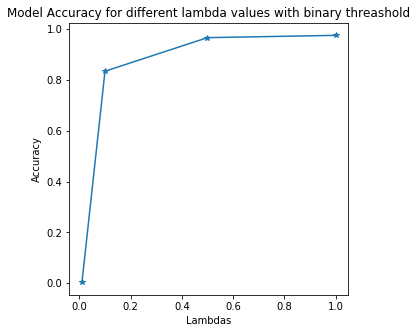

In [32]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(lmds, accuracies_LBFGS_binary, "*-")
plt.title("Model Accuracy for different lambda values with binary threashold")
plt.xlabel("Lambdas")
plt.ylabel("Accuracy")
plt.savefig('Results/Testing L-BFGS mnist binary.png')
plt.show()

Testing accuracy using L-GSM 

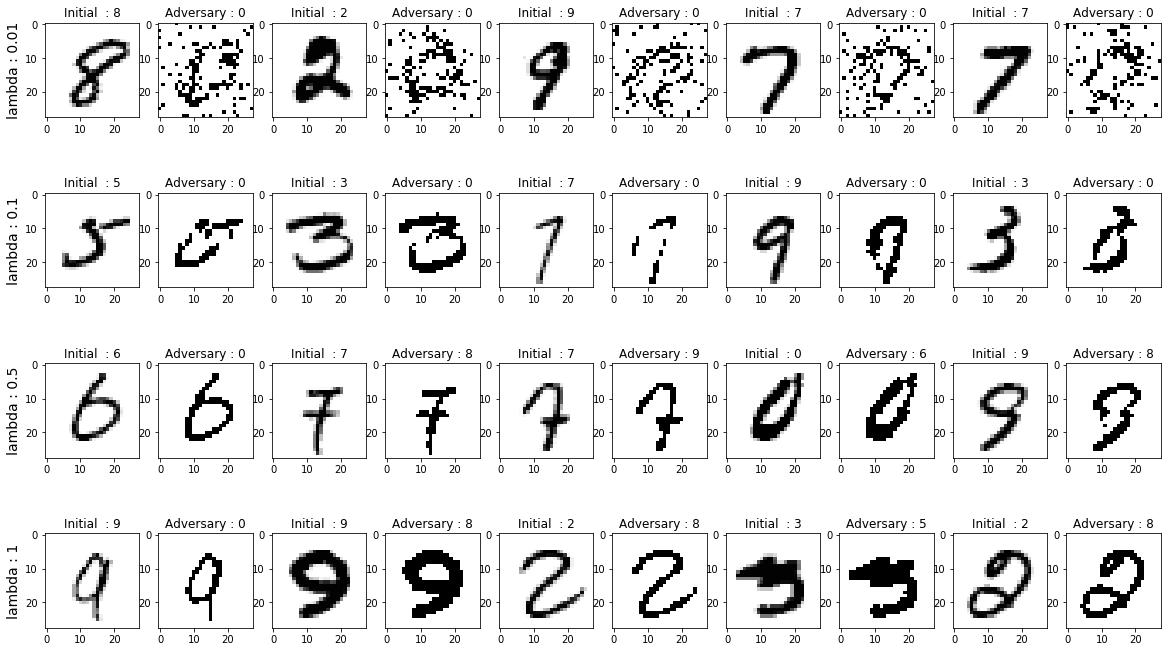

In [35]:
fig , axs = plt.subplots(nrows=len(lmds), ncols=len(examples_LBFGS_binary[0])*2,figsize=(20,12))

for i , lmd in enumerate(lmds):
    for j in range(0,len(examples_LBFGS_binary[0])):
        original, adversary, init_pred , final_pred = examples_LBFGS_binary[i][j]
        axs[i, 2*j].imshow(original,cmap='Greys')
        axs[i,0].set_ylabel("lambda : {}".format(lmd), fontsize=14)
        axs[i, 2*j].set_title('Initial  : {}'.format(init_pred.item()))
        axs[i, 2*j+1].imshow(adversary,cmap='Greys')
        axs[i, 2*j+1].set_title('Adversary : {}'.format(final_pred.item()))
plt.savefig('Results/Exemples LBFGS mnist binary.png')
plt.show()

### Binary defense against FGSM

In [73]:
#%timeit 
accuracies_FGSM_binary = []
examples_FGSM_binary = []
epsilons =[0.1,0.3,0.5,0.7]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm_mnist_binary(model, device, test_loader, eps)
    accuracies_FGSM_binary.append(acc)
    examples_FGSM_binary.append(ex)





















Iteration for epsilon = 0.1:   0%|          | 0/10000 [00:00<?, ?it/s]



















Iteration for epsilon = 0.1:   0%|          | 32/10000 [00:00<00:31, 315.78it/s]



















Iteration for epsilon = 0.1:   1%|          | 65/10000 [00:00<00:31, 319.17it/s]



















Iteration for epsilon = 0.1:   1%|          | 98/10000 [00:00<00:30, 320.05it/s]



















Iteration for epsilon = 0.1:   1%|▏         | 130/10000 [00:00<00:31, 317.85it/s]



















Iteration for epsilon = 0.1:   2%|▏         | 161/10000 [00:00<00:31, 314.73it/s]



















Iteration for epsilon = 0.1:   2%|▏         | 194/10000 [00:00<00:30, 316.50it/s]



















Iteration for epsilon = 0.1:   2%|▏         | 226/10000 [00:00<00:30, 317.47it/s]



















Iteration for epsilon = 0.1:   3%|▎         | 259/10000 [00:00<00:30, 319.35it/s]



















Iteration for epsilon = 0.1:   3%|▎         | 292/10000 [00:00<00:30, 322.00it/s]





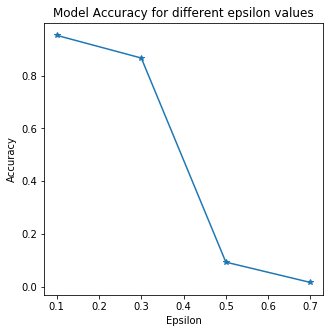

In [75]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(epsilons, accuracies_FGSM_binary, "*-")
plt.title("Model Accuracy for different epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig('Results/Testing FGSM mnist binary.png')
plt.show()

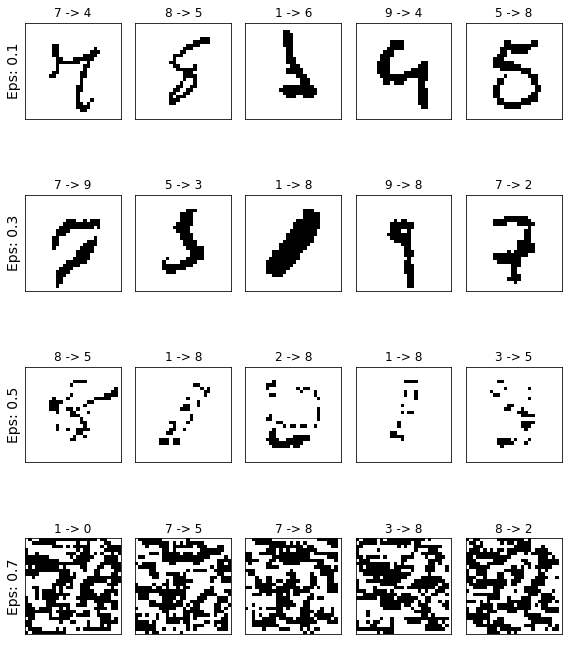

In [76]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_FGSM_binary[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_FGSM_binary[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_FGSM_binary[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="Greys")
plt.tight_layout()
plt.savefig('Results/Exemples FGSM mnist binary.png')
plt.show()